Extraction of the **source signature** from data. © 2019 Kajetan Chrapkiewicz.

##### *Notebook setup

In [4]:
# %load ~/software/fullwavepy/nb_config.py
# -----------------------------------------------------------------------------
# Load default notebook's callables (defined in fullwavepy/__init__.py)
# -----------------------------------------------------------------------------
from fullwavepy import *

# -----------------------------------------------------------------------------
# Configure matplotlib
# -----------------------------------------------------------------------------

# Set matplotlib's backend ------

# 1. non-interactive plots, display in a notebook cell
%matplotlib inline

# 2. interactive plots, display in a notebook cell
 # %matplotlib notebook

# Set matplotlib's style ---------
plt.style.reload_library()

# Combine styles (right overwrites left wherever they overlap):
plt.style.use(['default', 'ggplot', 'kmc_test'])
# print(plt.style.available)

# -----------------------------------------------------------------------------
# Configure logging
# -----------------------------------------------------------------------------
from fullwavepy.logging_config import *
set_logging_level(INFO) # TRACE / DEBUG / INFO / WARNING / ERROR / CRITICAL

# -----------------------------------------------------------------------------
# Other notebook's configuration
# -----------------------------------------------------------------------------

# autocompleting
%config IPCompleter.greedy=True 

# automatically reload modules before execution
%load_ext autoreload
%autoreload 2

In [1]:
from fullwavepy.ioapi.segy import array2sgy
from fullwavepy.signalproc.su import *
from fullwavepy.signalproc.wavelet import *
from fullwavepy.plot.data import *

In [2]:
f1 = 2
f2 = 3
f3 = 4.5
f4 = 6.5
zerophase = False

# Introduction

•
 Low-frequency wavelet
•
 Same zero-time as pre-processed data
•
 Same filters as pre-processed data
•
 Wavelet with no source or receiver ghosts
•
 May be non-causal


A seismic source function is a time series that when convolved with the Earth's response and the receiver's response will produce a seismogram recorded in the field. This corresponds to a direct wave (without a ghost etc.) propagated through a perfectly elastic, homogeneous medium, shifted in time to start zero and with amplitude corrected for geometric spreading.

The main goal is to **deghost the 'direct' water wave**. In a real experiment recording of the direct waves is contaminated by other arrivals. One can keep their presence to a minimum by looking only at the shortest offsets and using narrow time windows. This approach eliminates refractions and most reflections, especially for deep water settings (multiples arrive outside the window). A ghost (reflection from the sea surface), however, remains in the data since the airgun is fired just below the sea surface.

## Airgun source

Lamont-Doherty Earth Observatory (LDEO)

The purpose of the clusters is to provide a larger, more slowly reverberating residual air bubble (which improves overall array tuning) while at the same time reducing the amplitude of that bubble’s reverberation, which further improves tuning.

## Previous wavelets

### CP

CP proposed 2 source wavelets that agree with L.-D. theoretical source in 1-35 Hz range (good match), 4-35 Hz (excellent match):
1. six stacked shots of W127 station, duration 0.3 s
2. ...

### JM

### MP

In [ ]:
source_wavelet_path = paths['source_wavelet_path']
!cp {source_wavelet_path}/mp_source_3d_17-10-17.sgy .

In [ ]:
fname = 'mp_source_3d_17-10-17.sgy'
Plot_File(fname, data_type='wavelet', dt=0.003, xlim=[0,0.4], aspect='equal', verbos=0)

In [ ]:
fname = 'mp_source_3d_17-10-17.sgy'
Plot_File(fname, data_type='wavelet', spectrum='ampl', dt=0.003, xlim=[0,50], verbos=0)

In [ ]:
source_wavelet_path = paths['source_wavelet_path']
!cp {source_wavelet_path}/mp_source_3d_7.5Hz_17-10-17.sgy .

In [ ]:
# !sgy2vtr.sh mp_source_3d_7.5Hz_17-10-17.sgy 1
# !surange.sh mp_source_3d_7.5Hz_17-10-17.sgy

In [ ]:
fname = 'mp_source_3d_7.5Hz_17-10-17.sgy'
Plot_File(fname, data_type='wavelet', dt=0.003, xlim=[0,0.6], aspect='equal', verbos=0)

In [ ]:
Plot_File(fname, data_type='wavelet', spectrum='ampl', dt=0.003, xlim=[0,10], verbos=0)

### JA

- offsets 100-300 m
- only selected WHOI stations: W105, W108, W110, W139, W140, W146, W147, W162, W164, W176, W183, W186, W188 

In [ ]:
# JACK'S
IDs = ['W105', 'W108', 'W110', 'W139', 'W140', 'W146', 'W147', 'W162', 'W164', 'W176', 'W183', 'W186', 'W188']

## Mike's workflows

After Mike Warner.

### Ocean-bottom receivers

### Streamer (deep water)

Remarks:
- the workflow seems to correspond to a method used in our group by Mike for deep-water streamer data and by Jo, Jack, (...) for academic OBS data
- some of the notation and remarks come from various group presentations
- steps 1-2 prepare observed data, 3-5 synthetic data and 6-7 match the latter with the former
-  quantity $G$ in point 5. is a Green's function and the whole operation is performed implicitly in a synthetic run of Fullwave code
- we can express the Wiener filter as $f_1=(\vec{d}_{syn})^{-1} * \vec{d}_{obs}$, where $(\vec{d}_{syn})^{-1}$ is a convolutional inverse defined by $\vec{d}_{syn} * (\vec{d}_{syn})^{-1} = \delta $
- using above remark, we can express the final wavelet in terms of the initial guess as:
$$ S_2 = S_1 * (\vec{d}_{syn})^{-1} * \vec{d}_{obs} $$
- data include the ghost (wave reflected from the sea surface) and the relative positions of the source and the receiver (directionality)

### Streamer (shallow water)

# Theoretical background

We will show how to extract the source wavelet from the observed data using synthetic data and Wiener deconvolution. More on the theory of deconvolution is covered **data_process.ipynb**.

## Wiener filter design

Let us assume that observed data $d_{obs}$ can be expressed as a convolution of the source function $s$ and the Green's function $G$ plus some noise $e$:
$$ d_{obs} = s * G + e. $$

At first we will not deal with the receiver response. We can incorporate it into $s$ or just assume it to be a perfect Dirac delta $\delta(t)$. We will initially neglect $e$ too:

$$ d_{obs} = s * G. $$

G is unknown too.

Our task is to determine $s$ given $d_{obs}$. We can generate synthetic data using initial-guess source $s_0$ and $G_0$:

$$ d_{syn} = s_0 * G_0. $$

$G_0$ is our approximation of the true Green's function $G$ and is defined by the  best-guess model of the subsurface and a numerical solver of the PDE (imperfectly) describing the wave propagation in that model.

We can design a Wiener filter $w$ that transforms $d_{syn}$ into $d_{obs}$:

$$ w = (d_{syn})^{-1} * d_{obs} = s_0^{-1} * G_0^{-1} * s * G $$

This clearly works because:
$$ d_{syn}*w = d_{syn} *[(d_{syn})^{-1} * d_{obs}] = [d_{syn}*(d_{syn})^{-1}] * d_{obs} = \delta * d_{obs} = d_{obs} $$

Note that we used the property:

$$ (a*b)^{-1} = a^{-1} * b^{-1} $$

which can be proved by noticing that $a^{-1} * b^{-1} * (a * b) = \delta $.

If the approximation:

$$ G_0 \approx G $$

is sufficiently good, then $G_0^{-1} * G = \delta$ and the Wiener filter transforms the initial guess into the true wavelet:

$$ w * s_0 = (s_0^{-1} * s) * s_0 = s$$

## Caveats

- the workflow is only valid if $G_0 = G$ which means if we generate synthetics through a water model, we have to exclude seabottom multiples from the observed data
- wavelet may be different for different types of receivers as it should account for the response of the instrument:
    - in general: $m$ source-types, $n$ receiver-types  => $m \times n$ wavelets needed; here m=1, n=3 (or more if we count different channels)
    - for a single receiver-type, the response is automatically accounted for in the wavelet
    - for different receiver-types, we either need different wavelets (EPICMods) or assume identical (flat) response in the frequency range of interest

# Extraction from data (3rd pass)
Presentation to Jo and Michele and PROTEUS team.

In [2]:
!pwd

/media/kmc3817/DATADRIVE1/heavy_PhD/PROJECTS/data_wavelet


In [63]:
data_fname = 'data/ok.sgy'
dt = 0.005 # s

(0.2, 1)

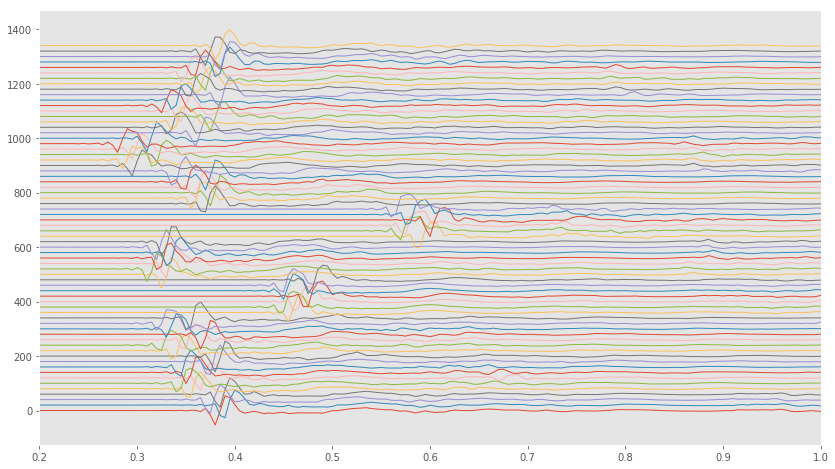

In [64]:
s, g = read_coords(data_fname)
A = read_any(data_fname)
plot(A, norm='rms', cmap='seismic', ptype='wiggle', dt=0.005, gap=20)
plt.xlim(0.2,1)

## dobs

(0.2, 1)

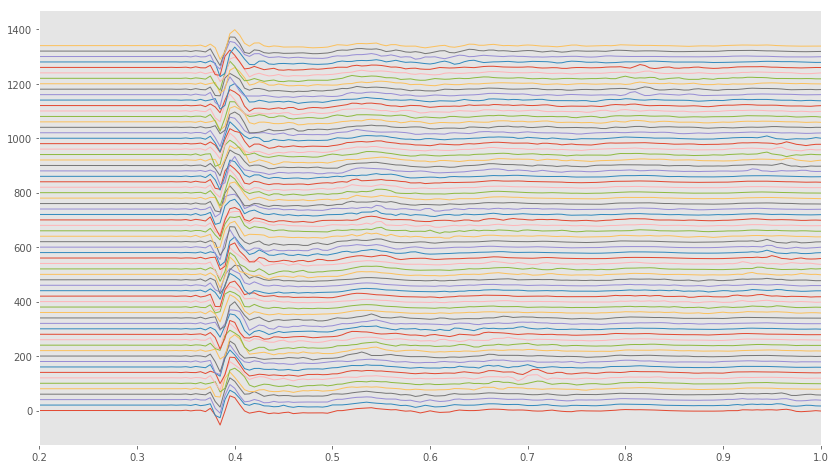

In [65]:
i_target = 0
Aa = align(A, i_target)
s_dobs = s[i_target]
g_dobs = g[i_target]
plot(Aa, norm='rms', cmap='seismic', ptype='wiggle', dt=0.005, gap=20)
plt.xlim(0.2,1)

(0.3, 2)

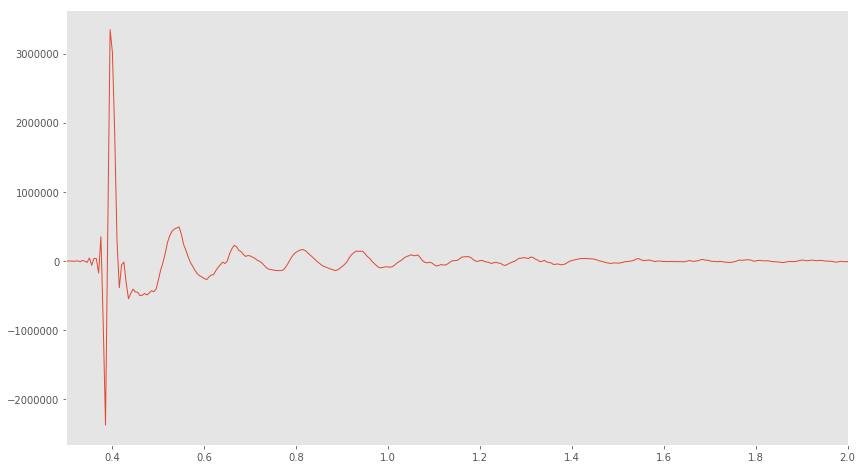

In [66]:
dobs = stack(Aa)
plot(dobs, dt=dt)
plt.xlim(0.3, 2)

(0, 2)

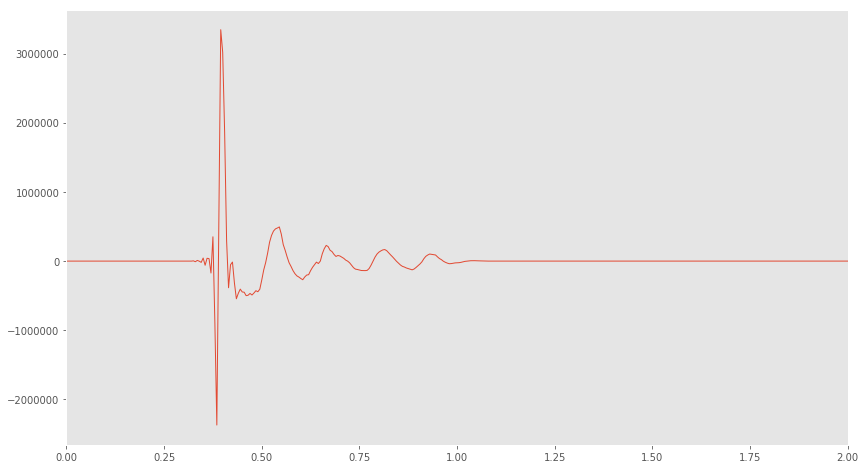

In [67]:
times = (reverbs(data_fname, 2))[i_target]
tstart, tend = times
dobs_m = su_process(dobs, su_mute, dt, [tend], mode='bottom', ntaper=50)
plot(dobs_m, dt=dt)
plt.xlim(0,2)

In [84]:
# test = su_process(dobs, su_filter_full, dt, **kwargs)
# plot(test, dt=dt)
# plt.xlim(0,5)

dt_ms 5.0
tbeg, tend 50000.0 50000.0


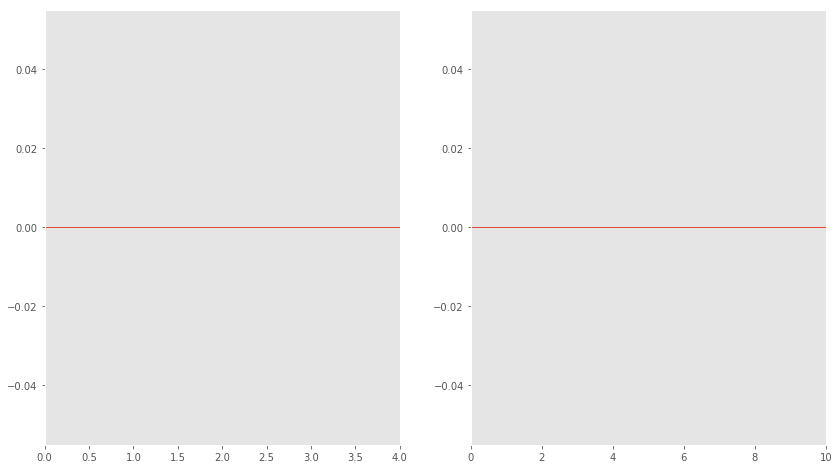

In [68]:
# THAT DOESN'T WORK BECAUSE I CHANGED ARGS OF filter function IN THE MEANTIME
kwargs =  {'f1': f1, 'f2': f2, 'f3': f3, 'f4': f4, 'zerophase': zerophase}
dobs_mf = su_process(dobs_m, su_filter_full, dt, **kwargs)
# THIS IS IMPORTANT <= SETS HEADER
export_dobs(dobs_mf, proj.inp.path+proj.name+'-RawSeis.sgy', dt, s_dobs, g_dobs)
# plot(dobs_mf, dt=dt)
# plt.xlim(0,4)
time_freq(dobs_mf, {'xlim': (0,4)}, {'xlim': (0,10)}, dt=dt)

## s0

### M1 shifted dobs

The problem is, shifting dobs to zero is very arbitrary therefore it's better to use filtered spike at zero time. But we can't taper it so filters are not exactly the same...

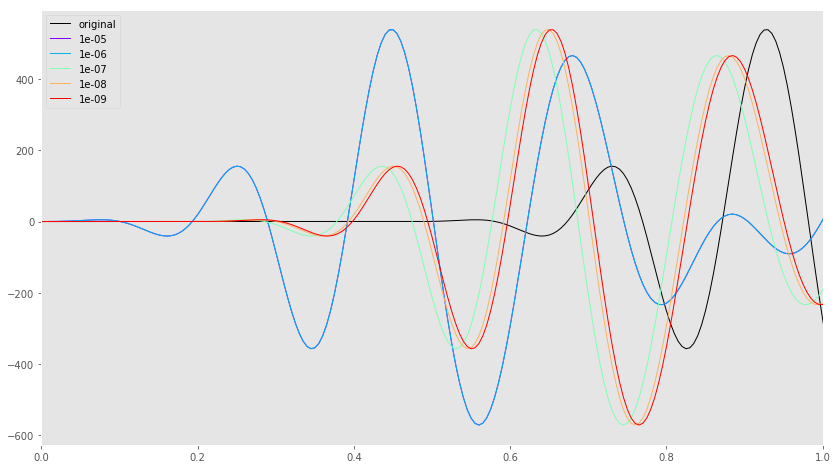

In [207]:
plot(dobs_mf, c='k', dt=dt, llabels=['original'])
plt.xlim(0,1)

powers = range(5,10)
clrs = colors(len(powers))
for p in powers:
    fraction = 10**(-p)
    dobs_mfs = shift_to_zero(dobs_mf, fraction=fraction)
    plot(dobs_mfs, dt=dt, c=next(clrs), llabels=[str(fraction)])
plt.legend()

### M2 filtered spike

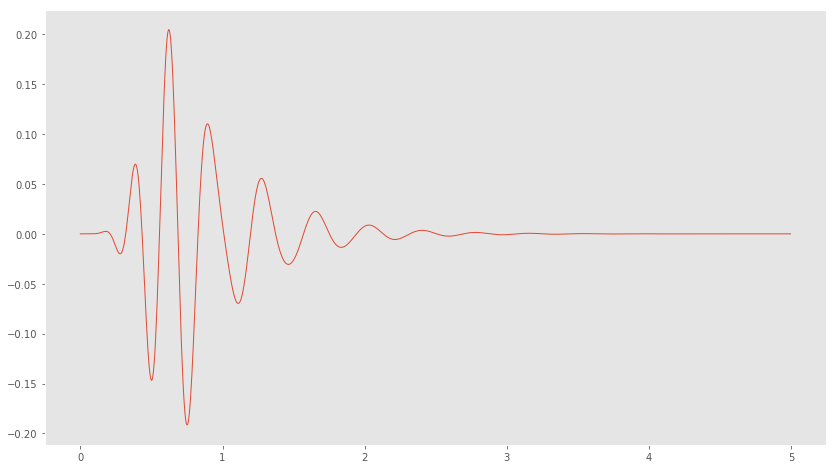

In [69]:
spike = np.zeros((1,1,ns))
spike[0] = 1
kwargs =  {'f1': f1, 'f2': f2, 'f3': f3, 'f4': f4, 'zerophase': zerophase}
spike = su_process(spike, su_filter, dt, **kwargs)
plot(spike, dt=dt)
# plt.xlim(0,4)

## dsyn

### Input

In [10]:
info = """
Generation of synthetic data for a matching filter.
Observed data: stacked clean traces within 100-300 offset, WHOI stations.

"""

In [11]:
margin = 5000 # m
ns = 1000
dx = 50      
x1 = min(s_dobs[0], g_dobs[0]) - margin    
x2 = max(s_dobs[0], g_dobs[0]) + margin     
y1 = min(s_dobs[1], g_dobs[1]) - margin      
y2 = max(s_dobs[1], g_dobs[1]) + margin   
z1 = 0
z2 = 2 * margin   
box = [x1, x2, y1, y2, z1, z2]
timespace = [box, dx, ns, dt]

In [70]:
proj = ProjSynVsObs('p05', paths=paths_kmc, io='sgy', timespace=timespace, info=info)
proj.info.cat()
proj.dims

Content of  ./p05/p05-Info.txt : 

Generation of synthetic data to check the wavelet output by the matching filter.
Observed data: stacked clean traces within 100-300 offset, WHOI stations.

 


[201, 206, 201]

In [40]:
proj.inp.wavelet.prepare(spike, dt)

In [45]:
args_rawseis = [[proj.name+'-RawSeis.sgy']]
kwargs_wavelet = {'array': spike, 'dt': dt}
kwargs_sp = {'reciprocity': False}
args_truevp = [1500]
proj.inp.prepare(args_rawseis=args_rawseis, 
                 kwargs_wavelet=kwargs_wavelet,
                 args_truevp=args_truevp,
                 kwargs_sp=kwargs_sp
                )


 SEGYPREP  -  Version 3.16.04                                                     
 ********

 Data preparation for 2D & 3D wavefield tomography

 Project name set to p05
 Preparing files for synthetics...

 Grid points in-line:                    201
 Grid points cross-line:                 206
 Grid points vertically:                 201
 Horiz grid spacing (metres):      50.0000000    
 Vert grid spacing (metres):       50.0000000    
 Model length (metres):            10000.0000    
 Model width (metres):             10250.0000    
 Model depth (metres):             10000.0000    

 Modelling time step (ms):         5.00000000    
 Output data delta-T (ms):         5.00000000    
 Output data length (ms):          5000.00000    
 Output data length (samples):          1000
 Time steps to model:                   1000

 Receiver-array fixed in space:          yes
 Renumber original channel numbers:       no
 Use FFID instead of SOURCE numbers:     yes
 FFID numbers are unique:     

(0, 10)

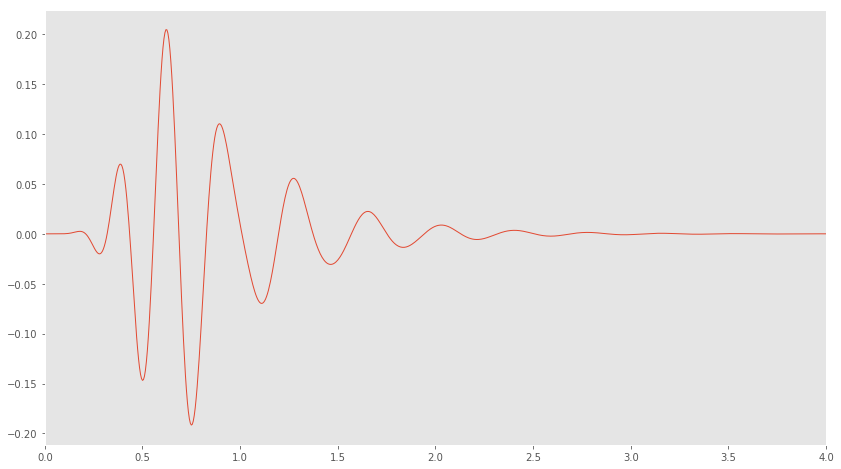

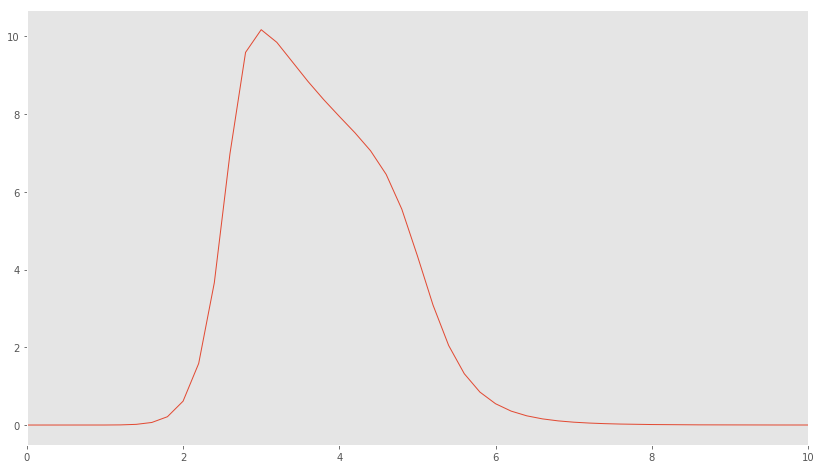

In [73]:
proj.inp.wavelet.plot(dt=dt)
plt.xlim(0,4)
plt.figure()
proj.inp.wavelet.plot(spect='ampl', dt=dt)
plt.xlim(0,10)

In [172]:
# proj.inp.outseis.plot(dt=dt)
# plt.xlim(0,4)
# proj.inp.wavelet.plot(spect='ampl', dt=dt)

### Output

In [50]:
proj.out.synerr.cat()

Content of  ./p05//out/p05-SynErr.log : 
 


In [51]:
# proj.out.synout.cat()

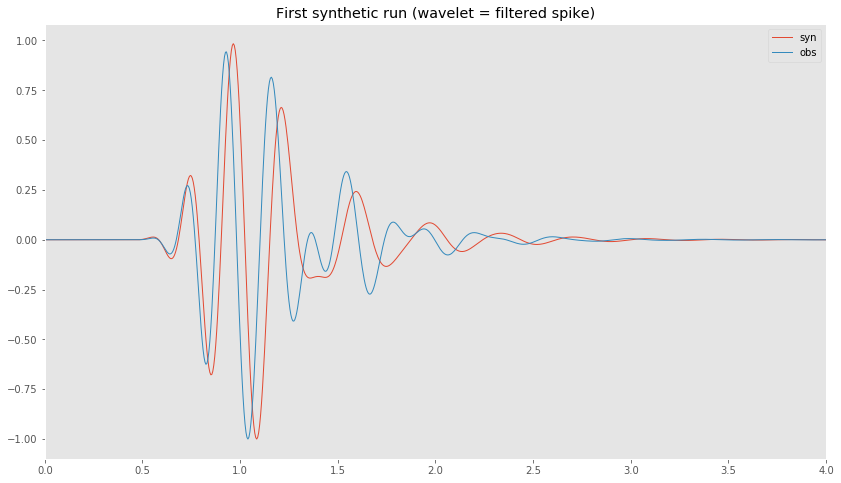

In [74]:
plt.title('First synthetic run (wavelet = filtered spike)')
proj.out.synth.plot(dt=dt, norm='max', llabels=['syn'])
proj.inp.outseis.plot(dt=dt, norm='max', llabels=['obs'])
plt.xlim(0,4)
plt.legend()

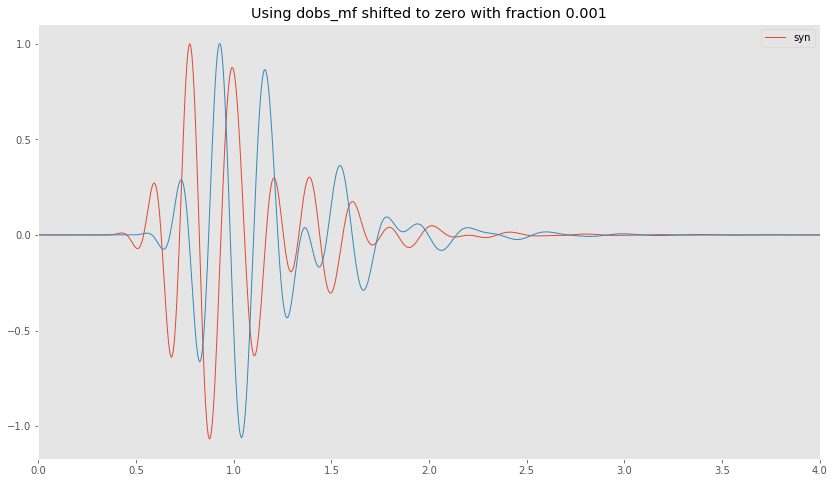

In [178]:
plt.title('Using dobs_mf shifted to zero with fraction 0.001')
proj.out.synth.plot(dt=dt, norm='max', llabels=['syn'])
proj.inp.outseis.plot(dt=dt, norm='max')
plt.xlim(0,4)
plt.legend()

## s1

In [13]:
s0 = proj.inp.wavelet.read()
dinp = proj.out.synth.read()
dout = proj.inp.outseis.read()
print(s0.shape, dinp.shape, dout.shape)
# plot(dinp, dt=dt, norm='max', llabels=['dinp (to shape)'])
# plot(dout, dt=dt, norm='max', llabels=['dout (desired)'])
# plt.xlim(0,4)
# plt.legend()

(1, 1, 1000) (1, 1, 1000) (1, 1, 1000)


In [25]:
# a = su_process(s0, su_decon, dt, pnoise=.001, d_inp=dinp, d_out=dout)
# plt.figure()
# plt.title(cap + ' s1')
# plot(a)
# plt.savefig(cap + ' s1.png')

# b = read_sushaper()
# plt.figure()
# plt.title(cap + ' w')
# plot(b)
# plt.savefig(cap + ' w.png') 

In [17]:
pad_ms = 20000
pad_ns = int(pad_ms / dt / 1000)

In [18]:
def pad(A, pad_ms, dt, mode):
    pad_ns = int(pad_ms / dt / 1000)
    if mode == 'no':
        Ap = A
    elif mode == 'trail':
        Ap = pad_traces(A, 2 * pad_ns)
    elif mode == 'both':
        Ap = su_process(A, su_pad, dt, pad_ms)
    
    return Ap

trail no both
Case 11
len(shaper) 9000


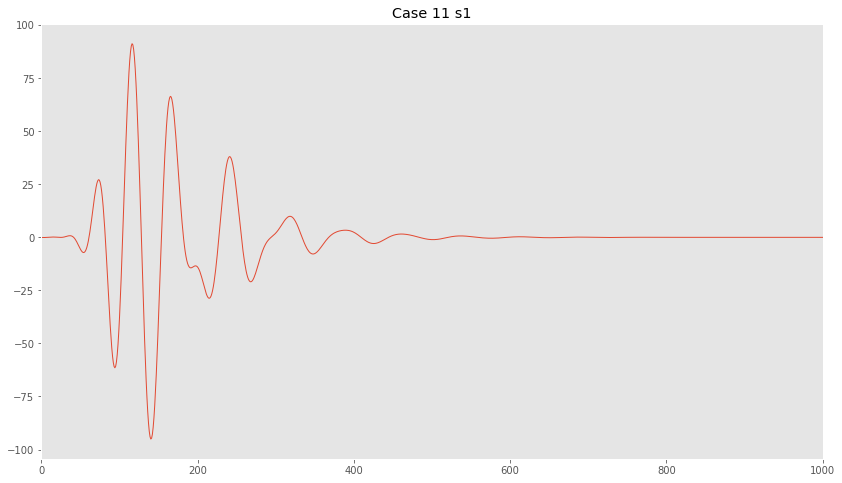

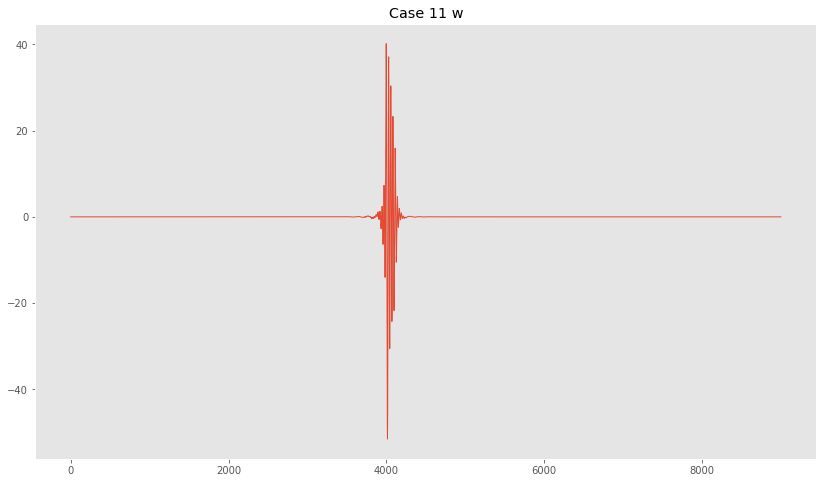

In [34]:
possbs = ['no', 'trail', 'both']
i = -1
for mode_s0 in possbs:
    for mode_dinp in possbs:
        for mode_dout in possbs:
            i += 1
            if i != 11:
                continue
            cap = 'Case ' + str(i)
            print(mode_s0, mode_dinp, mode_dout)
            print(cap)
            s0_p = pad(s0, pad_ms, dt, mode_s0)
            dinp_p = pad(dinp, pad_ms, dt, mode_dinp)
            dout_p = pad(dout, pad_ms, dt, mode_dout)
            
#             plt.figure()
#             plt.title(cap)
#             plot(s0_p, dt=dt, norm='max', llabels=['init. guess'])
#             plot(dinp_p, dt=dt, norm='max', llabels=['dinp (to shape)'])
#             plot(dout_p, dt=dt, norm='max', llabels=['dout (desired)'])
#             plt.legend()    
#             plt.savefig('input_' + str(i) + '.png')
            a = su_process(s0_p, su_decon, dt, pnoise=.001, d_inp=dinp_p, d_out=dout_p)
            plt.figure()
            plt.title(cap + ' s1')            
            plot(a)
            plt.xlim(0,1000)
#             plt.savefig(cap + ' s1.png')
#             plt.close()
            
            b = read_sushaper()
            plt.figure()
            plt.title(cap + ' w')            
            plot(b)
#             plt.savefig(cap + ' w.png')
#             plt.close()
            

In [36]:
b.shape

(1, 1, 9000)

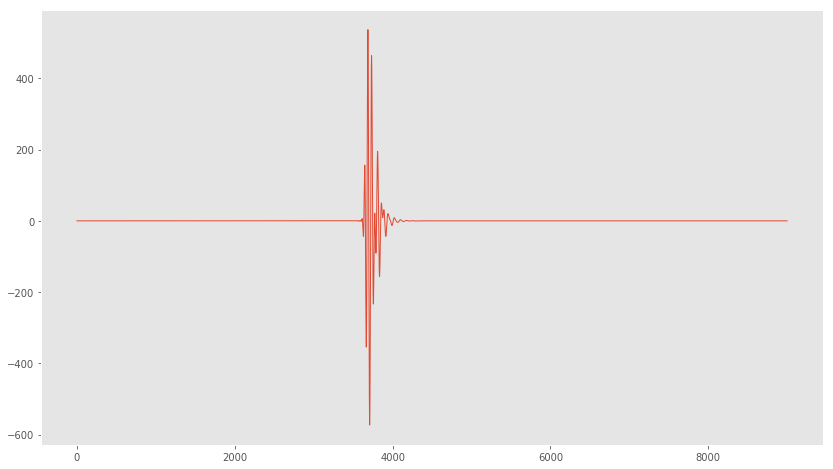

In [40]:
plt.plot(np.convolve(b[0][0], dinp_p[0][0], mode='same'))

(0, 1000)

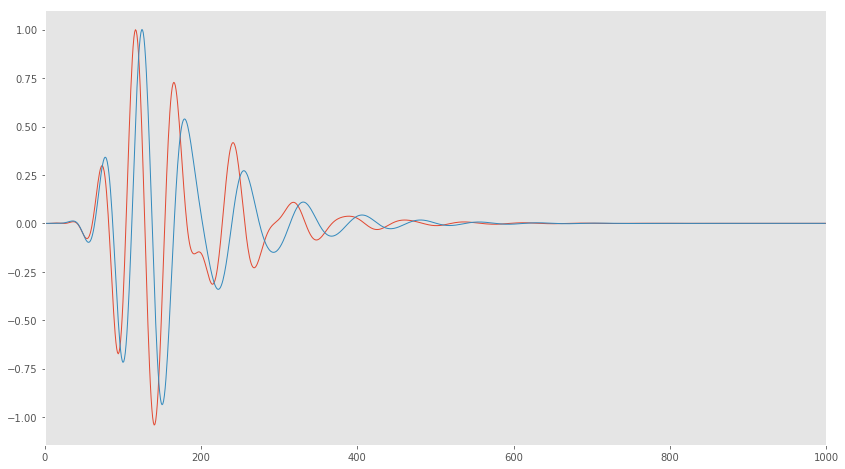

In [52]:
plot(a, norm='max')
plot(s0, norm='max')
plt.xlim(0,1000)

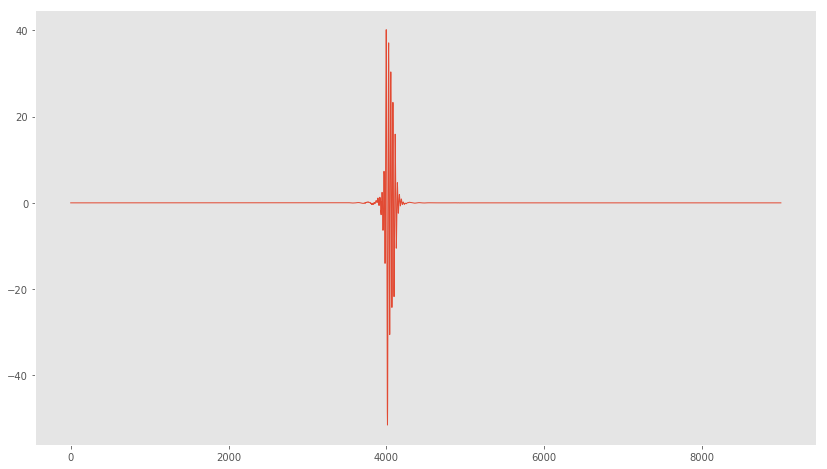

In [31]:
plot(b)

In [58]:
!suresamp

                                                                   
 SURESAMP - Resample in time                                       
                                                                   
 suresamp <stdin >stdout  [optional parameters]                    
                                                                   
 Required parameters:                                              
     none                                                          
                                                                   
 Optional Parameters:                                              
    nt=tr.ns    number of time samples on output                   
    dt=         time sampling interval on output                   
                default is:                                        
                tr.dt/10^6     seismic data                        
                tr.d1          non-seismic data                    
    tmin=       time of first sample in output  

In [61]:
a_cut = np.zeros((1,1,1000))
a_cut[0][0] = a[0][0][ :1000]
array2sgy('wavelet_19-09-22.sgy', a_cut, dt)
!segyread tape='wavelet_19-09-22.sgy' | suresamp rf=2 | segyhdrs | segywrite tape='wavelet_19-09-22.sgy' 

3200+0 records in
6+1 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.00178547 s, 1.8 MB/s
6+1 records in
1+0 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.000111997 s, 28.6 MB/s


In [ ]:
# search for sweet spot

In [26]:
possbs = ['no', 'trail', 'both']
i = 0
for mode_s0 in possbs:
    for mode_dinp in possbs:
        for mode_dout in possbs:
            cap = 'Case ' + str(i)
            print(cap)
            s0_p = pad(s0, pad_ms, dt, mode_s0)
            dinp_p = pad(dinp, pad_ms, dt, mode_dinp)
            dout_p = pad(dout, pad_ms, dt, mode_dout)
            
#             plt.figure()
#             plt.title(cap)
#             plot(s0_p, dt=dt, norm='max', llabels=['init. guess'])
#             plot(dinp_p, dt=dt, norm='max', llabels=['dinp (to shape)'])
#             plot(dout_p, dt=dt, norm='max', llabels=['dout (desired)'])
#             plt.legend()    
#             plt.savefig('input_' + str(i) + '.png')
            a = su_process(s0_p, su_decon, dt, pnoise=.001, d_inp=dinp_p, d_out=dout_p)
            plt.figure()
            plt.title(cap + ' s1')            
            plot(a)
            plt.savefig(cap + ' s1.png')
            plt.close()
            
            b = read_sushaper()
            plt.figure()
            plt.title(cap + ' w')            
            plot(b)
            plt.savefig(cap + ' w.png')
            plt.close()
            i += 1

Case 0
len(shaper) 1000
Case 1
len(shaper) 1000
Case 2
len(shaper) 1000
Case 3
len(shaper) 1000
Case 4
len(shaper) 1000
Case 5
len(shaper) 1000
Case 6
len(shaper) 1000
Case 7
len(shaper) 1000
Case 8
len(shaper) 1000
Case 9
len(shaper) 9000
Case 10
len(shaper) 9000
Case 11
len(shaper) 9000
Case 12
len(shaper) 9000
Case 13
len(shaper) 9000
Case 14
len(shaper) 9000
Case 15
len(shaper) 9000
Case 16
len(shaper) 9000
Case 17
len(shaper) 9000
Case 18
len(shaper) 9000
Case 19
len(shaper) 9000
Case 20
len(shaper) 9000
Case 21
len(shaper) 9000
Case 22
len(shaper) 9000
Case 23
len(shaper) 9000
Case 24
len(shaper) 9000
Case 25
len(shaper) 9000
Case 26
len(shaper) 9000


(1, 1, 9000) (1, 1, 9000) (1, 1, 9000)


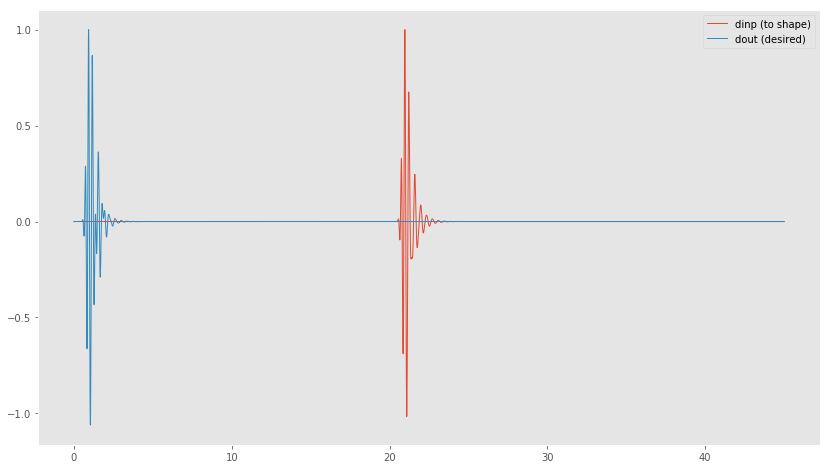

In [192]:
pad_ms = 20000
pad_ns = int(pad_ms / dt / 1000)
# dinp_p = pad_traces(dinp, 2 * pad_ns)
# s0_p = pad_traces(s0, 2 * pad_ns)
# s0_p = su_process(s0, su_pad, dt, pad_ms)
dout_p = pad_traces(dout, 2 * pad_ns)
dinp_p = su_process(dinp, su_pad, dt, pad_ms)
# dout_p = su_process(dout, su_pad, dt, pad_ms)
print(s0_p.shape, dinp_p.shape, dout_p.shape)
# plot(s0_p, dt=dt, norm='max', llabels=['init. guess'])
plot(dinp_p, dt=dt, norm='max', llabels=['dinp (to shape)'])
plot(dout_p, dt=dt, norm='max', llabels=['dout (desired)'])
# plt.xlim(0,4)
plt.legend()

len(shaper) 9000


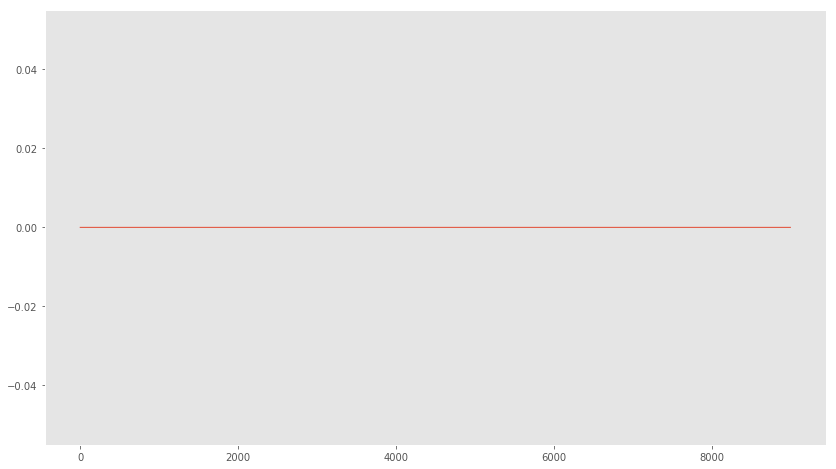

In [194]:
a = su_process(s0_p, su_decon, dt, pnoise=.001,
                    d_inp=dinp_p, d_out=dout)
# plot(a)
b = read_sushaper()
plot(b)

In [163]:
dirac = np.zeros(dinp_p.shape)
dirac[..., dirac.shape[-1]//2] = 1
# INVERSE OF DSYN
wiener = su_process(dout_p, su_decon, dt, 
                    d_inp=dinp_p, 
                    d_out=dirac, 
                    pnoise=.001)
# print(dinp_p.shape, dr.shape, dirac.shape)
dinp_pi = read_sushaper()

# plot(dinp_pi, dt=dt, norm='max')
# plot(wiener, dt=dt, norm='max')

# plt.plot(np.convolve(wiener[0][0], dinp_p[0][0], mode='same'))
# plt.plot(dout_p[0][0])
# plt.xlim(0,1000)

len(shaper) 5000


We are now ready to apply wiener to initiall guess:

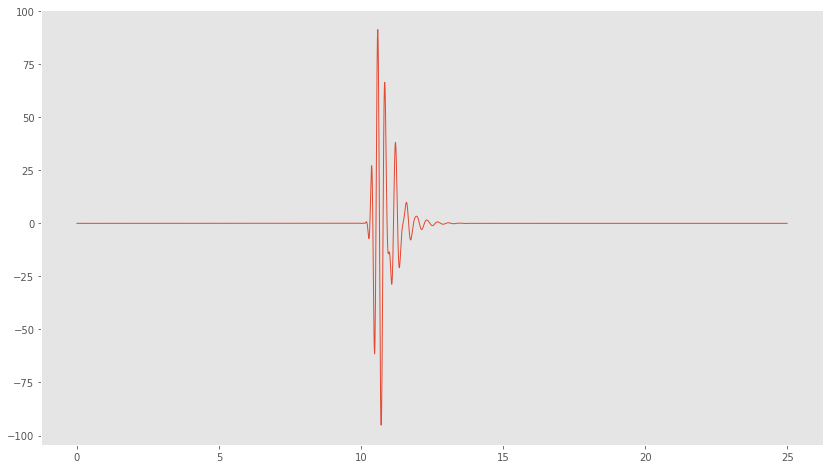

In [170]:
from fullwavepy.ioapi.segy import array2sgy
a = np.convolve(wiener[0][0], s0[0][0], mode='same')
s1 = np.zeros((1,1,len(a)))
s1[0][0] = a
plot(s1, dt=dt)

# s1 = np.array(s1[ :dsyn.shape[-1]])
# array2sgy('s1.sgy', tseries2array(s1), dt)
# plot('s1.sgy', norm='max', llabels=['derived wavelet'])
# plot(s0, norm='max', llabels=['initial guess'])
# plt.xlim(0,1200)
# plt.legend()

## dsyn2

### Input

In [45]:
info = """
Generation of synthetic data to check the wavelet output by the matching filter.
Observed data: stacked clean traces within 100-300 offset, WHOI stations.

"""

In [75]:
proj = ProjSynVsObs('p05_2', paths=paths_kmc, io='sgy', timespace=timespace, info=info)
proj.info.cat()
proj.dims

Content of  ./p05_2/p05_2-Info.txt : 

Generation of synthetic data to check the wavelet output by the matching filter.
Observed data: stacked clean traces within 100-300 offset, WHOI stations.

 


[201, 206, 201]

In [48]:
args_rawseis = [['../../p05/inp/p05-RawSeis.sgy']]
kwargs_wavelet = {'array': a, 'dt': dt}
kwargs_sp = {'reciprocity': False}
args_truevp = [1500]
proj.inp.prepare(args_rawseis=args_rawseis, 
                 kwargs_wavelet=kwargs_wavelet,
                 args_truevp=args_truevp,
                 kwargs_sp=kwargs_sp
                )

Content of  ./p05_2//inp/p05_2-RawSeis.txt : 
../../p05/inp/p05-RawSeis.sgy
 

 SEGYPREP  -  Version 3.16.04                                                     
 ********

 Data preparation for 2D & 3D wavefield tomography

 Project name set to p05_2
 Preparing files for synthetics...

 Grid points in-line:                    201
 Grid points cross-line:                 206
 Grid points vertically:                 201
 Horiz grid spacing (metres):      50.0000000    
 Vert grid spacing (metres):       50.0000000    
 Model length (metres):            10000.0000    
 Model width (metres):             10250.0000    
 Model depth (metres):             10000.0000    

 Modelling time step (ms):         5.00000000    
 Output data delta-T (ms):         5.00000000    
 Output data length (ms):          5000.00000    
 Output data length (samples):          1000
 Time steps to model:                   1000

 Receiver-array fixed in space:          yes
 Renumber original channel numbers:     

### Output

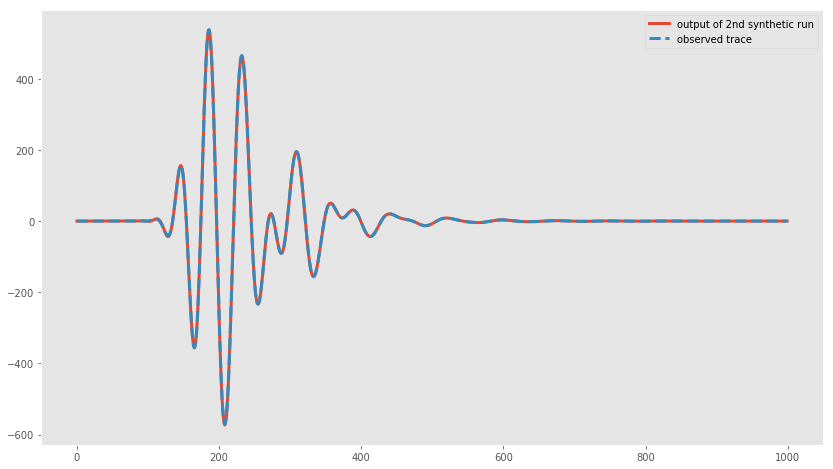

In [84]:
proj.out.synth.plot(lw=3, llabels=['output of 2nd synthetic run'])
proj.inp.outseis.plot(lw=3, ls='--', llabels=['observed trace'])
plt.legend()

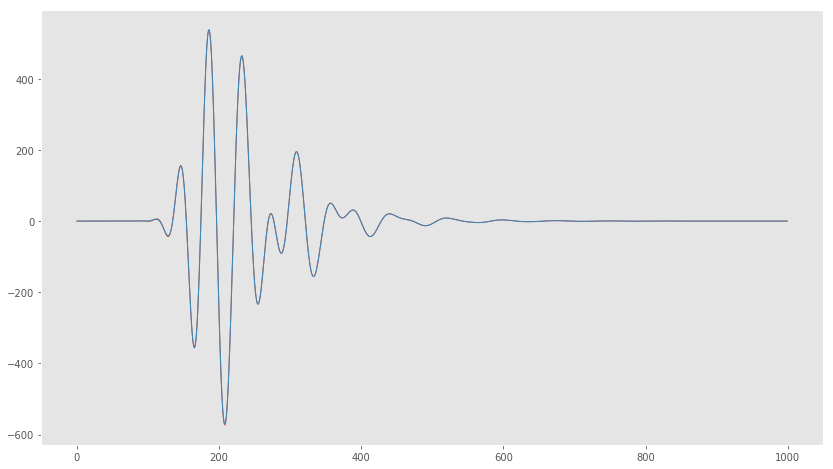

In [51]:
proj.out.synth.plot()
proj.inp.outseis.plot()

# Extraction from data (2nd pass)
First presentation to Jo and Michele, I think.

In [21]:
data_path = '/media/kmc3817/DATADRIVE1/heavy_PhD/DATA/Santorini_2015/seismic/'
comp = '4' # COMPONENT
sens = 'W' # SENSOR TYPE
dt = 0.005 # ms
fnames = get_files(data_path + 'OBS/segy_local_coords/', '*'+sens+'???_'+comp+'.sgy')

In [28]:
from fullwavepy.generic.parse import path_leave, strip, extend_fname
from fullwavepy.ioapi.su import suwind

key = 'offset'
vmin = 0
vmax = 300

for fname in fnames:
    print(fname)
    name = path_leave(fname)
    nfname = './data/' + extend_fname(name, [[key, str(vmin) + '-' + str(vmax)]])
    suwind(fname, nfname, key, vmin, vmax)

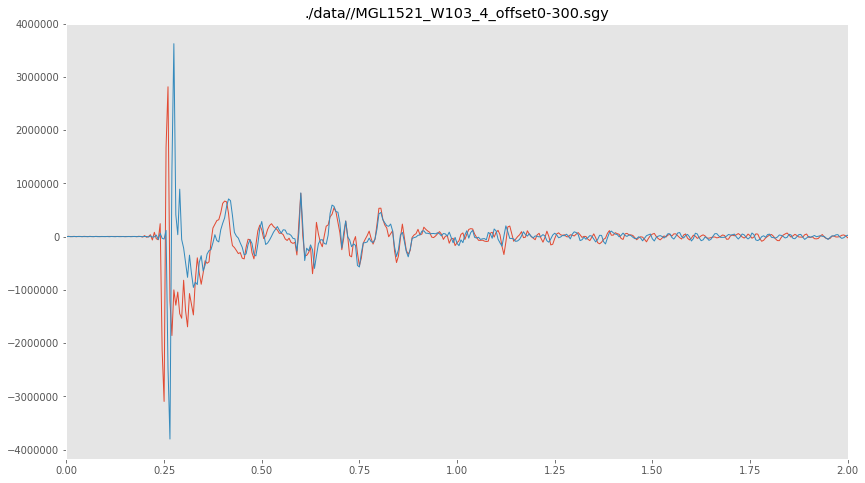

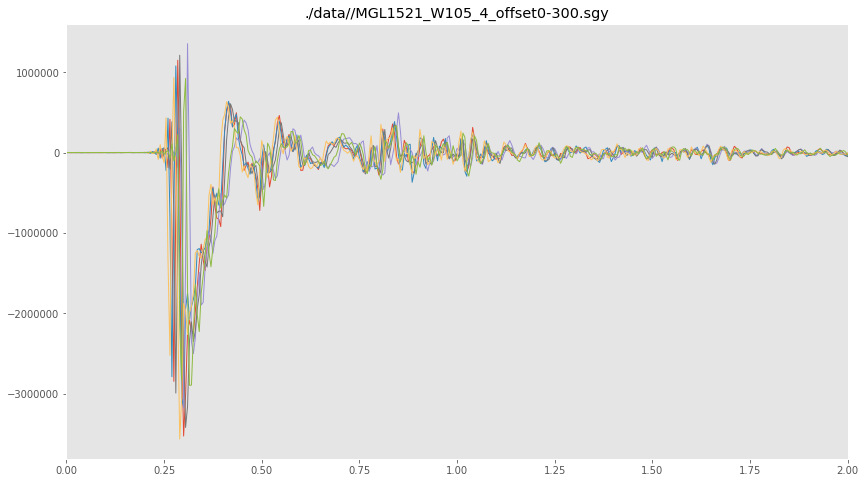

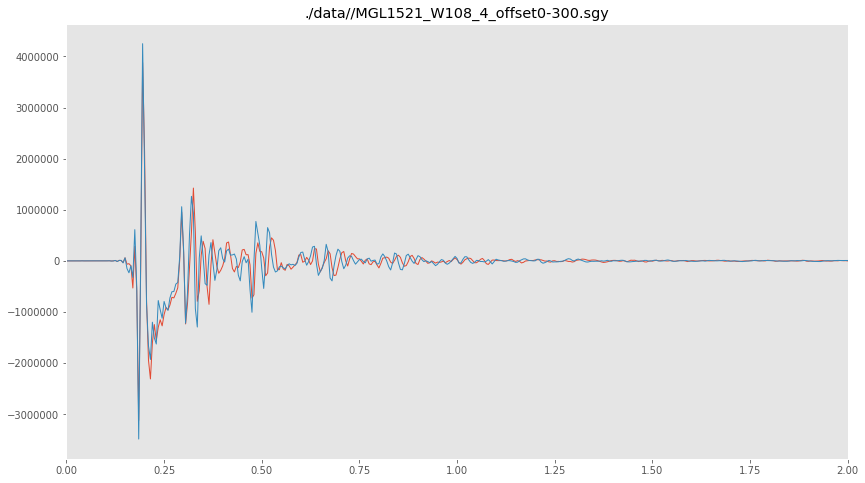

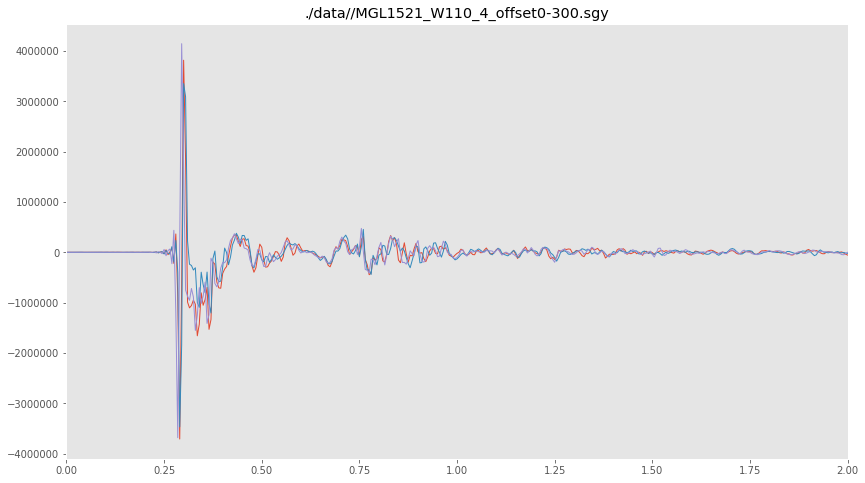

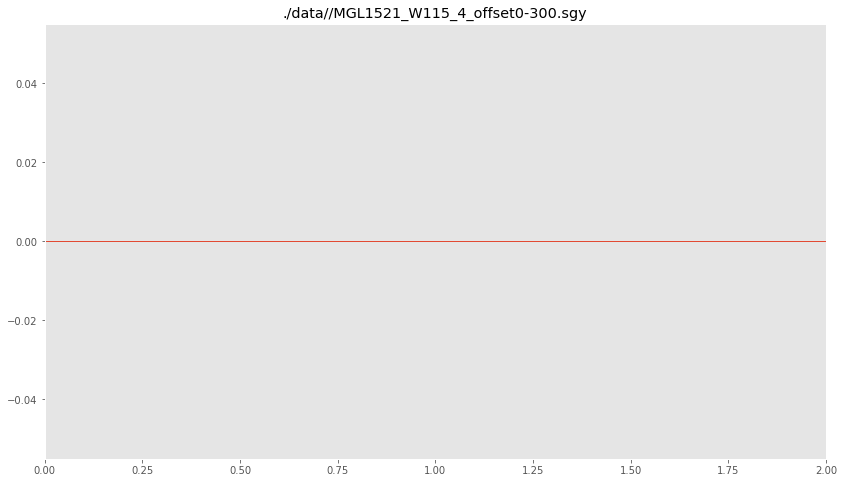

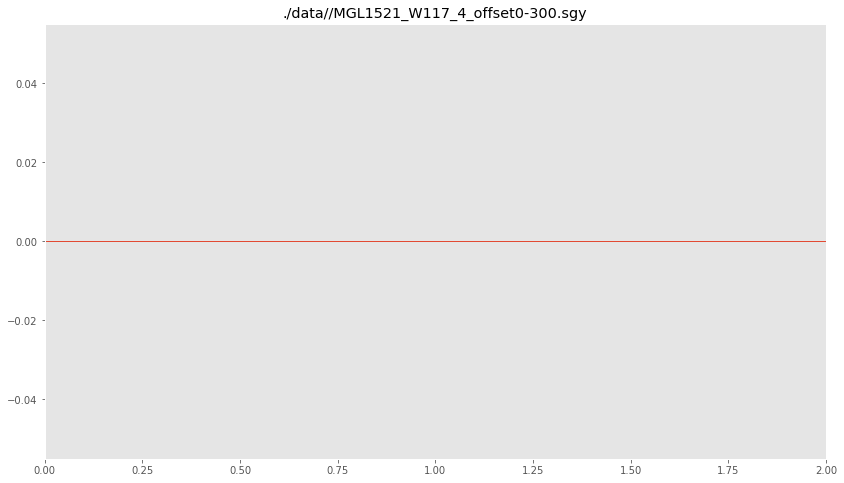

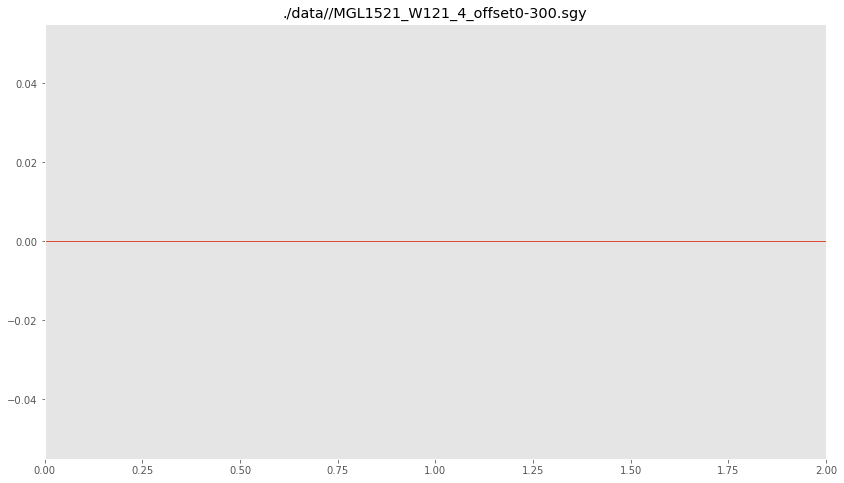

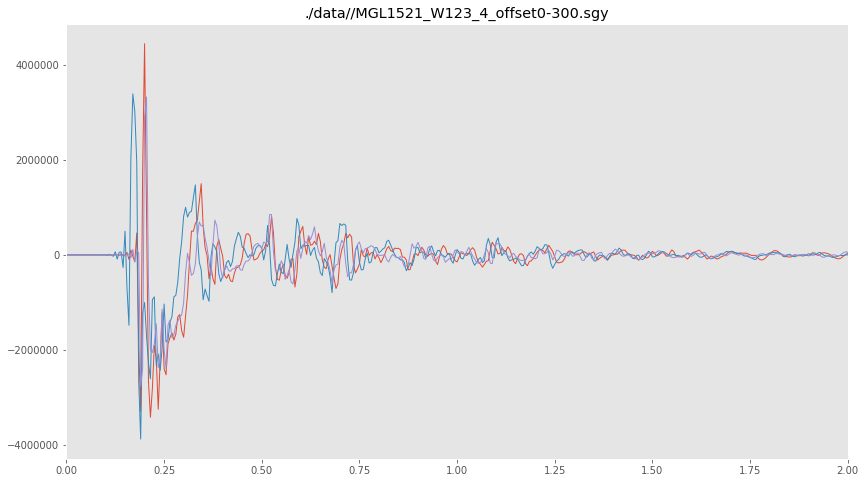

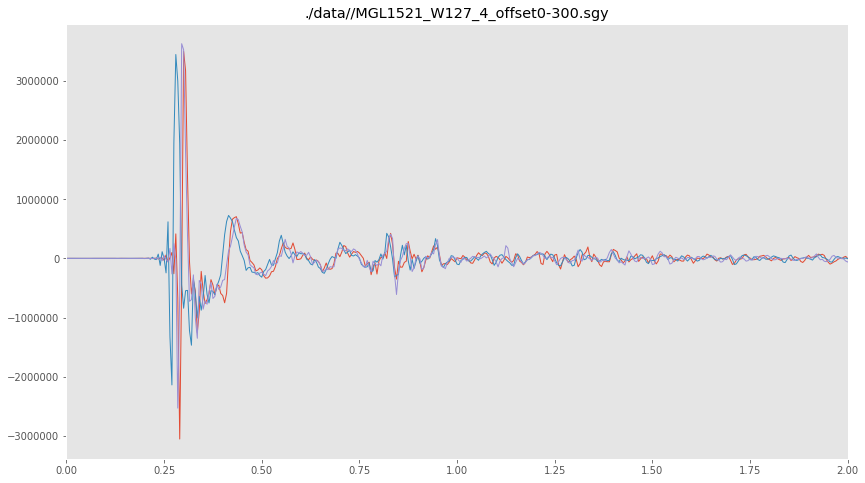

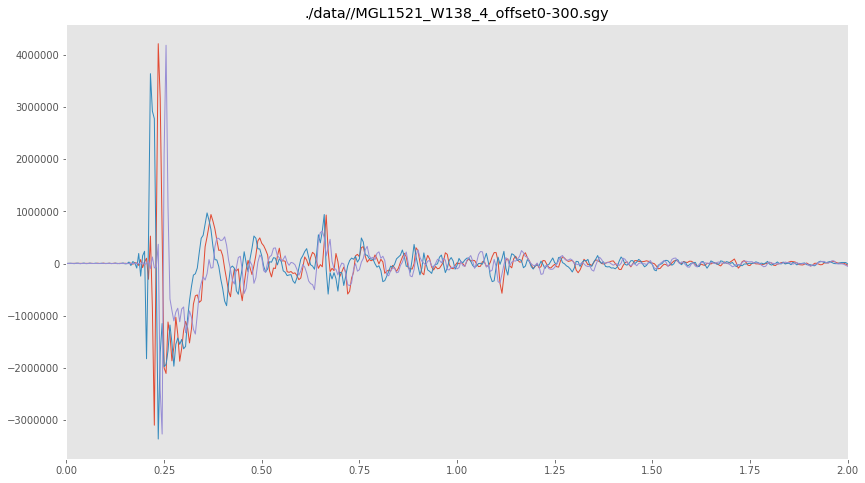

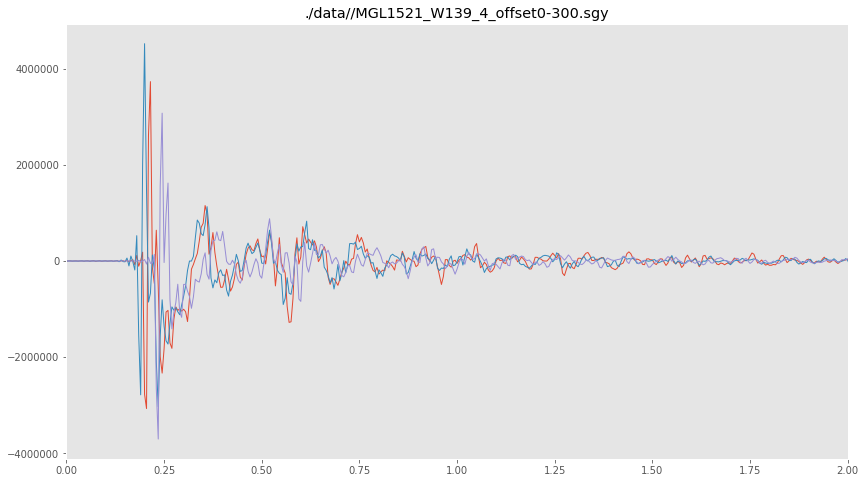

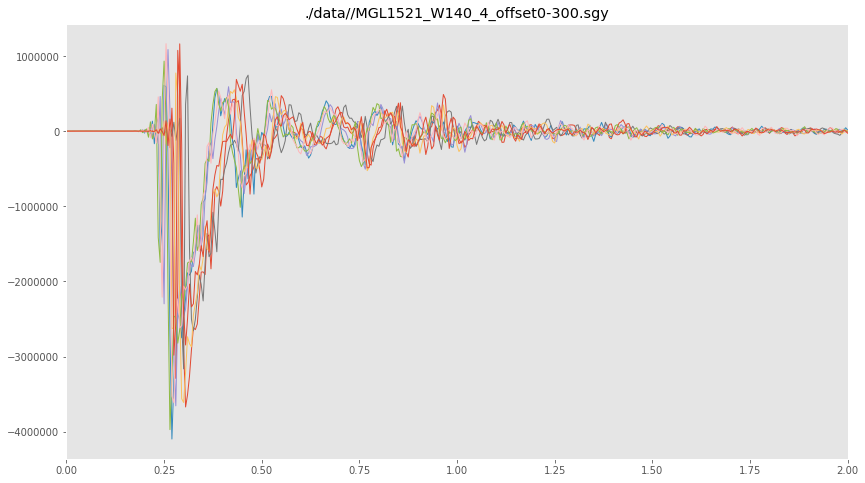

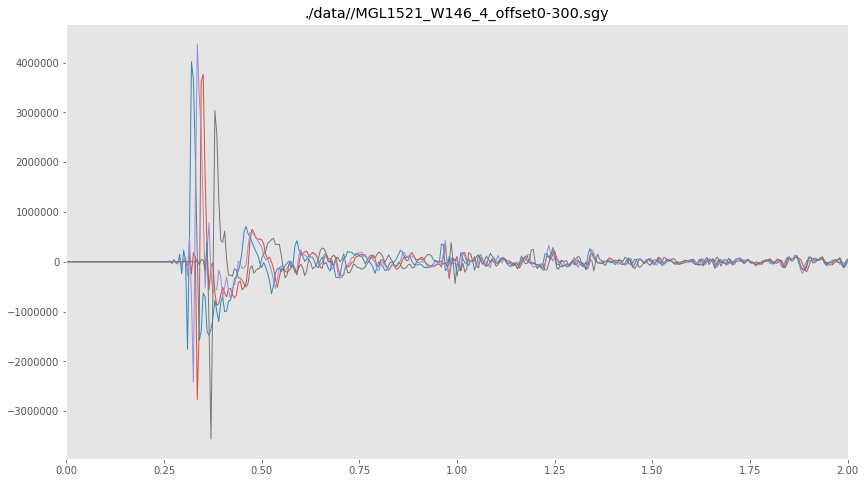

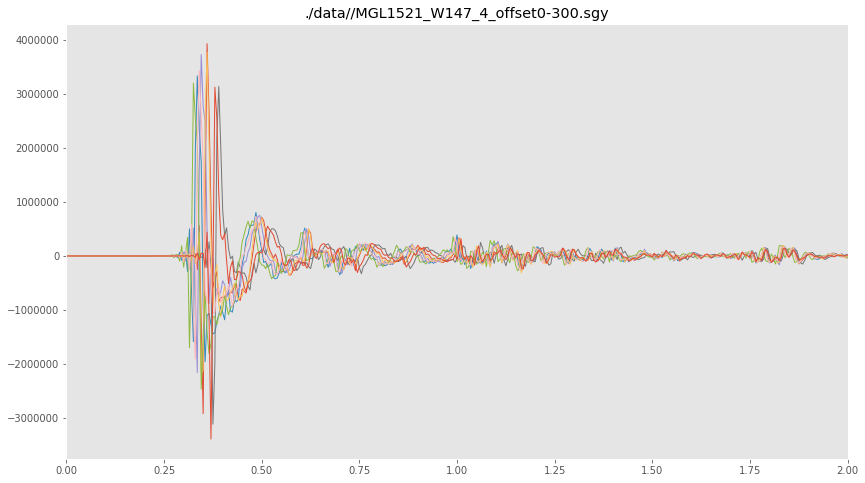

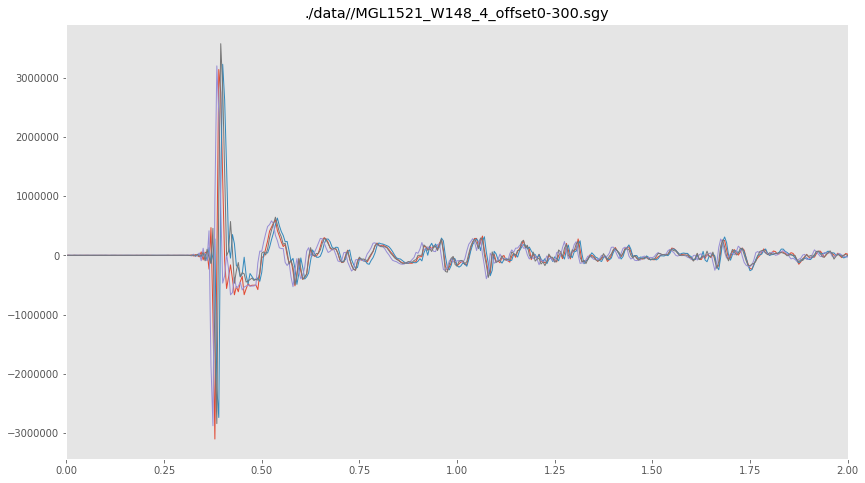

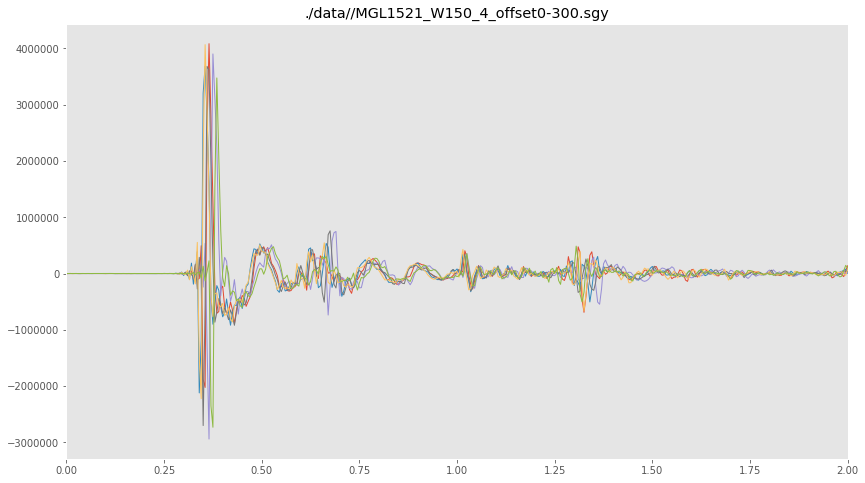

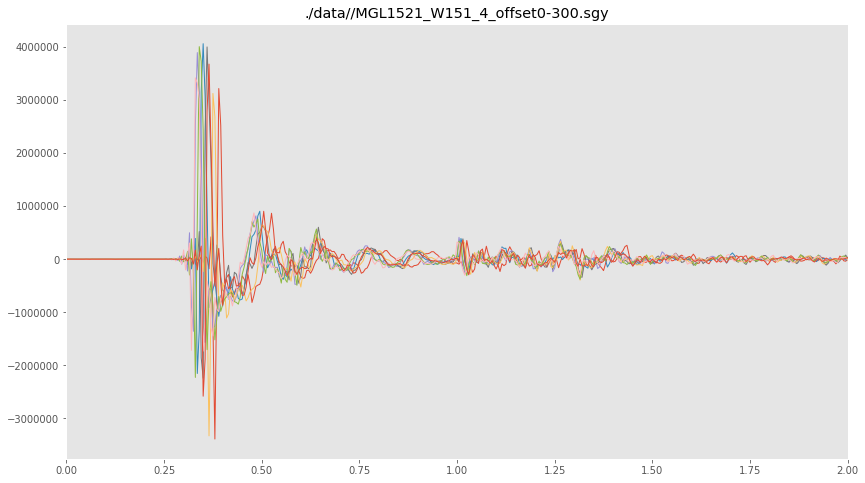

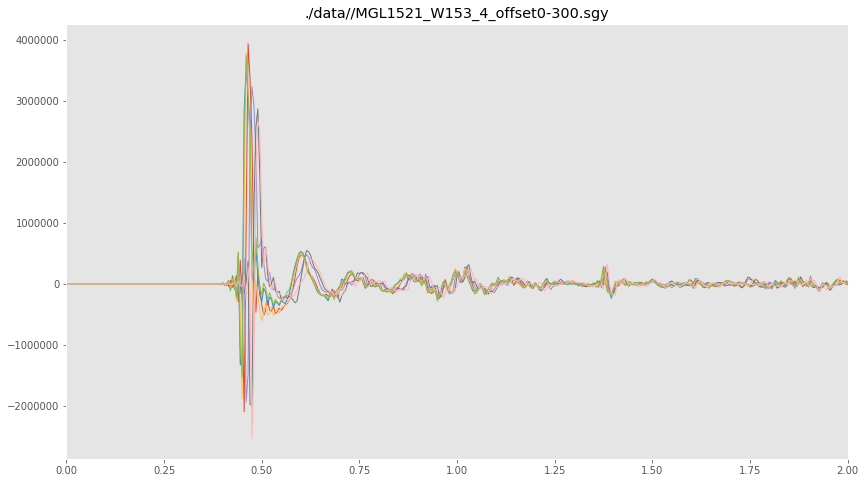

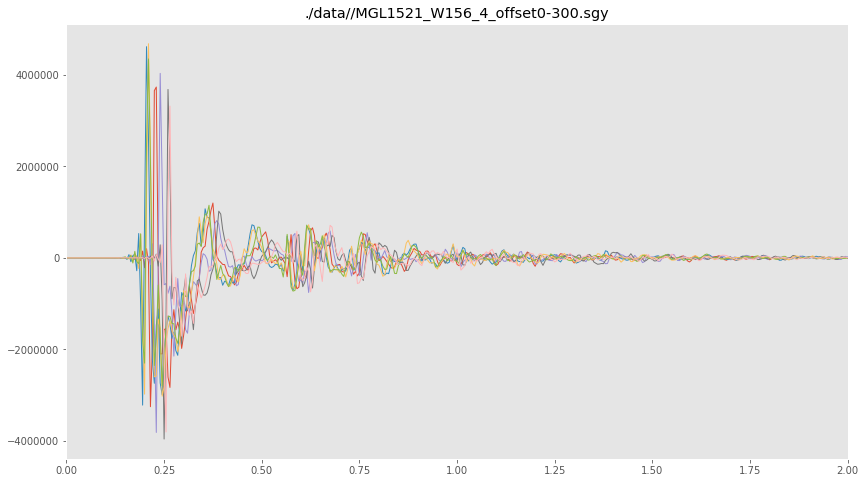

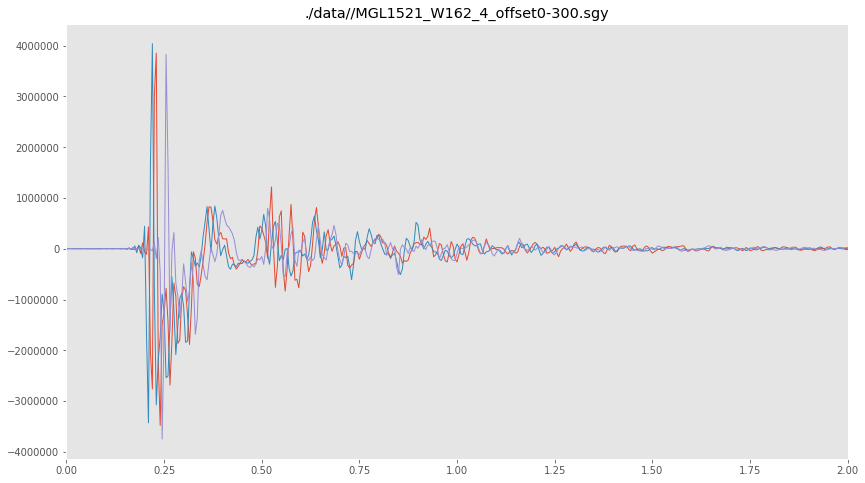

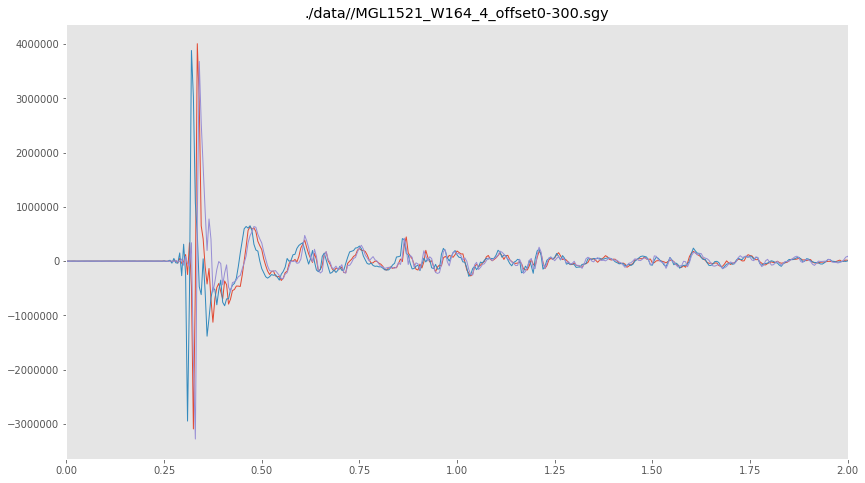

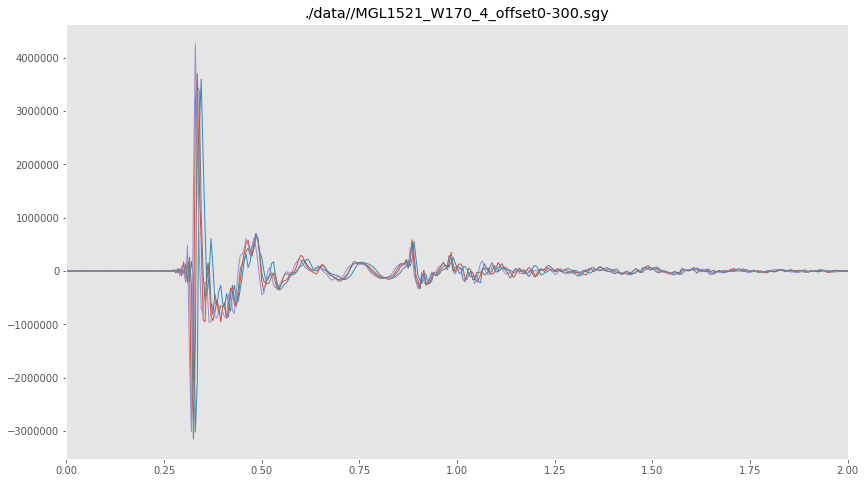

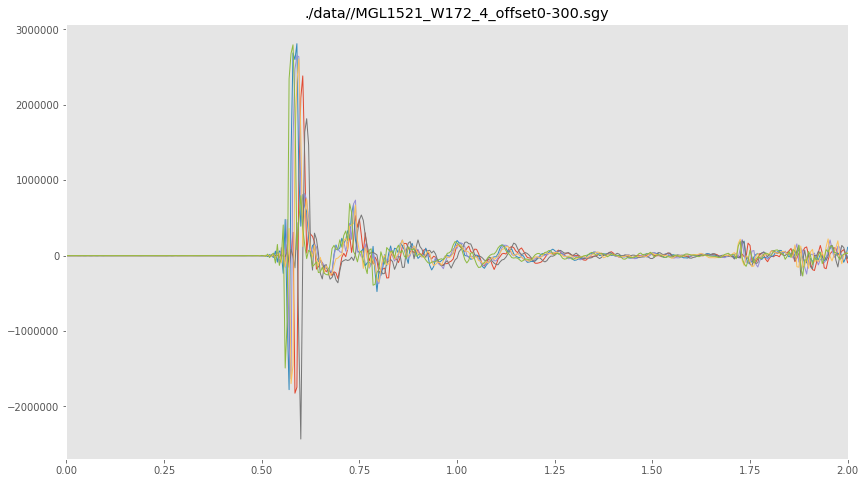

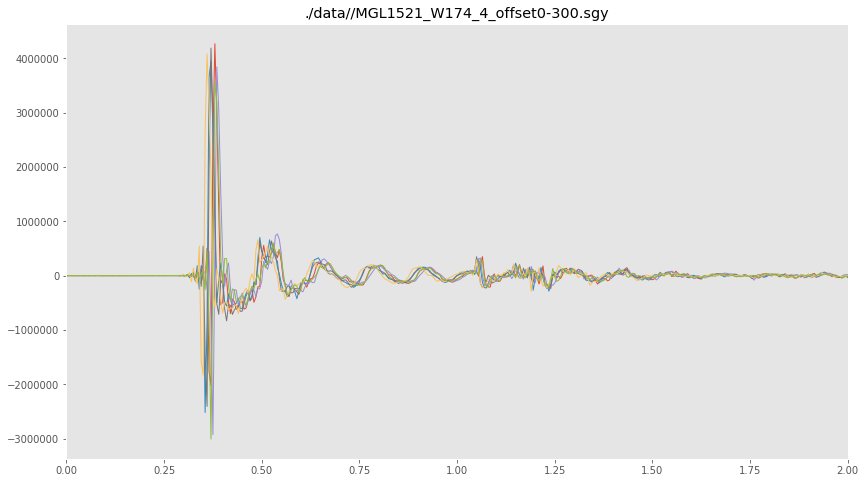

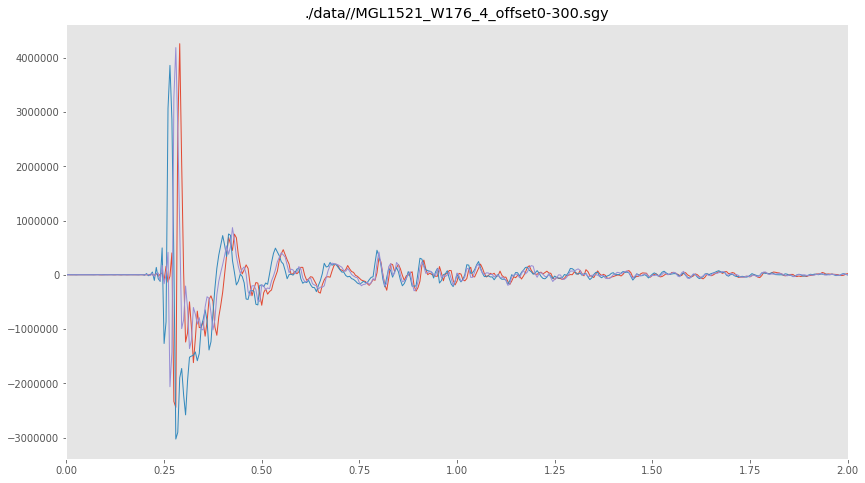

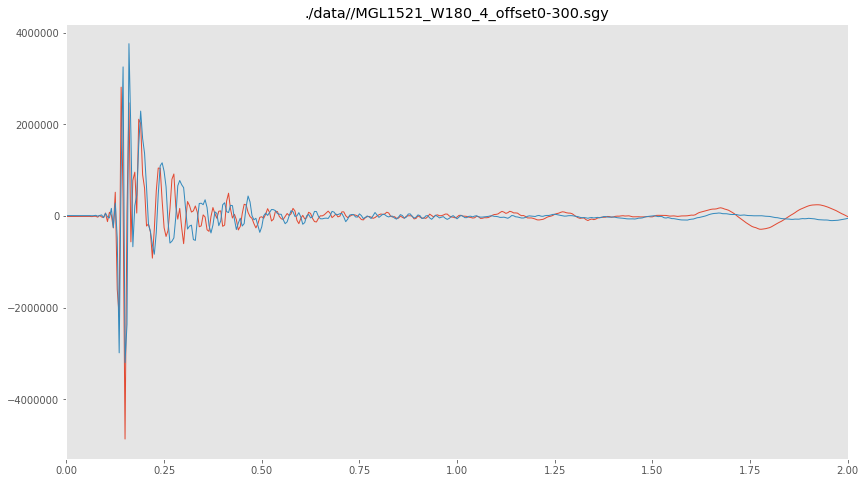

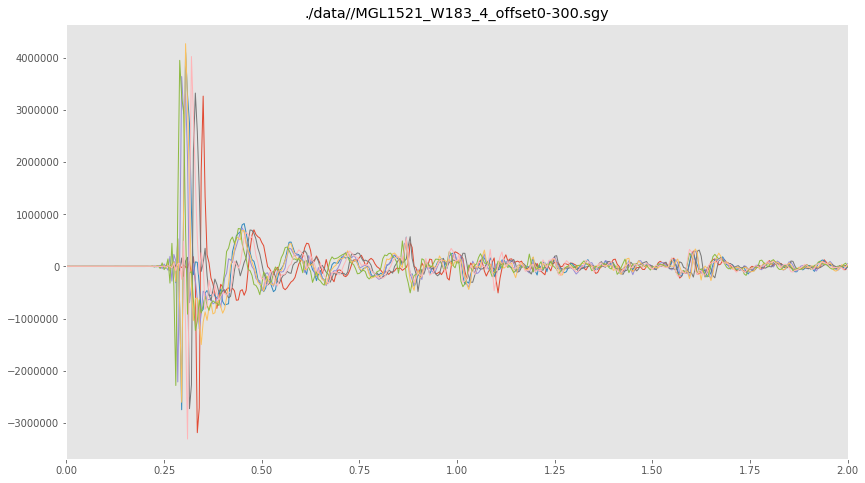

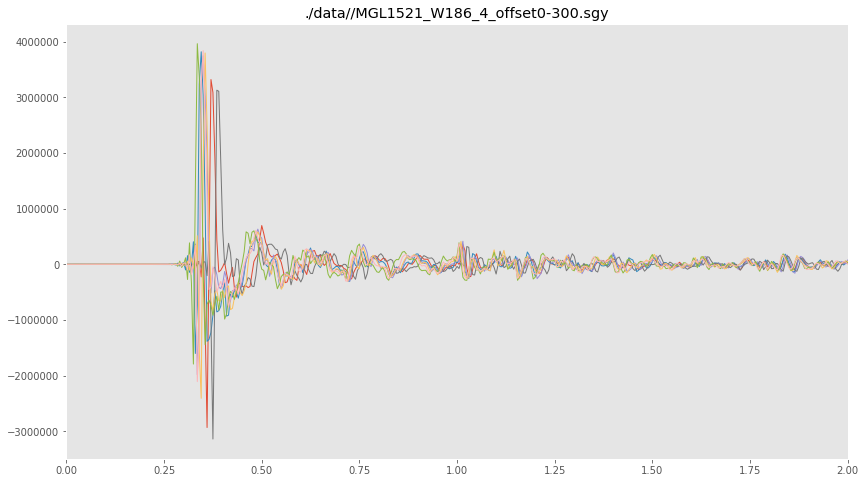

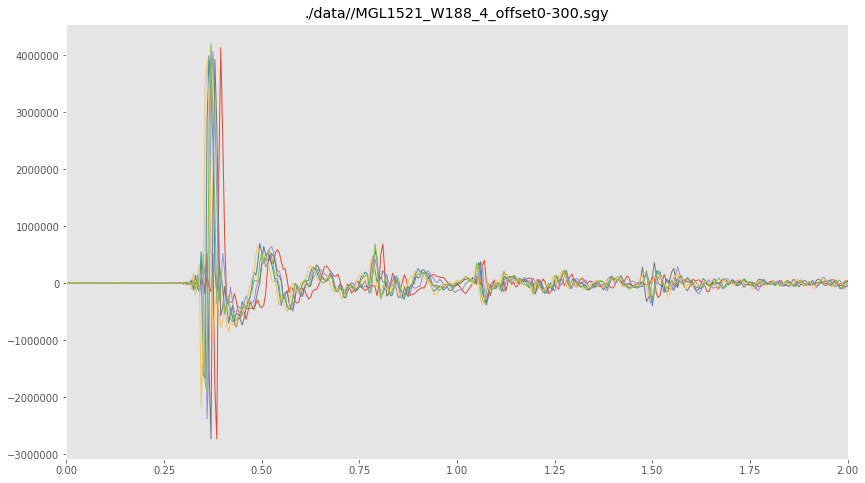

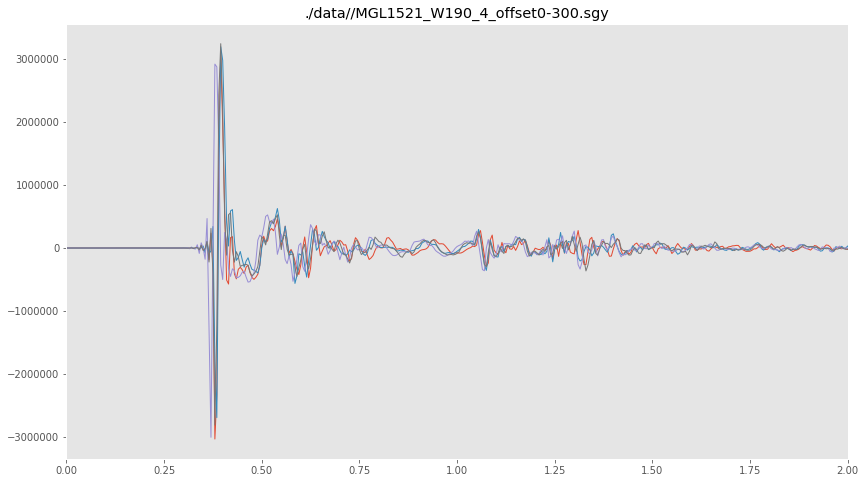

In [41]:
fnames = get_files('./data/', '*'+key+str(vmin)+'-'+str(vmax)+'.sgy')
for fname in fnames:
    plt.figure()
    plt.title(fname)
    plot(fname, ptype='wiggle', dt=dt)
    plt.xlim(0,2)

**Summary**

no data in the offset range

In [42]:
nodata = [115, 117, 121]

mostly ok

In [51]:
ok = [148, 150, 151, 153, 164, 170, 172, 174, 183, 186, 188, 190]

worse

In [45]:
worse = [110, 127, 156]

not all traces

In [46]:
notall = [139, 146, 147]

outliers, different from others

In [47]:
outliers = [180]

Put ok data in a single file.

In [67]:
from fullwavepy.ioapi.su import sgy2su

!ls ./data/*su

for ok_id in ok:
    fnames = get_files('./data/', '*'+str(ok_id)+'*'+key+str(vmin)+'-'+str(vmax)+'.sgy')
    for fname in fnames:
        sgy2su(fname)

!cat ./data/*su | segyhdrs | segywrite tape=./data/ok.sgy

(0.2, 1)

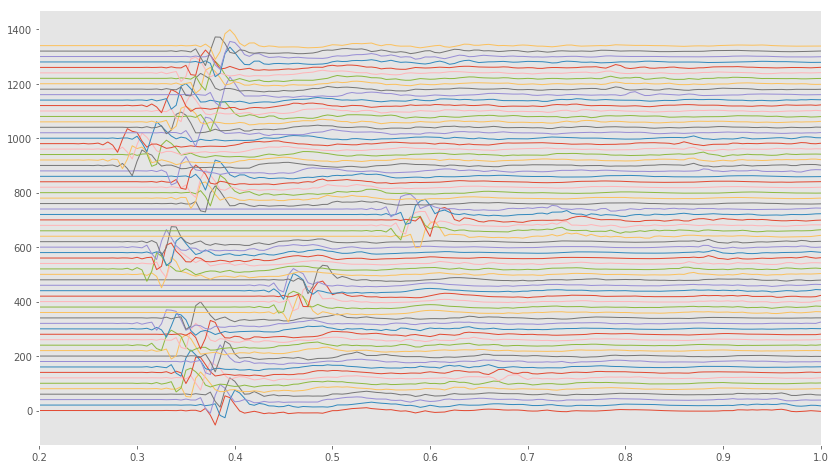

In [72]:
plot('data/ok.sgy', norm='rms', cmap='seismic', ptype='wiggle', dt=dt, gap=20)
plt.xlim(0.2,1)

In [31]:
# from fullwavepy.signalproc.phase import first_breaks, _window_data
A = read_any('data/ok.sgy')
# picks = first_breaks(A)

Get coordinates for future synthetic run.

In [32]:
from fullwavepy.ioapi.su import sugethw
gx = sugethw('data/ok.sgy', 'gx', unique_values=False, int_values=False)
gy = sugethw('data/ok.sgy', 'gy', unique_values=False, int_values=False)
gz = sugethw('data/ok.sgy', 'gelev', unique_values=False, int_values=False)
sx = sugethw('data/ok.sgy', 'sx', unique_values=False, int_values=False)
sy = sugethw('data/ok.sgy', 'sy', unique_values=False, int_values=False)
sz = sugethw('data/ok.sgy', 'sdepth', unique_values=False, int_values=False)
offs = sugethw('data/ok.sgy', 'offset', unique_values=False, int_values=False)
g = list(zip(gx, gy, list(-np.array(gz))))
s = list(zip(sx, sy, sz))

In [56]:
# !sukeyword -o | grep gwdep

Without norm, gap becomes neglible.

In [57]:
# plot(A, cmap='seismic', ptype='wiggle', gap=20, dt=dt)
# plt.xlim(0.2,1)

In [33]:
# gauss_alpha = 80 # GAUSSIAN-WINDOW WIDTH
# Aw = _window_data(A, picks, gauss_alpha=gauss_alpha)
# plot(Aw, cmap='seismic', ptype='wiggle', dt=dt, gap=20, norm='rms')
# plt.xlim(0.2,1)

Align

In [34]:
# Awa = np.zeros(Aw.shape)
# i = 0
# for nx in range(Aw.shape[0]):
#     for ny in range(Aw.shape[1]):
#         pick = int(picks[i][0])
#         tr = Aw[nx][ny]
#         ntr = np.zeros(tr.shape)
#         ntr[ :-pick] = tr[pick: ]
#         Awa[nx][ny] = ntr
#         i += 1

In [179]:
from fullwavepy.signalproc.generic import xcorr
target = A[0][0]
Awa = np.zeros(A.shape) 
for i, data in enumerate(A):
    data = data[0]
    Awa[i][0] = xcorr(data, target)
    
#     print(data[0].shape)

There are some zero traces for some reason... (because there was a bug in xcorr, now solved).

(0.15, 0.4)

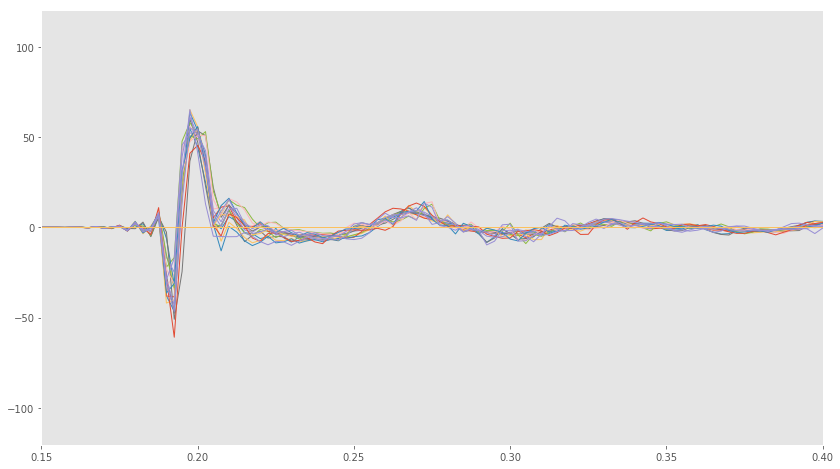

In [181]:
plot(Awa, cmap='seismic', ptype='wiggle', dt=dt, gap=0, norm='rms')
plt.xlim(0.15,.4)

(0, 2)

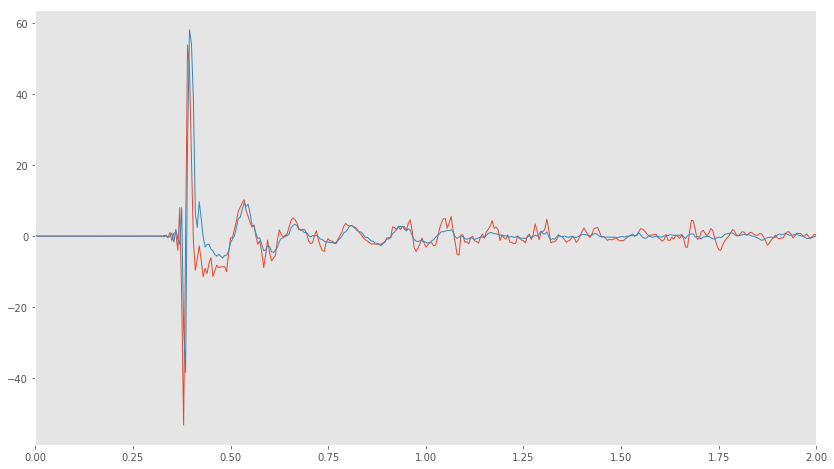

In [188]:
plot(tseries2array(A[0][0]), dt=dt, norm='rms')
dobs = stack(Awa)
plot(dobs, dt=dt, norm='rms')
plt.xlim(0,2)

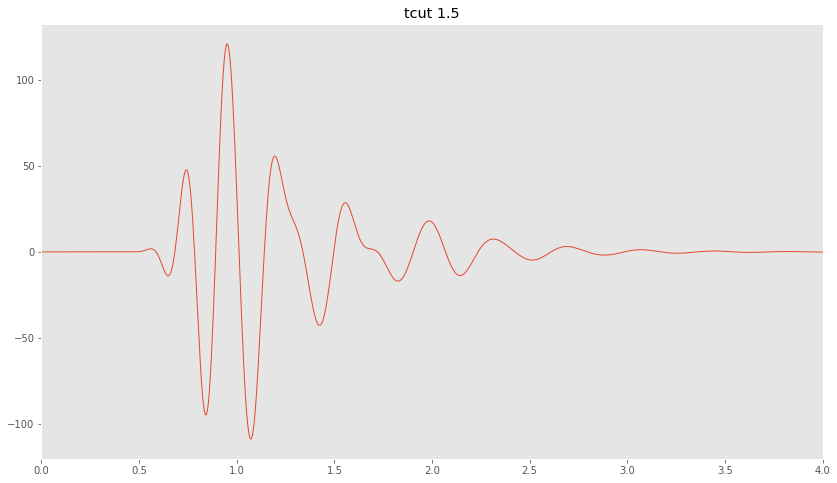

In [203]:
dt = 0.005
f1 = 2
f2 = 3
f3 = 4.5
f4 = 6.5
zerophase = False # !!!!!!!!

kwargs =  {'f1': f1, 'f2': f2, 'f3': f3, 'f4': f4, 'zerophase': zerophase}

# plot(dobs, dt=dt, norm='rms')
for tcut in [1.5]: #[.5,.75,1,1.5,2,3]:
    picks = [tcut]
    dobs_m = su_process(dobs, su_mute, dt, picks, mode='bottom', ntaper=50)
    plt.figure()
    plt.title('tcut ' + str(tcut))    
    
#     plot(dobs_m, dt=dt, norm='rms')

    dobs_mf = su_process(dobs_m, su_filter_full, dt, **kwargs)
    plot(dobs_mf, dt=dt)
    plt.xlim(0,4)        
    

In [205]:
# g

In [207]:
g_tr1, s_tr1 = g[0], s[0]

# ALL IN [m]
pad = 5000
x1 = min(g_tr1[0], s_tr1[0]) - pad
x2 = max(g_tr1[0], s_tr1[0]) + pad
y1 = min(g_tr1[1], s_tr1[1]) - pad
y2 = max(g_tr1[1], s_tr1[1]) + pad
z1 = 0 # CUT AT FS
z2 = 2 * pad
box = [x1, x2, y1, y2, z1, z2]

dt = 0.005   # [s], AS IN RAW DATA
ns = 1000    # [samples]
dx = 50      # [m]
timespace = [box, dx, ns, dt]

In [208]:
proj = ProjSynVsObs('p4', io='fw3d', timespace=timespace)
proj.dims

[201, 206, 201]

In [219]:
from fullwavepy.ioapi.segy import array2sgy
from fullwavepy.ioapi.su import sushw

fname = 'dobs_mf.sgy'
array2sgy(fname, dobs_mf, dt)
# plot('stack2f.sgy', dt=dt)
# plt.xlim(0,5)
# sushw('stack2f.sgy', 'ffid', 2)
# sushw('stack2f.sgy', 'tracf', 3)
# sushw('stack2f.sgy', 'ep', 4)
sushw(fname, 'sx', s_tr1[0])
sushw(fname, 'sy', s_tr1[1])
sushw(fname, 'sdepth', s_tr1[2])
sushw(fname, 'selev', -s_tr1[2])
sushw(fname, 'gx', g_tr1[0])
sushw(fname, 'gy', g_tr1[1])
# sushw('stack2f.sgy', 'gwdep', g_stack2[2])
sushw(fname, 'gelev', -g_tr1[2])
# sushw('stack2f.sgy', 'dt', dt)

# !su_range.sh {fname}


We can't use the same filter because it tapers out the spike first.

In [223]:
# nsamps = dobs_mf.shape[-1]
# spike = np.zeros((1,1,nsamps))
# spike[0,0,0] = 1 # AT TIME ZERO
# # s0 = su_process(spike, su_filter_full, dt, f1=f1, f2=f2, f3=f3, f4=f4, zerophase=zerophase)
# s0 = su_process(spike, su_filter_full, dt, **kwargs)

# plt.title('Initial guess (s0) - spike filtered (minphase, 2-3-4.5-6.5 Hz)')
# plot(s0, dt=dt)
# # plt.xlim(0,5)
# plt.xlabel('time [s]')
# # save_vtr(s0, 's0.vtr')
# # !cp tmp_filt.sgy {proj.inp.wavelet.fname}
# # plot(tmp_filt.sgy)
# plt.ylabel('amplitude (no normaliz.)')

Instead let's move dobs_mf to the time 0.

Index of 1st non-zero amplitude:  58
58


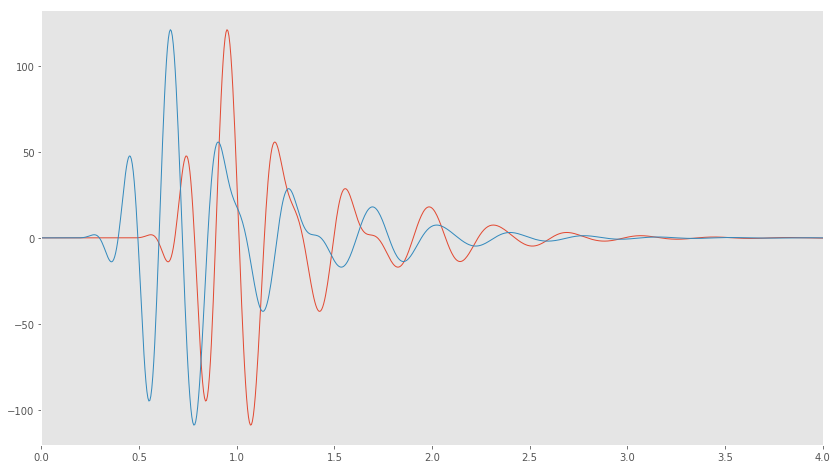

In [234]:
trace =  dobs_mf[0][0]
for i in range(len(trace)):
    if trace[i] > 1e-15:
        print('Index of 1st non-zero amplitude: ', i)
        break
print(i)
dobs_mfa = np.array(dobs_mf)
dobs_mfa[0][0][ :-i] = dobs_mf[0][0][i: ]
plot(dobs_mf, dt=dt)
plot(dobs_mfa, dt=dt)
plt.xlim(0,4)
array2sgy('dobs_mfa.sgy', dobs_mfa, dt)

In [235]:
!cp 'dobs_mfa.sgy' {proj.inp.wavelet.fname}

In [211]:
with open(proj.inp.rawseis.fname, 'w') as f:
    f.write('../../' + fname + '\n')
#     f.write('dobs.sgy\n')
#     f.write('MGL1521_W186_4_single.sgy\n')
#     f.write('MGL1521_W186_4.sgy\n')

In [212]:
proj.vp.true.create(vel=1500)
# proj.vp.true.plot()

In [237]:
proj.inp.sp.create()

{'FFID': 'yes',
 'debug': 'yes',
 'dtms': 5.0,
 'dx': 50,
 'fixed array': 'yes',
 'geometry': 'segy',
 'io': 'fw3d',
 'nx1': 201,
 'nx2': 206,
 'nx3': 201,
 'outseis': 'yes',
 'problem': 'synthetic',
 'reciprocity': 0,
 'retain': 'yes',
 'text': 'yes',
 'ttime': 5000.0,
 'unique': 'yes',
 'x origin': -37376.0,
 'x shift': 0,
 'y origin': -994.0,
 'y shift': 0,
 'z type': 'elevation'}

In [238]:
proj.inp.sp.run()


 SEGYPREP  -  Version 3.16.04                                                     
 ********

 Data preparation for 2D & 3D wavefield tomography

 Project name set to p4
 Preparing files for synthetics...

 Grid points in-line:                    201
 Grid points cross-line:                 206
 Grid points vertically:                 201
 Horiz grid spacing (metres):      50.0000000    
 Vert grid spacing (metres):       50.0000000    
 Model length (metres):            10000.0000    
 Model width (metres):             10250.0000    
 Model depth (metres):             10000.0000    

 Modelling time step (ms):         5.00000000    
 Output data delta-T (ms):         5.00000000    
 Output data length (ms):          5000.00000    
 Output data length (samples):          1000
 Time steps to model:                   1000

 Receiver-array fixed in space:          yes
 Renumber original channel numbers:       no
 Use FFID instead of SOURCE numbers:     yes
 FFID numbers are unique:      

In [239]:
proj.inp.runfile.create()

Content of  ./p4//inp/p4-Runfile.key : 
    ! May 2019, K. Chrapkiewicz 
    ! THIS RUNFILE CONFORMS TO
    ! FULLWAVE REV.688 STANDARD
    ! A. PROBLEM DEFINITION
problem : synthetic
     domain        : time
     dim           : 3D
     equation      : acoustic
     units         : metric
     anisotropy    : none
     kernel        : low
    ! B. MODEL DEFINITON
NX1 : 201
NX2 : 206
NX3 : 201
     DX            : 50.0
    ! X. FREE SURFACE
     ibfs          : 1
     seaLevel      : 0
     maxGhostIter  : 2
     vacuum        : 0
     accuracy      : 0.001
     minGhostFS    : 0.001
     minFictFS     : 0.5
     interpMode    : 1
     srcType       : 0
     recType       : 0
    ! C. DATA DEFINITION
NCOMP : 1
NSHOTS : 1
NRECS : 1
MAXRC : 1
     MAXPS         : 1
io : FW3D
    ! D. BOUNDARY CONDITIONS
btop : 0
bbot : 40
bleft : 40
bright : 40
bfront : 40
bback : 40
extratop : 0
extrabot : 50
extraleft : 50
extraright : 50
extrafront : 50
extraback : 50
    ! F. MUTES & DATA SELECTION


In [240]:
proj.inp.check()

+++++++++++++++ Will only check input files and dump canonical runfile ++++++++++++++++
---=== Starting run (host: ese-kajetan) on 2019/09/19, 15:15:57 ===---
executable: fullwave3D.exe, version: unknown, release date: 2019-09-16
=== scheduler_getprojargs: Project name (command-line argument): "p4"
=== setup_probtype: Equation: "acoustic", Anisotropy: "none", Domain: "time", Kernel: "low"
+++ ReadParms: WARNING, unknown keyword in Runfile: "ibfs"
+++ ReadParms: WARNING, unknown keyword in Runfile: "seaLevel"
+++ ReadParms: WARNING, unknown keyword in Runfile: "maxGhostIter"
+++ ReadParms: WARNING, unknown keyword in Runfile: "vacuum"
+++ ReadParms: WARNING, unknown keyword in Runfile: "accuracy"
+++ ReadParms: WARNING, unknown keyword in Runfile: "minGhostFS"
+++ ReadParms: WARNING, unknown keyword in Runfile: "minFictFS"
+++ ReadParms: WARNING, unknown keyword in Runfile: "interpMode"
+++ ReadParms: WARNING, unknown keyword in Runfile: "srcType"
+++ ReadParms: WARNING, unknown keyword

In [244]:
!cp {proj.inp.path}/{proj.name}'-Observed-Time.ttr' {proj.out.synth.fname}
dsyn = (read_any(proj.out.synth.fname))[0][0]
dobs = (read_any('dobs_mf.sgy'))[0][0]

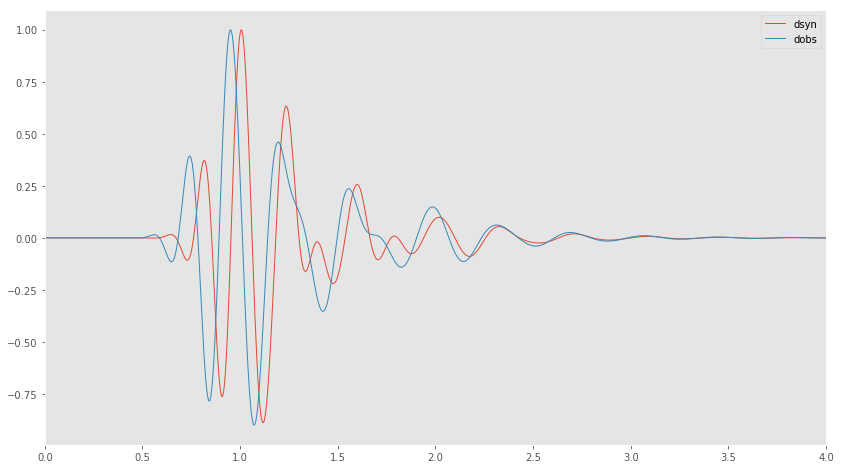

In [249]:
norm = 'max'
plot(tseries2array(dsyn), dt=dt, norm=norm, llabels=['dsyn'])
plot(tseries2array(dobs), dt=dt, norm=norm, llabels=['dobs'])
plt.xlim(0,4)
plt.legend()

In [250]:
s0.shape

(1, 1, 12000)

In [252]:
M = len(dobs)
print(M)
# dsyn = read_any('./synth/inp/synth-Observed-Time.ttr')
# dsyn_p = tpad(dsyn, M)
# plt.plot(dsyn_p)

# s0 = read_any('s0.vtr')
# s0 = s0[0][0]
# s0 = tpad(s0, M)
# plt.plot(s0)

# ZERO-LAG SPIKE
dirac0 = np.zeros(M)
dirac0[0] = 1

# CENTERED SPIKE
dirac = np.zeros(M)
dirac[M//2] = 1

12000


len(shaper) 12000


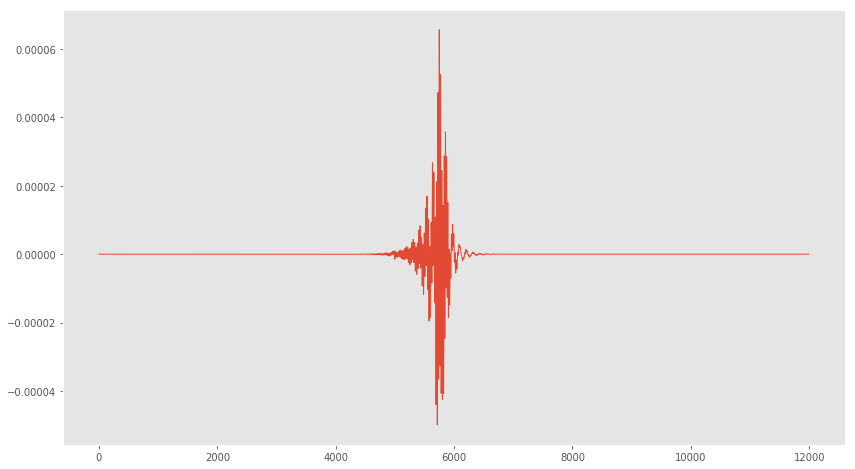

In [253]:
# INVERSE OF DSYN
wiener = su_process(tseries2array(dobs), su_decon, dt, 
                    d_inp=tseries2array(dsyn), 
                    d_out=tseries2array(dirac), 
                    pnoise=.001)

wiener = wiener[0][0]
dsyn_inv = shaper()

# plot(result)
plt.plot(dsyn_inv)

We can check if it produces Dirac. It is not a bad approx., is it? Note smallish amplitude of the spike, is it because of the energy leakage?

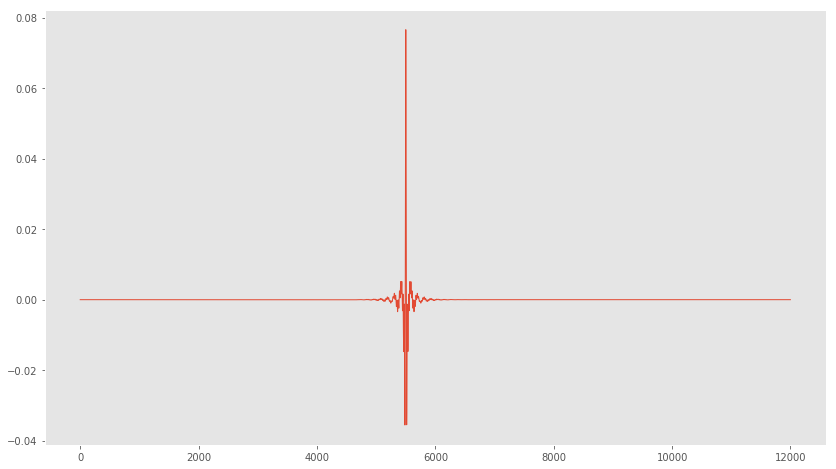

In [254]:
plt.plot(np.convolve(dsyn_inv, dsyn, mode='same'))

Additionally, wiener should produce dobs when convolved with dsyn, let's check this:

(0, 1000)

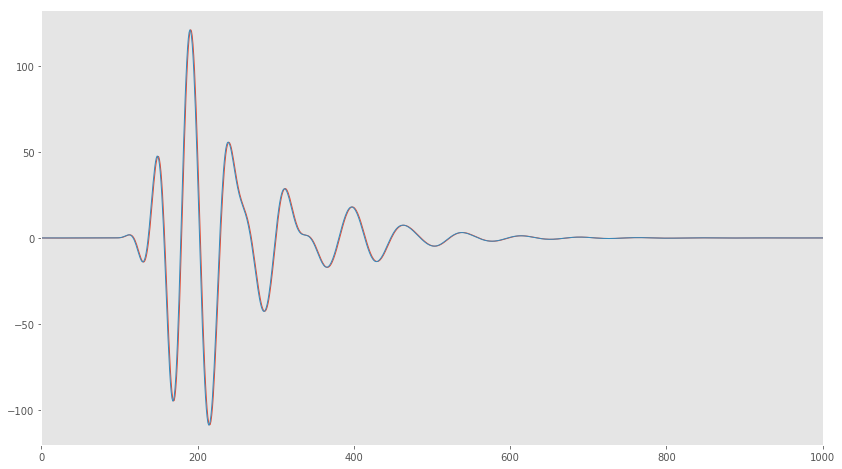

In [255]:
plt.plot(np.convolve(wiener, dsyn, mode='same'))
plt.plot(dobs)
plt.xlim(0,1000)

We are now ready to apply wiener to initiall guess:

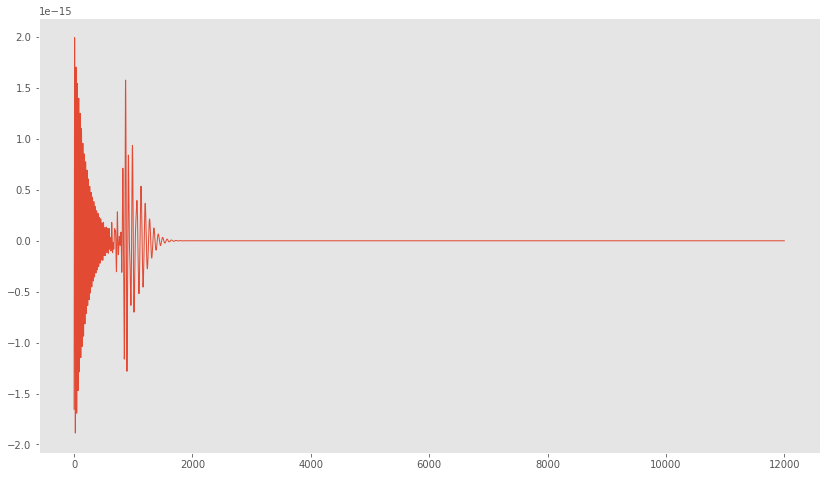

In [266]:
from fullwavepy.ioapi.segy import array2sgy

s0 = read_any(proj.inp.wavelet.fname)
# plot(s0)

s1 = np.convolve(wiener, s0[0][0], mode='same')
plt.plot(s1)
# s1 = np.array(s1[ :dsyn.shape[-1]])
# array2sgy('s1.sgy', tseries2array(s1), dt)
# plot('s1.sgy', norm='max', llabels=['derived wavelet'])
# plot(s0, norm='max', llabels=['initial guess'])
# plt.xlim(0,1200)
# plt.legend()

(0, 0.7)

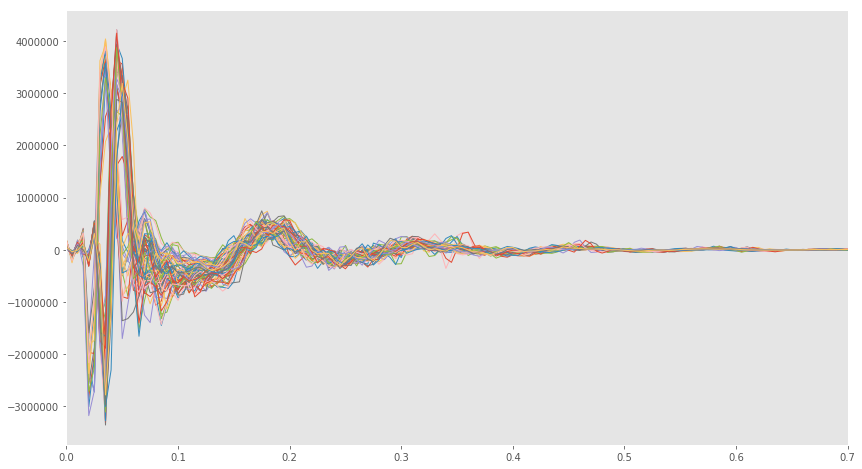

In [52]:
plot(Awa, cmap='seismic', ptype='wiggle', dt=dt, gap=20) #, norm='rms')
plt.xlim(0,.7)

Double-check this clustering!

(0, 20)

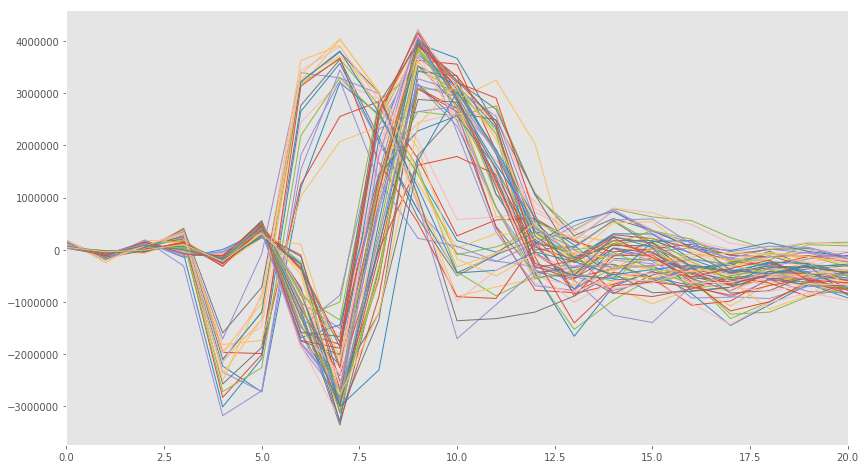

In [59]:
plot(Awa, cmap='seismic', ptype='wiggle', gap=20) #, norm='rms')
plt.xlim(0,20)
# plt.xlim(0,.2)

Split into 2 groups

In [161]:
Awa1, Awa2 = [], []
g1, g2 = [], []
s1, s2 = [], []
i = 0
for nx in range(Awa.shape[0]):
    for ny in range(Awa.shape[1]):
        tr = Awa[nx][ny]
        if tr[4] < -1e6:
            Awa1.append(tr)
            g1.append(g[i])
            s1.append(s[i])
        else:
            Awa2.append(tr)
            g2.append(g[i])
            s2.append(s[i])
        i += 1
awa1 = np.zeros((len(Awa1), 1, len(Awa1[0])))    
awa2 = np.zeros((len(Awa2), 1, len(Awa2[0])))   
awa1[:, 0, :] = Awa1
awa2[:, 0, :] = Awa2

IndexError: list index out of range

(0, 20)

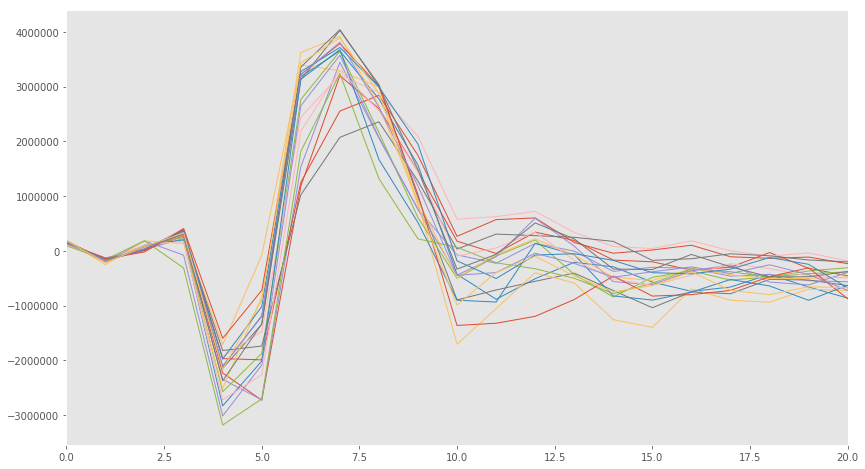

In [72]:
plot(awa1, cmap='seismic', ptype='wiggle', gap=20) #, norm='rms')
plt.xlim(0,20)
# plt.xlim(0,.2)

(0, 20)

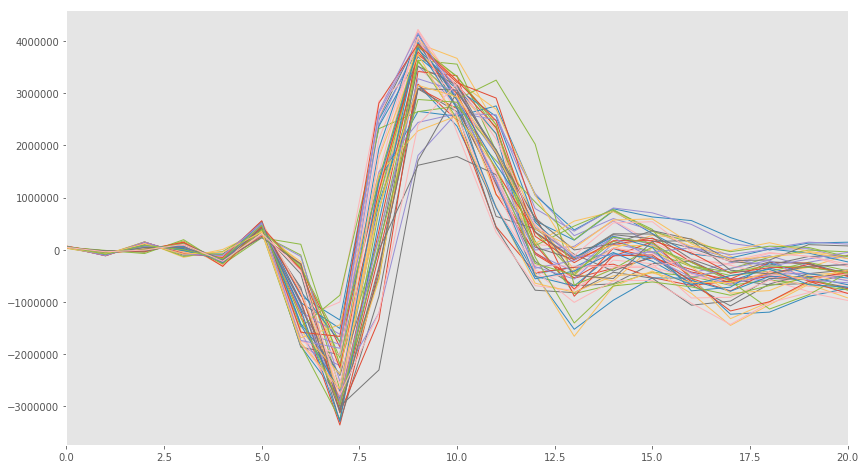

In [73]:
plot(awa2, cmap='seismic', ptype='wiggle', gap=20) #, norm='rms')
plt.xlim(0,20)
# plt.xlim(0,.2)

This low frequency tail due to the bubble is what we want to include.

(0, 100)

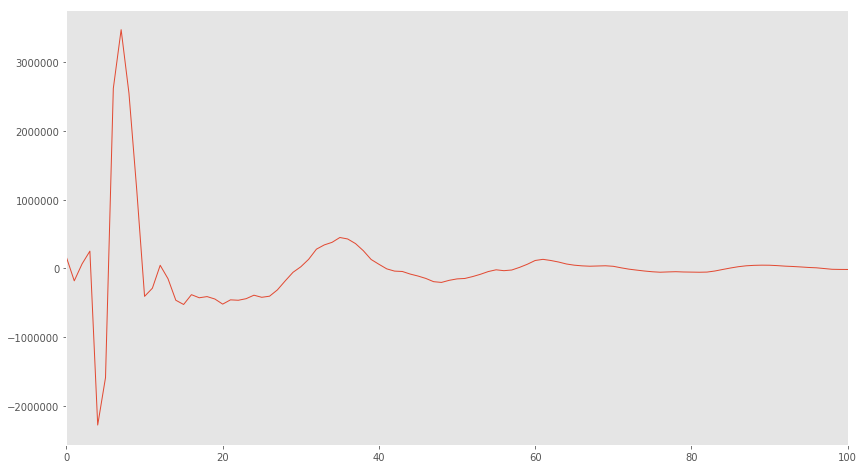

In [83]:
stack1 = stack(awa1)
plot(stack1)
plt.xlim(0,100)

(0, 100)

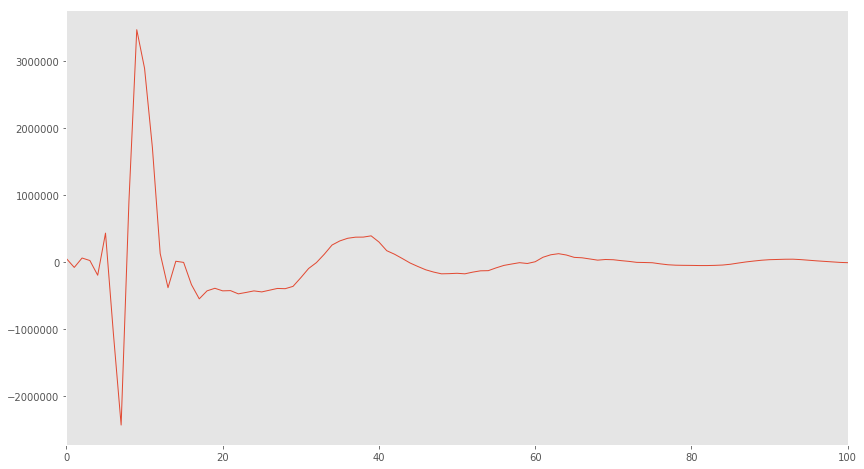

In [87]:
stack2 = stack(awa2)
plot(stack2)
# plt.xlim(0,2)
plt.xlim(0,100)

In [163]:
stack2 = stack(awa2)
plot(stack2, dt=dt)
plt.xlim(0,5)
# plt.xlim(0,100)
plt.title('Desired output of the Wiener filter (dout) - observed traces: stacked (no filter)')
plt.xlabel('time [s]')
plt.ylabel('amplitude (no normaliz.)')

NameError: name 'awa2' is not defined

In [164]:
def mean(v_list):
    vmean = np.zeros(np.array(v_list[0]).shape)
    for v in v_list:
        vmean += np.array(v)
    vmean /= len(v_list)
    return vmean

# average coords
g_stack2 = mean(g2)
s_stack2 = mean(s2)

We will focus on stack2 (more traces).

In [109]:
# no point muting, it's fairly smoothly ->0

# from fullwavepy.signalproc.su import *
# twin_s = 1 # 
# twin_node = twin_s / dt
# ntaper = 2
# stack2m = su_process(stack2, su_mute, dt, [0], mode='both', ntaper=ntaper, twin=twin_node)
# plot(stack2, dt=dt)
# plot(stack2m, dt=dt)
# plt.xlim(0,.2)

In [165]:
stack2f = su_process(stack2, su_filter, dt, f1=f1, f2=f2, f3=f3, f4=f4, zerophase=zerophase)
plt.title('Desired output of the Wiener filter (dout) - observed traces: stacked and filtered (minphase, 2-3-4.5-6.5 Hz)')
plot(stack2f, dt=dt)
# plot(stack2, dt=dt)
plt.xlim(0,5)
plt.xlabel('time [s]')
plt.ylabel('amplitude (no normaliz.)')

NameError: name 'stack2' is not defined

In [ ]:
# testpad

In [ ]:
# stack2fp

Init. guess (filtered spike).

In [166]:
nsamps = stack2f.shape[-1]
spike = np.zeros((1,1,nsamps))
spike[0,0,0] = 1 # AT TIME ZERO
s0 = su_process(spike, su_filter, dt, f1=f1, f2=f2, f3=f3, f4=f4, zerophase=zerophase)
plt.title('Initial guess (s0) - spike filtered (minphase, 2-3-4.5-6.5 Hz)')
plot(s0, dt=dt)
plt.xlim(0,5)
plt.xlabel('time [s]')
# save_vtr(s0, 's0.vtr')
# !cp tmp_filt.sgy {proj.inp.wavelet.fname}
# plot(tmp_filt.sgy)
plt.ylabel('amplitude (no normaliz.)')

NameError: name 'stack2f' is not defined

In [167]:
# ALL IN [m]
pad = 5000
x1 = min(g_stack2[0], s_stack2[0]) - pad
x2 = max(g_stack2[0], s_stack2[0]) + pad
y1 = min(g_stack2[1], s_stack2[1]) - pad
y2 = max(g_stack2[1], s_stack2[1]) + pad
z1 = 0 # CUT AT FS
z2 = 2 * pad
box = [x1, x2, y1, y2, z1, z2]

dt = 0.005   # [s], AS IN RAW DATA
ns = 1000    # [samples]
dx = 50      # [m]
timespace = [box, dx, ns, dt]

In [168]:
proj = ProjSynVsObs('p1', io='fw3d', timespace=timespace)
proj.dims

[201, 202, 201]

In [257]:
g_stack2

array([-16990.        ,   1075.40816327,    565.87755102])

In [258]:
s_stack2

array([-1.69729184e+04,  1.17257143e+03,  1.20000000e+01])

In [256]:
box

[-21990.0,
 -11972.918367346938,
 -3924.591836734694,
 6172.571428571428,
 0,
 10000]

In [238]:
s_stack2

array([-1.69729184e+04,  1.17257143e+03,  1.20000000e+01])

In [288]:
!sukeyword -o

cat: '+/tracl;': No such file or directory
/* Copyright (c) Colorado School of Mines, 2011.*/
/* All rights reserved.                       */

/* segy.h - include file for SEGY traces
 *
 * declarations for:
 *	typedef struct {} segy - the trace identification header
 *	typedef struct {} bhed - binary header
 *
 * Note:
 *	If header words are added, run the makefile in this directory
 *	to recreate hdr.h.
 *
 * Reference:
 *	K. M. Barry, D. A. Cavers and C. W. Kneale, "Special Report:
 *		Recommended Standards for Digital Tape Formats",
 *		Geophysics, vol. 40, no. 2 (April 1975), P. 344-352.
 *	
 * $Author: john $
 * $Source: /usr/local/cwp/src/su/include/RCS/segy.h,v $
 * $Revision: 1.33 $ ; $Date: 2011/11/11 23:56:14 $
 */ 

#include <limits.h>

#ifndef SEGY_H
#define SEGY_H

#define SU_NFLTS	65535   /*   Arbitrary limit on data array size	*/
/* #define SU_NFLTS	32767	 Arbitrary limit on data array size	*/


/* TYPEDEFS */
typedef struct {	/* segy - trace identification header */



In [294]:
# !su_range.sh dobs.sgy

In [313]:
from fullwavepy.ioapi.segy import array2sgy
from fullwavepy.ioapi.su import sushw
array2sgy('stack2f.sgy', stack2f, dt)
# plot('stack2f.sgy', dt=dt)
# plt.xlim(0,5)
# sushw('stack2f.sgy', 'ffid', 2)
# sushw('stack2f.sgy', 'tracf', 3)
# sushw('stack2f.sgy', 'ep', 4)
sushw('stack2f.sgy', 'sx', s_stack2[0])
sushw('stack2f.sgy', 'sy', s_stack2[1])
sushw('stack2f.sgy', 'sdepth', s_stack2[2])
sushw('stack2f.sgy', 'selev', -s_stack2[2])
sushw('stack2f.sgy', 'gx', g_stack2[0])
sushw('stack2f.sgy', 'gy', g_stack2[1])
sushw('stack2f.sgy', 'gwdep', g_stack2[2])
sushw('stack2f.sgy', 'gelev', -g_stack2[2])
# sushw('stack2f.sgy', 'dt', dt)

!su_range.sh 'stack2f.sgy'



su_range.sh: START

3200+0 records in
6+1 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.00179551 s, 1.8 MB/s
1 traces:
tracl    1
tracr    1
fldr     1
tracf    1
ep       1
cdp      1
cdpt     1
trid     1
nvs      1
nhs      1
duse     1
gelev    -565
selev    -12
sdepth   12
gwdep    565
scalel   1
scalco   1
sx       -16972
sy       1172
gx       -16990
gy       1075
counit   1
ns       12000
dt       5000
gain     3

Shot coordinate limits:
	North(-16972,1172) South(-16972,1172) East(-16972,1172) West(-16972,1172)

Receiver coordinate limits:
	North(-16990,1075) South(-16990,1075) East(-16990,1075) West(-16990,1075)

Midpoint coordinate limits:
	North(-16981,1123.5) South(-16981,1123.5) East(-16981,1123.5) West(-16981,1123.5)

su_range.sh: END
Runtime of the su_range.sh: 0 s


In [307]:
with open(proj.inp.rawseis.fname, 'w') as f:
    f.write('../../stack2f.sgy\n')
#     f.write('dobs.sgy\n')
#     f.write('MGL1521_W186_4_single.sgy\n')
#     f.write('MGL1521_W186_4.sgy\n')

In [252]:
proj.vp.true.create(vel=1500)
# proj.vp.true.plot()

In [320]:
proj.inp.sp.create()

{'FFID': 'yes',
 'debug': 'yes',
 'dtms': 5.0,
 'dx': 50,
 'fixed array': 'yes',
 'geometry': 'segy',
 'io': 'fw3d',
 'nx1': 201,
 'nx2': 202,
 'nx3': 201,
 'outseis': 'yes',
 'problem': 'synthetic',
 'reciprocity': 0,
 'retain': 'yes',
 'text': 'yes',
 'ttime': 5000.0,
 'unique': 'yes',
 'x origin': -21990.0,
 'x shift': 0,
 'y origin': -3924.591836734694,
 'y shift': 0,
 'z type': 'elevation'}

In [321]:
proj.inp.sp.run()


 SEGYPREP  -  Version 3.16.04                                                     
 ********

 Data preparation for 2D & 3D wavefield tomography

 Project name set to p1
 Preparing files for synthetics...

 Grid points in-line:                    201
 Grid points cross-line:                 202
 Grid points vertically:                 201
 Horiz grid spacing (metres):      50.0000000    
 Vert grid spacing (metres):       50.0000000    
 Model length (metres):            10000.0000    
 Model width (metres):             10050.0000    
 Model depth (metres):             10000.0000    

 Modelling time step (ms):         5.00000000    
 Output data delta-T (ms):         5.00000000    
 Output data length (ms):          5000.00000    
 Output data length (samples):          1000
 Time steps to model:                   1000

 Receiver-array fixed in space:          yes
 Renumber original channel numbers:       no
 Use FFID instead of SOURCE numbers:     yes
 FFID numbers are unique:      

In [322]:
proj.inp.runfile.create()

Content of  ./p1//inp/p1-Runfile.key : 
    ! May 2019, K. Chrapkiewicz 
    ! THIS RUNFILE CONFORMS TO
    ! FULLWAVE REV.688 STANDARD
    ! A. PROBLEM DEFINITION
problem : synthetic
     domain        : time
     dim           : 3D
     equation      : acoustic
     units         : metric
     anisotropy    : none
     kernel        : low
    ! B. MODEL DEFINITON
NX1 : 201
NX2 : 202
NX3 : 201
     DX            : 50.0
    ! X. FREE SURFACE
     ibfs          : 1
     seaLevel      : 0
     maxGhostIter  : 2
     vacuum        : 0
     accuracy      : 0.001
     minGhostFS    : 0.001
     minFictFS     : 0.5
     interpMode    : 1
     srcType       : 0
     recType       : 0
    ! C. DATA DEFINITION
NCOMP : 1
NSHOTS : 1
NRECS : 1
MAXRC : 1
     MAXPS         : 1
io : FW3D
    ! D. BOUNDARY CONDITIONS
btop : 0
bbot : 40
bleft : 40
bright : 40
bfront : 40
bback : 40
extratop : 0
extrabot : 50
extraleft : 50
extraright : 50
extrafront : 50
extraback : 50
    ! F. MUTES & DATA SELECTION


In [323]:
proj.inp.check()

+++++++++++++++ Will only check input files and dump canonical runfile ++++++++++++++++
---=== Starting run (host: ese-kajetan) on 2019/09/16, 13:17:31 ===---
executable: fullwave3D.exe, version: unknown, release date: 2019-09-12
=== scheduler_getprojargs: Project name (command-line argument): "p1"
=== setup_probtype: Equation: "acoustic", Anisotropy: "none", Domain: "time", Kernel: "low"
+++ ReadParms: WARNING, unknown keyword in Runfile: "ibfs"
+++ ReadParms: WARNING, unknown keyword in Runfile: "seaLevel"
+++ ReadParms: WARNING, unknown keyword in Runfile: "maxGhostIter"
+++ ReadParms: WARNING, unknown keyword in Runfile: "vacuum"
+++ ReadParms: WARNING, unknown keyword in Runfile: "accuracy"
+++ ReadParms: WARNING, unknown keyword in Runfile: "minGhostFS"
+++ ReadParms: WARNING, unknown keyword in Runfile: "minFictFS"
+++ ReadParms: WARNING, unknown keyword in Runfile: "interpMode"
+++ ReadParms: WARNING, unknown keyword in Runfile: "srcType"
+++ ReadParms: WARNING, unknown keyword

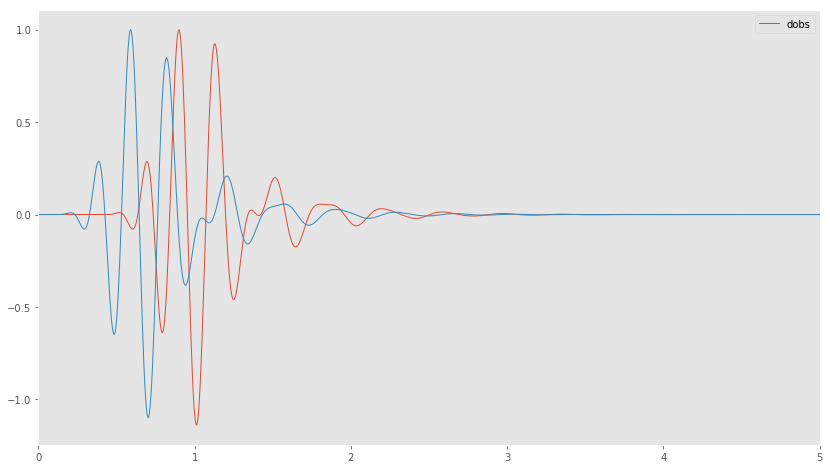

In [357]:
# !mv p1/inp/p1-Observed-Time.ttr {proj.out.synth.fname}
proj.out.synth.plot(norm='max', dt=dt)
plot('stack2f.sgy', norm='max', dt=dt, llabels=['dobs'])
plt.xlim(0,5)
plt.legend()

Obviously synthetic comes later because we aligned dobs at first breaks!

In [31]:
dsyn = (read_any(proj.out.synth.fname))[0][0]
dobs = (read_any('stack2f.sgy'))[0][0]

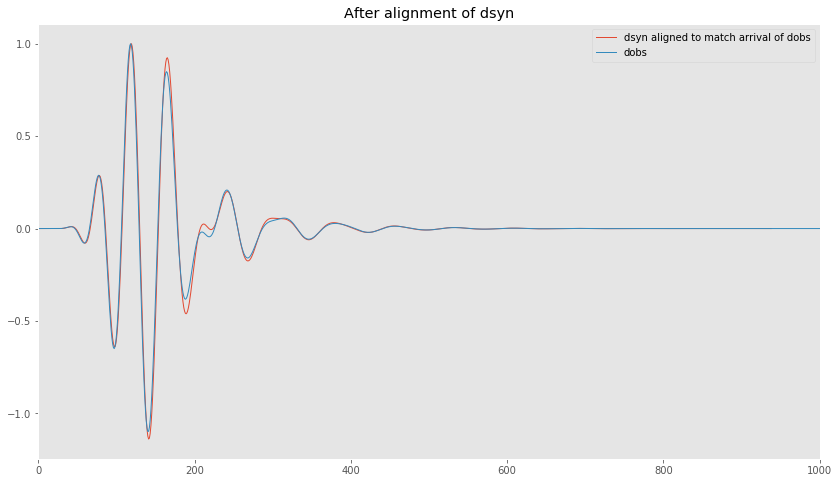

In [32]:
from fullwavepy.signalproc.generic import xcorr
dsyna = xcorr(dsyn, dobs)
norm='max'
plt.title('After alignment of dsyn')
plot(tseries2array(dsyna), norm=norm, llabels=['dsyn aligned to match arrival of dobs'])
plot(tseries2array(dobs), norm=norm, llabels=['dobs'])
plt.xlim(0,1000)
plt.legend()

In [373]:
s0.shape

(1, 1, 1000)

In [36]:
# s1 = su_process(s0, su_decon, dt, 
#                     d_inp=tseries2array(dsyna), 
#                     d_out=tseries2array(dobs), 
#                     pnoise=.001)

12000


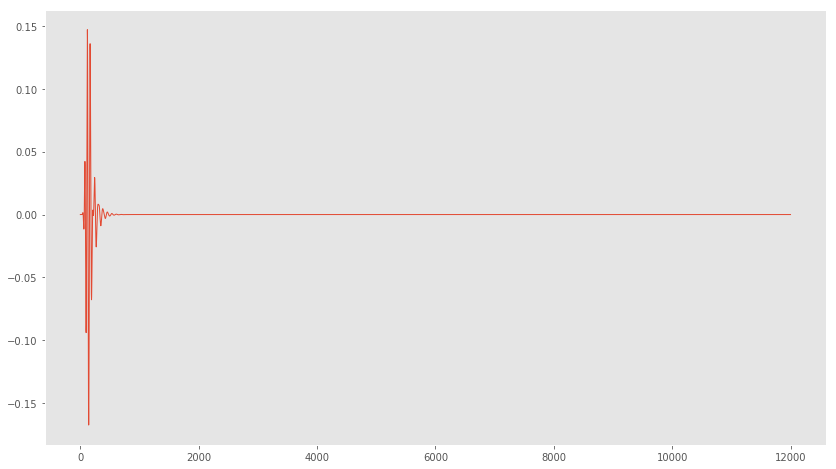

In [142]:
M = len(dobs)
print(M)
# dsyn = read_any('./synth/inp/synth-Observed-Time.ttr')
dsyna = tpad(dsyna, M)
plt.plot(dsyna)

# s0 = read_any('s0.vtr')
# s0 = s0[0][0]
# s0 = tpad(s0, M)
# plt.plot(s0)

# ZERO-LAG SPIKE
dirac0 = np.zeros(M)
dirac0[0] = 1

# CENTERED SPIKE
dirac = np.zeros(M)
dirac[M//2] = 1

len(shaper) 12000


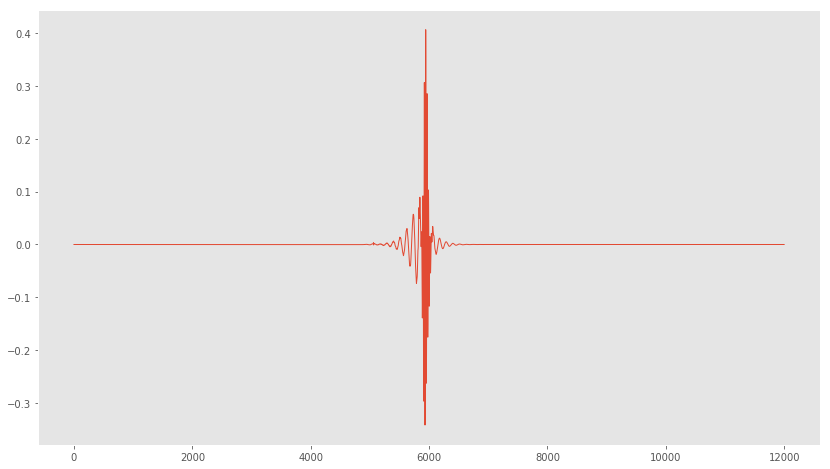

In [143]:
# INVERSE OF DSYN
wiener = su_process(tseries2array(dobs), su_decon, dt, 
                    d_inp=tseries2array(dsyna), 
                    d_out=tseries2array(dirac), 
                    pnoise=.001)

wiener = wiener[0][0]
dsyna_inv = shaper()

# plot(result)
plt.plot(dsyna_inv)

We can check if it produces Dirac. It is not a bad approx., is it? Note smallish amplitude of the spike, is it because of the energy leakage?

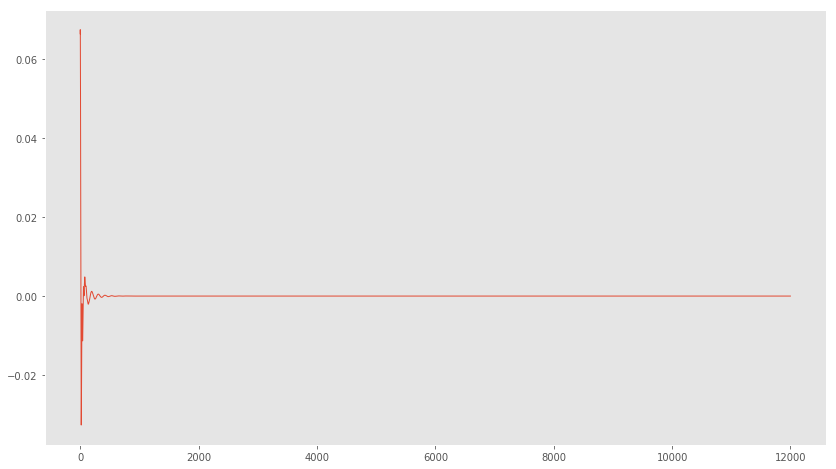

In [144]:
plt.plot(np.convolve(dsyna_inv, dsyna, mode='same'))

Additionally, wiener should produce dobs when convolved with dsyn, let's check this:

(0, 1000)

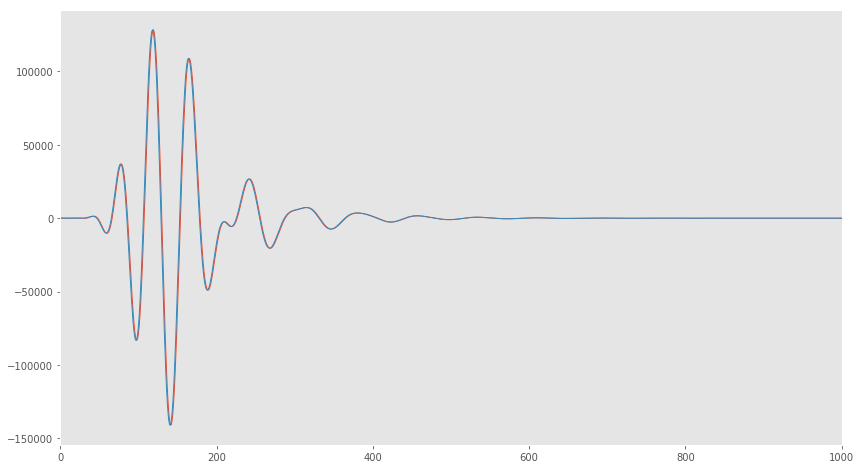

In [145]:
plt.plot(np.convolve(wiener, dsyna, mode='same'))
plt.plot(dobs)
plt.xlim(0,1000)

We are now ready to apply wiener to initiall guess:

1000

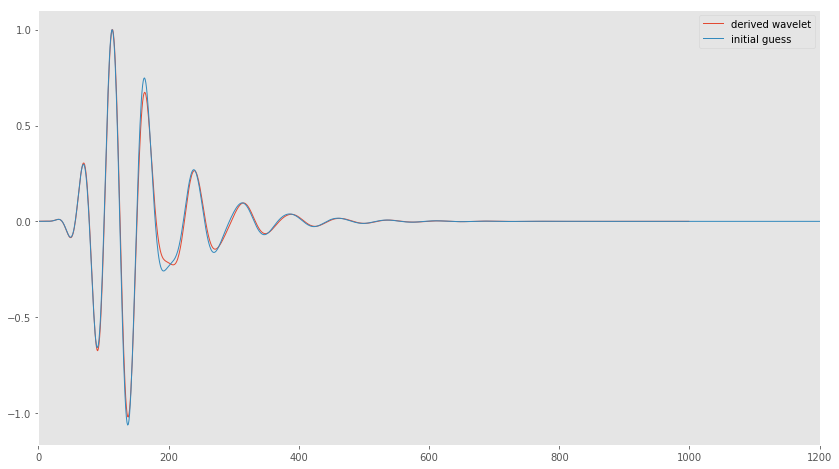

In [175]:
from fullwavepy.ioapi.segy import array2sgy

s1 = np.convolve(wiener, s0[0][0], mode='same')


s1 = np.array(s1[ :dsyn.shape[-1]])
array2sgy('s1.sgy', tseries2array(s1), dt)
plot('s1.sgy', norm='max', llabels=['derived wavelet'])
plot(s0, norm='max', llabels=['initial guess'])
plt.xlim(0,1200)
plt.legend()

In [170]:
# ALL IN [m]
pad = 5000
x1 = min(g_stack2[0], s_stack2[0]) - pad
x2 = max(g_stack2[0], s_stack2[0]) + pad
y1 = min(g_stack2[1], s_stack2[1]) - pad
y2 = max(g_stack2[1], s_stack2[1]) + pad
z1 = 0 # CUT AT FS
z2 = 2 * pad
box = [x1, x2, y1, y2, z1, z2]

dt = 0.005   # [s], AS IN RAW DATA
ns = 1000    # [samples]
dx = 50      # [m]
timespace = [box, dx, ns, dt]

In [37]:
proj = ProjSynVsObs('p2', io='fw3d', info='Rerun synthetics', timespace=timespace)
proj.dims

[2401, 401, 131]

In [182]:
!cp 'p1/inp/p1-TrueVp.vtr' {proj.vp.true.fname}
!cp 'p1/inp/p1-SegyPrep.key' {proj.inp.sp.fname}
!cp 'p1/inp/p1-RawSeis.txt' {proj.inp.rawseis.fname}
proj.inp.wavelet.prepare(source='s1.sgy')
proj.inp.sp.run()
proj.inp.runfile.create()


 SEGYPREP  -  Version 3.16.04                                                     
 ********

 Data preparation for 2D & 3D wavefield tomography

 Project name set to p2
 Preparing files for synthetics...

 Grid points in-line:                    201
 Grid points cross-line:                 202
 Grid points vertically:                 201
 Horiz grid spacing (metres):      50.0000000    
 Vert grid spacing (metres):       50.0000000    
 Model length (metres):            10000.0000    
 Model width (metres):             10050.0000    
 Model depth (metres):             10000.0000    

 Modelling time step (ms):         5.00000000    
 Output data delta-T (ms):         5.00000000    
 Output data length (ms):          5000.00000    
 Output data length (samples):          1000
 Time steps to model:                   1000

 Receiver-array fixed in space:          yes
 Renumber original channel numbers:       no
 Use FFID instead of SOURCE numbers:     yes
 FFID numbers are unique:      

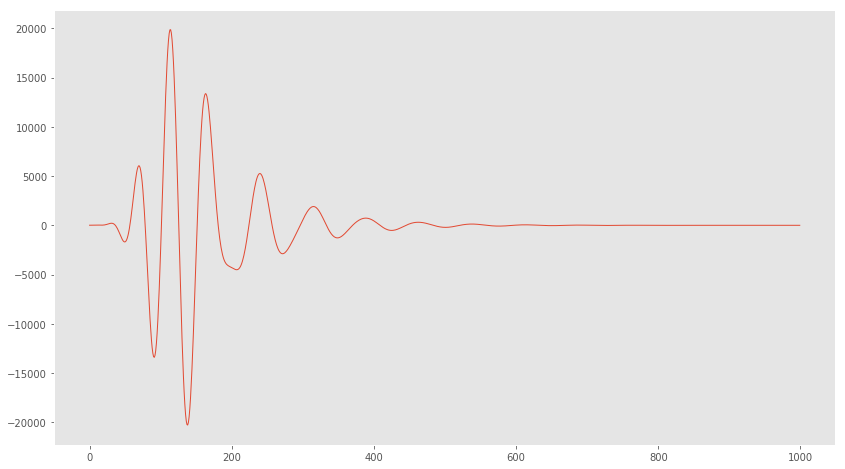

In [177]:
proj.inp.wavelet.plot()

In [183]:
proj.inp.check()

+++++++++++++++ Will only check input files and dump canonical runfile ++++++++++++++++
---=== Starting run (host: ese-kajetan) on 2019/09/16, 15:00:25 ===---
executable: fullwave3D.exe, version: unknown, release date: 2019-09-16
=== scheduler_getprojargs: Project name (command-line argument): "p2"
=== setup_probtype: Equation: "acoustic", Anisotropy: "none", Domain: "time", Kernel: "low"
+++ ReadParms: WARNING, unknown keyword in Runfile: "ibfs"
+++ ReadParms: WARNING, unknown keyword in Runfile: "seaLevel"
+++ ReadParms: WARNING, unknown keyword in Runfile: "maxGhostIter"
+++ ReadParms: WARNING, unknown keyword in Runfile: "vacuum"
+++ ReadParms: WARNING, unknown keyword in Runfile: "accuracy"
+++ ReadParms: WARNING, unknown keyword in Runfile: "minGhostFS"
+++ ReadParms: WARNING, unknown keyword in Runfile: "minFictFS"
+++ ReadParms: WARNING, unknown keyword in Runfile: "interpMode"
+++ ReadParms: WARNING, unknown keyword in Runfile: "srcType"
+++ ReadParms: WARNING, unknown keyword

(0, 1000)

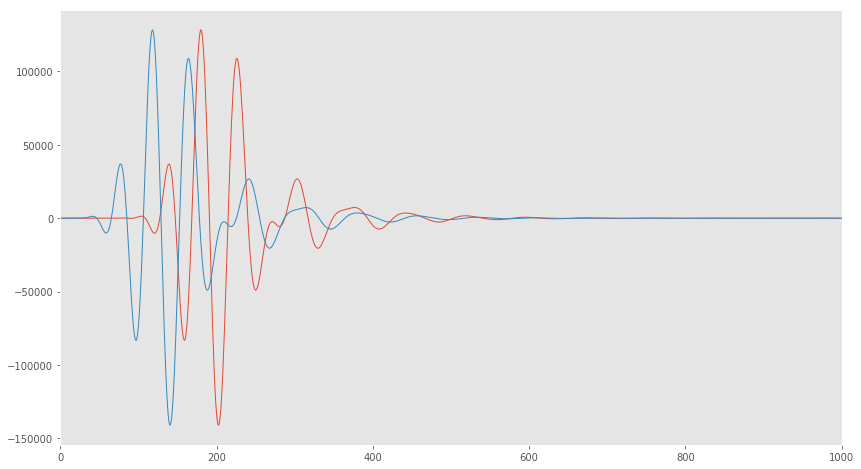

In [189]:
!cp p2/inp/p2-Observed-Time.ttr {proj.out.synth.fname}
proj.out.synth.plot()
plot(tseries2array(dobs))
plt.xlim(0,1000)

In [193]:
dsyn2 = read_any(proj.out.synth.fname)
dsyn2a = xcorr(dsyn2[0][0], dobs)

(0, 700)

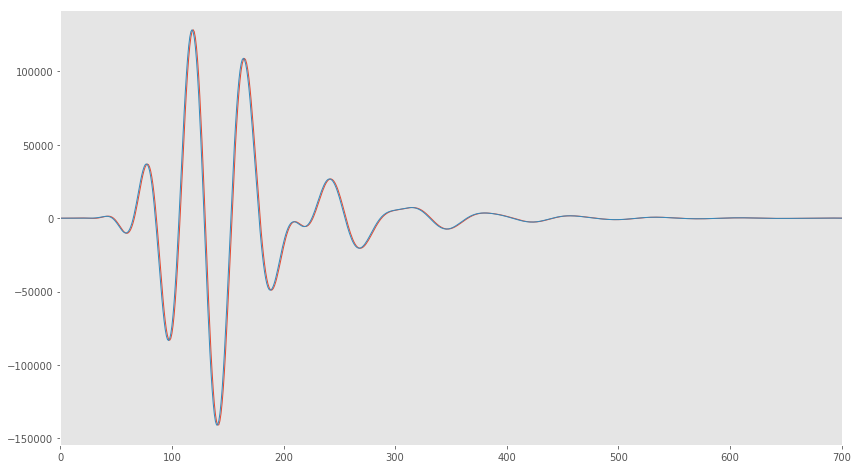

In [199]:
plot(tseries2array(dsyn2a), tseries2array(dobs))
plt.xlim(0,700)

I moved to sant_chri

In [172]:
dt = 0.0025  # CHRISTIANA
ns = 2000    
dx = 50      
x1 = -3e4     
x2 = -1e4    
y1 = -2e3    
y2 = 5e3    
z1 = 0 # CUT AT THE SEA SURFACE
z2 = 3000    
box = [x1, x2, y1, y2, z1, z2]
timespace = [box, dx, ns, dt]

In [173]:
proj = ProjSynVsObs('p3', io='sgy', projinfo='Generate synth dataset', timespace=timespace)
proj.dims

[401, 141, 61]

In [51]:
# proj.geom._read_all_coords()

In [228]:
path = '/media/kmc3817/DATADRIVE1/heavy_PhD/DATA/Santorini_2015/seismic/OBS/segy_local_coords/'
fnames = get_files(path, 'MGL1521_?16*_4.sgy')
fnames += get_files(path, 'MGL1521_?18*_4.sgy')
fnames += get_files(path, 'MGL1521_?19*_4.sgy')

with open(proj.inp.rawseis.fname, 'w') as f:
    for fname in fnames:
        f.write(fname + '\n')
# proj.inp.rawseis.cat()        

In [218]:
proj.inp.wavelet.prepare(source='s1.sgy')

In [222]:
# proj.inp.wavelet.plot()

In [217]:
!cp /home/kmc3817/rds_home/PhD/PROJECTS/fwi_sant_kolumbo/p5/inp/p5-TrueVp.sgy {proj.vp.true.fname}

In [223]:
!cp /home/kmc3817/rds_home/PhD/PROJECTS/fwi_sant_kolumbo/p5/inp/p5-SegyPrep.key {proj.inp.sp.fname}

# *Simplified example (explicit)

Convolution instead of synthetic run.

In [1502]:
mode = 'same' # OF CONVOLUTION

## dobs

Let's define a Green's function. Convolving with it will replace the synthetic run.

In [1503]:
M = 12000
G = np.zeros(M)

case = 1
if case == 1:
    G[M//2] = 1
elif case == 2:
    from scipy.signal import sawtooth
    G = np.arange(M)
    G = sawtooth(2 * np.pi * G / 500)
    
elif case == 3:
    G[2000] = 1
    G[2500] = -4
# plt.plot(G)

A true wavelet. This one is just a wavelet derived in some previous steps.

In [1504]:
S = read_any('S.vtr')
S = S[0][0]
S /= np.max(S) 
# plt.plot(S)

Observed data.

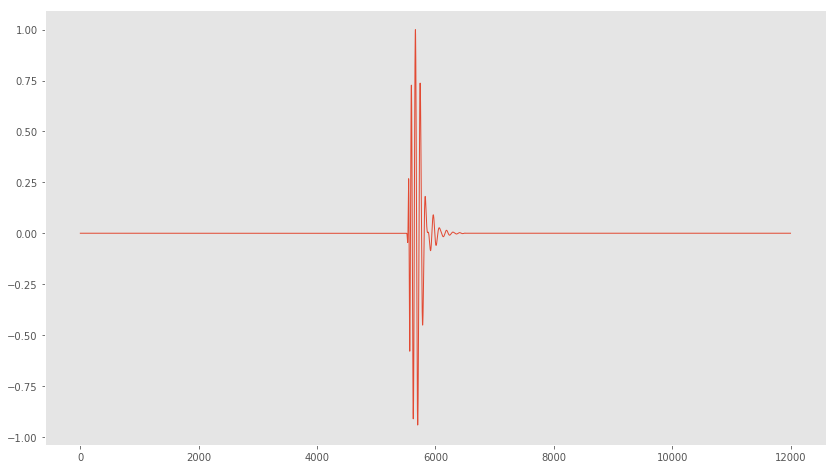

In [1505]:
DOBS = np.convolve(S, G, mode=mode)
plt.plot(DOBS)

## dsyn

Initial-guess wavelet. This is a filtered spike prepared elsewhere.

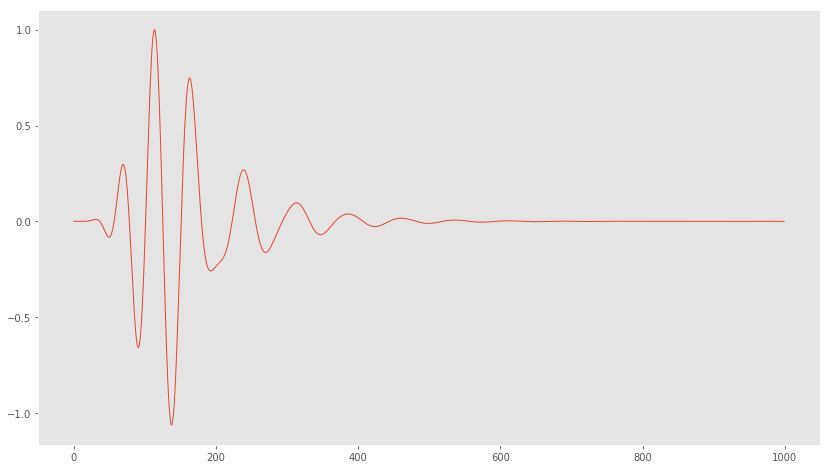

In [1506]:
S0 = read_any('S0.vtr')
S0 = S0[0][0]
S0 /= np.max(S0)
plt.plot(S0)

Generate synthetics.

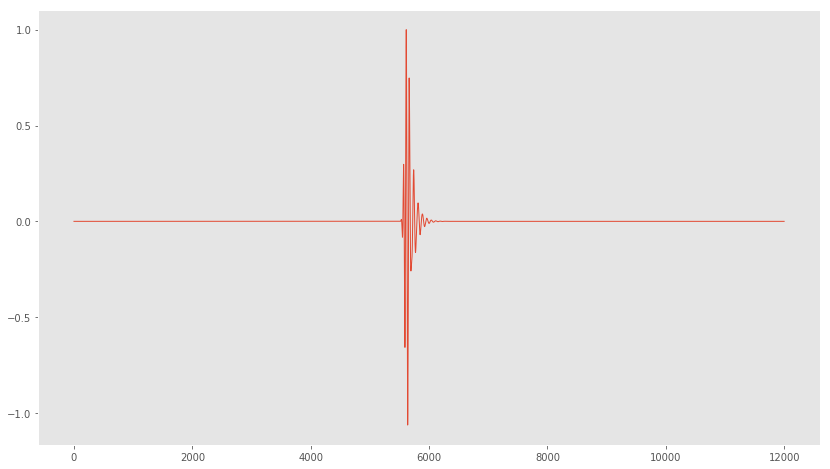

In [1507]:
DSYN = np.convolve(S0, G, mode=mode)
plt.plot(DSYN)
# plt.plot(DOBS)

## decon

len(shaper) 12000


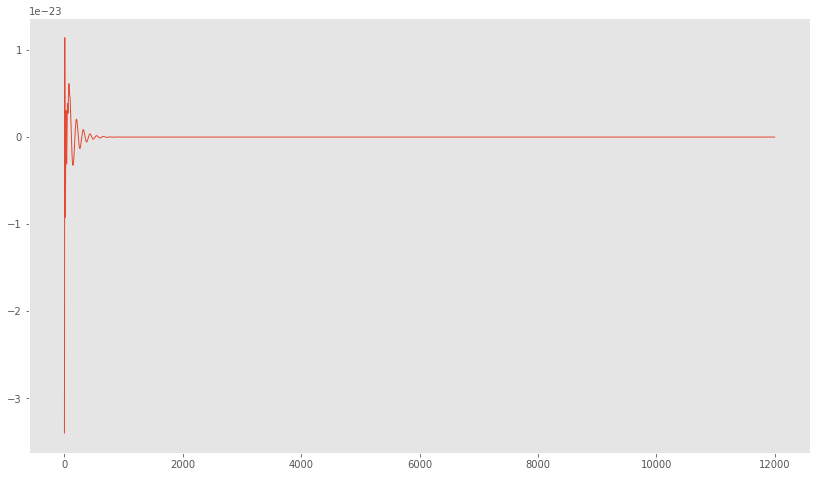

In [1508]:
pnoise = 1e-5

S1 = su_process(tseries2array(S0), su_decon, proj.dt, 
                d_inp=tseries2array(DSYN), 
                d_out=tseries2array(DOBS), 
                pnoise=pnoise)
S1 = S1[0][0]
# plt.plot(S1)

## check

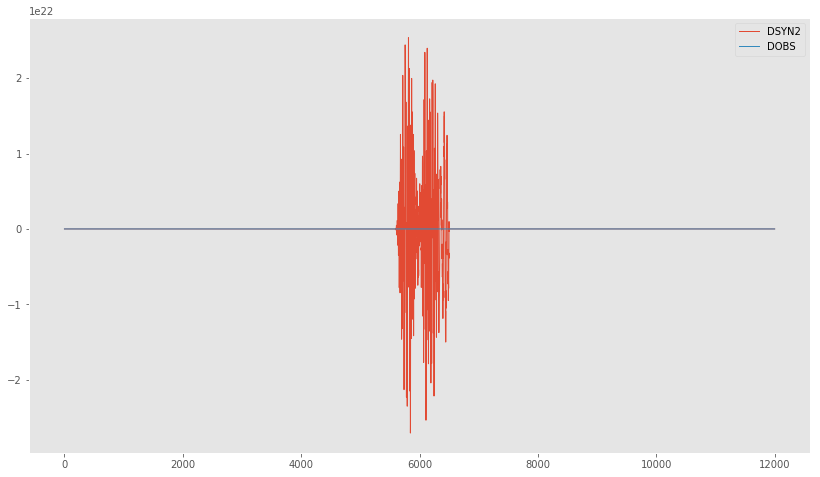

In [1510]:
DSYN2 = np.convolve(S1, G, mode=mode)
plt.plot(DSYN2, label='DSYN2')
plt.plot(DOBS, label='DOBS')
# plt.xlim(5e3, 7e3)
plt.legend()

## some plots

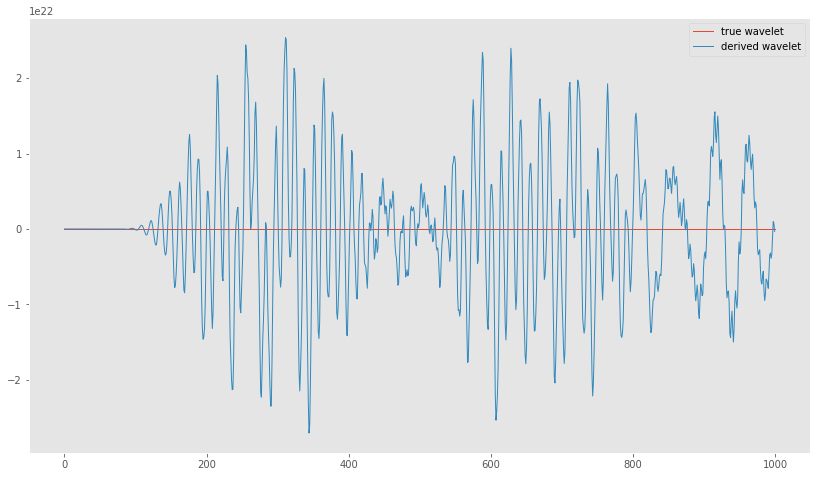

In [1511]:
plt.plot(S, label='true wavelet')
plt.plot(S1, label='derived wavelet')
plt.legend()

In [1512]:
# plt.plot(S0)
# plt.plot(S1)

# Extraction from data (1st pass)

Frequencies of a band-pass filter.

In [3]:
f1 = 2
f2 = 3
f3 = 4.5
f4 = 6.5

In [7]:
dt = 0.005

## Observed data

We want traces with clean direct waves (+ plus ghosts that we will deconvolve) and a linear instrument response. From Ben water-wave picks, Costas, Emilie, and Jack reports.

### Selected trace

For starters, let's take just one observed trace from 4127 with a clear spike. Offset 800 m!!!

In [265]:
fname = 'dobs.sgy'
dobs = read_any(fname)

In [268]:
!su_range.sh 'dobs.sgy'


su_range.sh: START

3200+0 records in
6+1 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.0014462 s, 2.2 MB/s
1 traces:
tracl    6124
tracr    1
fldr     23256
tracf    4127
ep       20
cdpt     1
trid     1
offset   841
gelev    -424
selev    -12
sdepth   12
swdep    435
gwdep    424
scalel   1
scalco   1
sx       -17781
sy       6942
gx       -16945
gy       6852
counit   1
tstat    17
delrt    3
ns       12000
dt       5000
year     2015
day      333
hour     22
minute   16
sec      47
timbas   659
f2       0.000000

Shot coordinate limits:
	North(-17781,6942) South(-17781,6942) East(-17781,6942) West(-17781,6942)

Receiver coordinate limits:
	North(-16945,6852) South(-16945,6852) East(-16945,6852) West(-16945,6852)

Midpoint coordinate limits:
	North(-17363,6897) South(-17363,6897) East(-17363,6897) West(-17363,6897)

su_range.sh: END
Runtime of the su_range.sh: 0 s


Text(0.5, 0, 'time [s]')

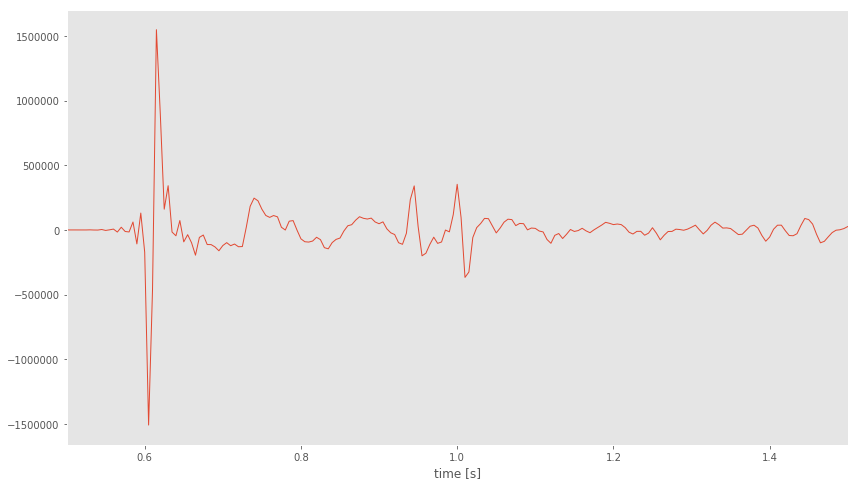

In [273]:
plot(dobs, dt=dt)
plt.xlim(0.5,1.5)
plt.xlabel('time [s]')

### Time-window & filter

Mute the noise ahead of the first arrival as well as all the later arrivals. Lamont source duration is 500 ms, this seems to be a good candidate for a window-width. We set a time for a top mute to 0.5 s, fig...

We apply:
- a top (mode=0) mute for a trace no. 1 (xmute=1, key=tracr) at time 0.5 s (tmute) with 10 samples (50 ms) of a squared-sine taper.
- a bottom (mode=1) mute for a trace no. 1 (xmute=1, key=tracr) at time 0.7 s (tmute) with 10 samples (50 ms) of a squared-sine taper.

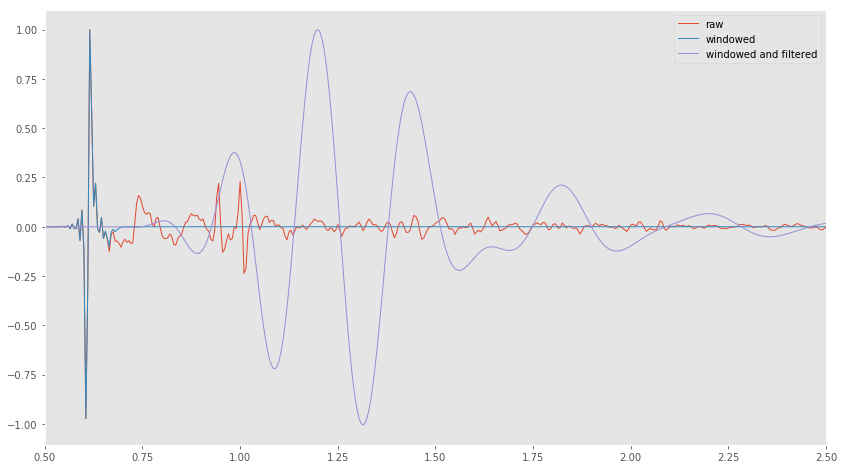

In [277]:
plot(dobs, llabels=['raw'], norm='max', dt=dt)

picks = [0.5]
dobs_m = su_process(dobs, su_mute, dt, picks, mode='both', ntaper=10, twin=0.2)
plot(dobs_m, llabels=['windowed'], norm='max', dt=dt)

dobs_mf = su_process(dobs_m, su_filter, dt, f1=f1, f2=f2, f3=f3, f4=f4, zerophase=0)
plot(dobs_mf, llabels=['windowed and filtered'], norm='max', dt=dt)

plt.xlim(0.5,2.5)
plt.legend()

In [127]:
save_vtr(dobs_mf, 'dobs_mf.vtr')

#### *Old

In [ ]:
# OLD
# !su_sgyread.sh {fname} | sumute xmute=1 tmute=0.5 key=tracr mode=0 ntaper=10 | sumute xmute=1 tmute=0.7 key=tracr mode=1 ntaper=10 | suxwigb

Here we deal with raw data again, i.e. we copied the time-windowing bit from the previous section. We also add extra 4000 samples (extending the trace from 12000 to 16000 samples, or from 60 s to 80 s) and shift it 10 s (i.e. 2000 samples). This effectively adds 10 s padding to both ends of the trace.

In [40]:
# !su_range.sh {fname}

In [46]:
!su_sgyread.sh {fname} | sumute key=tracr nmute=1 xmute=0 tmute=40 | suxwigb

Unknown sumute argument nmute=1
3200+0 records in
6+1 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.00131124 s, 2.4 MB/s
XIO:  fatal IO error 11 (Resource temporarily unavailable) on X server ":1"
      after 122 requests (122 known processed) with 0 events remaining.


In [59]:
# !su_xwigb.sh {fname}

In [30]:
!su_sgyread.sh {fname} | sumute key=tracr |

3200+0 records in
6+1 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.00343464 s, 932 kB/s
XIO:  fatal IO error 11 (Resource temporarily unavailable) on X server ":1"
      after 1112 requests (1112 known processed) with 0 events remaining.


In [31]:
# !su_range.sh {fname}

In [50]:
!su_xwigb.sh {fname} | sumute key=tracr xmute=1 tmute=0.5 mode=0 ntaper=1 | suxwigb

3200+0 records in
6+1 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.00141451 s, 2.3 MB/s
XIO:  fatal IO error 11 (Resource temporarily unavailable) on X server ":1"
      after 150 requests (150 known processed) with 0 events remaining.

sumute: can't read first trace

suxwigb: can't get first trace


In [25]:
!sumute

 	   								
 SUMUTE - MUTE above (or below) a user-defined polygonal curve with	
	   the distance along the curve specified by key header word 	
 	   								
 sumute <stdin >stdout xmute= tmute= [optional parameters]		
 									
 Required parameters:							
 xmute=		array of position values as specified by	
 			the `key' parameter				
 tmute=		array of corresponding time values (sec)	
 			in case of air wave muting, correspond to 	
 			air blast duration				
  ... or input via files:						
 nmute=		number of x,t values defining mute		
 xfile=		file containing position values as specified by	
 			the `key' parameter				
 tfile=		file containing corresponding time values (sec)	
  ... or via header:							
 hmute=		key header word specifying mute time		
 									
 Optional parameters:							
 key=offset		Key header word specifying trace offset 	
 				=tracl  use trace number instead	
 ntaper=0		number of points to taper before hard		
			mute (sine squared taper)			
 mode=0	   mute AB

In [29]:
# !sutaper

!su_sgyread.sh {fname} | sumute xmute=1 tmute=0.5 key=tracr mode=0 ntaper=10 | sumute xmute=1 tmute=0.7 key=tracr mode=1 ntaper=10 | sutaper ntr=1 tbeg=500 tend=500 taper=2 | suvlength ns=16000 | sushw key=tstat a=10000 | sustatic hdrs=1 sign=-1 | subfilt fstoplo={fstoplo} fpasslo={fpasslo} fpasshi={fpasshi} fstophi={fstophi} zerophase={zerophase} | segyhdrs | segywrite tape=dobs_filt.sgy

In [47]:
!su_sgyread.sh {fname} | sumute xmute=1 tmute=0.5 key=tracr mode=0 ntaper=10 | sumute xmute=1 tmute=0.7 key=tracr mode=1 ntaper=10 | sutaper ntr=1 tbeg=500 tend=500 taper=2 | suvlength ns=16000 | sushw key=tstat a=10000 | sustatic hdrs=1 sign=-1 | subfilt fstoplo={fstoplo} fpasslo={fpasslo} fpasshi={fpasshi} fstophi={fstophi} zerophase={zerophase} | segyhdrs | segywrite tape=dobs_filt.sgy
# !su_sgyread.sh {fname} | sumute xmute=1 tmute=0.5 key=tracr mode=0 ntaper=10 | sumute xmute=1 tmute=0.7 key=tracr mode=1 ntaper=10 | sutaper ntr=1 tbeg=500 tend=500 taper=2 | suvlength ns=16000 | sushw key=tstat a=10000 | sustatic hdrs=1 sign=-1 | subfilt fstoplo={fstoplo} fpasslo={fpasslo} fpasshi={fpasshi} fstophi={fstophi} zerophase={zerophase} | suxwigb
# !su_sgyread.sh {fname} | sutaper ntr=1 tbeg=500 tend=500 taper=2 | suvlength ns=16000 | sushw key=tstat a=10000 | sustatic hdrs=1 sign=-1 | subfilt fstoplo={fstoplo} fpasslo={fpasslo} fpasshi={fpasshi} fstophi={fstophi} zerophase={zerophase} | suspecfx | suxwigb
# !su_sgyread.sh {fname} | sutaper ntr=1 tbeg=500 tend=500 taper=2 | suvlength ns=16000 | sushw key=tstat a=10000 | sustatic hdrs=1 sign=-1 | subfilt fstoplo={fstoplo} fpasslo={fpasslo} fpasshi={fpasshi} fstophi={fstophi} zerophase={zerophase} | segyhdrs | segywrite tape={fname}_filt.sgy


segyread: syscalls.c: eopen: open failed (No such file or directory)

sumute: can't read first trace

sumute: can't read first trace

sutaper: can't get first trace

suvlength: can't get first trace

sustatic: can't get first trace

subfilt: can't get first trace

segyhdrs: can't get first trace
6+1 records in
1+0 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 9.8532e-05 s, 32.5 MB/s

segywrite: conflict: tr.ns = 0, bh.ns = 12000: trace 1


In [44]:
!su_xwigb.sh dobs_filt.sgy


suxwigb.sh: START

3200+0 records in
6+1 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.00145892 s, 2.2 MB/s

segyread: discrepant tr.ns = 0 with tape/user ns = 12000
	... first noted on trace 1

segyread: discrepancy found in header and trace ns values
the value (12000) was used to extract traces

suxwigb: tr.dt not set, assuming dt=0.004
XIO:  fatal IO error 11 (Resource temporarily unavailable) on X server ":1"
      after 142 requests (142 known processed) with 0 events remaining.

suxwigb.sh: END
Runtime of the suxwigb.sh: 2 s


## Synthetic data

We want to generate synthetics for the same sources and receivers as the observed data. We are only interested in a direct wave (including the ghost), that's why we can use a water-velocity model (with a free surface) and very few time-steps. The size of the model can also be small provided the number of time-steps is small enough that we don't include spurious reflections from other model boundaries.   

If we analyze only one trace, the easiest way is to manually read the shot and receiver coordinates and convert them to nodes for a given model.

For more traces, we want to read all the headers and convert the coordinates automatically. We can use SegyPrep for it.

### Read coordinates

Read coordinates of all sources and receivers to decide on a proper model size.

In [128]:
header2json(fname)
df = pd.read_json(strip(fname)+'_HEAD.json')
sx = df.sx[0]
sy = df.sy[0]
gx = df.gx[0]
gy = df.gy[0]
print(sx, sy, gx, gy)
print('offset', np.sqrt((sx-gx)**2 + (sy-gy)**2))

Exporting the header of dobs.sgy to dobs_HEAD.json
-17781 6942 -16945 6852
offset 840.8305417859177


### Set up a project

In [129]:
# ALL IN [m]
pad = 5000
x1 = min(min(df.sx), min(df.gx)) - pad
x2 = max(max(df.sx), max(df.gx)) + pad
y1 = min(min(df.sy), min(df.gy)) - pad
y2 = max(max(df.sy), max(df.gy)) + pad
z1 = 0 # CUT AT FS
z2 = 2 * pad
box = [x1, x2, y1, y2, z1, z2]

dt = 0.005   # [s], AS IN RAW DATA
ns = 1000    # [samples], THIS GIVES 0.5 s TIME-WINDOW
dx = 50      # [m]
timespace = [box, dx, ns, dt]

In [130]:
proj = ProjSyn('synth', io='fw3d', timespace=timespace)

### Prepare input

In [68]:
proj.vp.true.create(vel=1500)
# proj.vp.true.plot()

Text(0.5, 1.0, 'Initial guess - filtered spike')

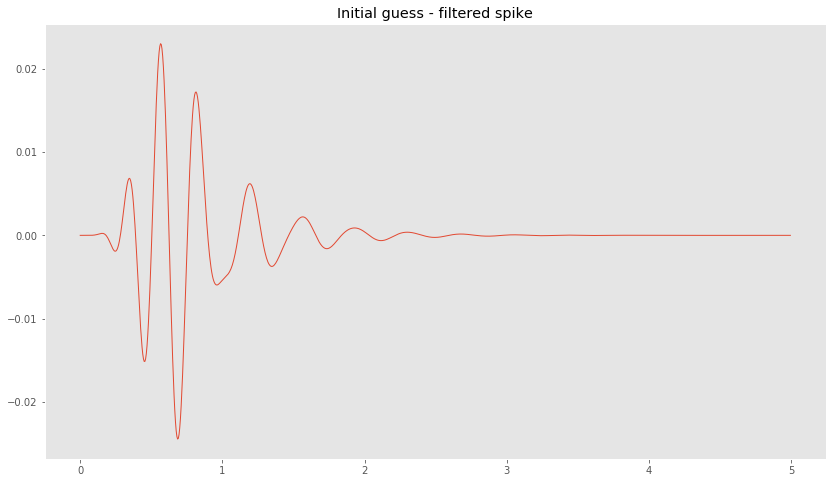

In [279]:
nsamps = 1000
spike = np.zeros((1,1,nsamps))
spike[0,0,0] = 1 # AT TIME ZERO
s0 = su_process(spike, su_filter, dt=proj.dt, zerophase=0, f1=2, f2=3, f3=4.5, f4=6.5) # FIRST-GUESS SOURCE
save_vtr(s0, 's0.vtr')
!cp tmp_filt.sgy {proj.inp.wavelet.fname}
# proj.inp.wavelet.plot()
plot('tmp_filt.sgy', dt=dt)
plt.title('Initial guess - filtered spike')

In [91]:
proj.inp.sp.create()

{'FFID': 'yes',
 'debug': 'yes',
 'dtms': 5.0,
 'dx': 50,
 'fixed array': 'yes',
 'geometry': 'segy',
 'io': 'fw3d',
 'nx1': 217,
 'nx2': 202,
 'nx3': 201,
 'outseis': 'yes',
 'problem': 'synthetic',
 'reciprocity': 0,
 'retain': 'yes',
 'text': 'yes',
 'ttime': 5000.0,
 'unique': 'yes',
 'x origin': -22781,
 'x shift': 0,
 'y origin': 1852,
 'y shift': 0,
 'z type': 'elevation'}

In [97]:
proj.inp.runfile.create()
proj.inp.runfile.cat()

Content of  ./synth//inp/synth-Runfile.key : 
    ! May 2019, K. Chrapkiewicz 
    ! THIS RUNFILE CONFORMS TO
    ! FULLWAVE REV.688 STANDARD
    ! A. PROBLEM DEFINITION
problem : synthetic
     domain        : time
     dim           : 3D
     equation      : acoustic
     units         : metric
     anisotropy    : none
     kernel        : low
    ! B. MODEL DEFINITON
NX1 : 217
NX2 : 202
NX3 : 201
     DX            : 50.0
    ! X. FREE SURFACE
     ibfs          : 1
     seaLevel      : 0
     maxGhostIter  : 2
     vacuum        : 0
     accuracy      : 0.001
     minGhostFS    : 0.001
     minFictFS     : 0.5
     interpMode    : 1
     srcType       : 0
     recType       : 0
    ! C. DATA DEFINITION
NCOMP : 1
NSHOTS : 1
NRECS : 1
MAXRC : 1
     MAXPS         : 1
io : FW3D
    ! D. BOUNDARY CONDITIONS
btop : 0
bbot : 40
bleft : 40
bright : 40
bfront : 40
bback : 40
extratop : 0
extrabot : 50
extraleft : 50
extraright : 50
extrafront : 50
extraback : 50
    ! F. MUTES & DATA SELE

### Output

(0, 1000)

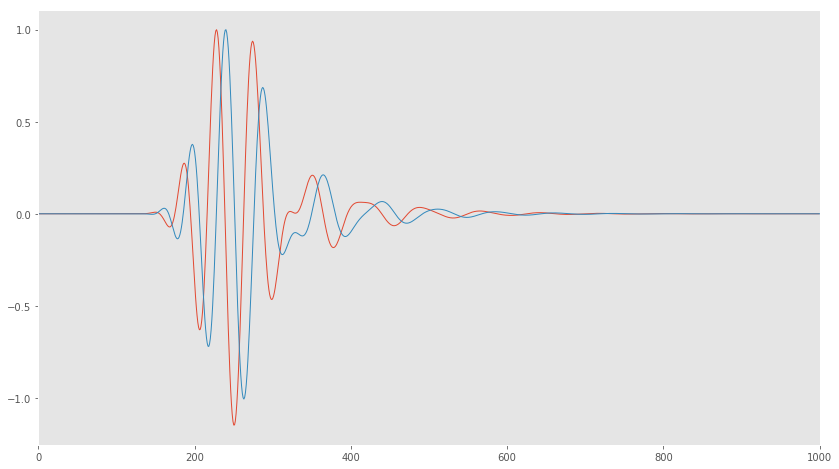

In [131]:
dsyn = read_any('./synth/inp/synth-Observed-Time.ttr')
plot(dsyn, norm='max')
plot(dobs_mf, norm='max')
plt.xlim(0,1000)

### *Wavelet (old)

Filtered spike.

In [69]:
nsamps = 1000
spike = np.zeros((1,1,nsamps))
spike[0, 0, 0] = 1
save_vtr(spike, 'spike.vtr')

In [70]:
!convert_vtr2sgy.sh spike.vtr
!su_sgyread.sh spike.sgy | sushw key=ns a={nsamps} | segyhdrs | segywrite tape=spike.sgy
!su_sgyread.sh spike.sgy | sushw key=dt a=5000 | segyhdrs | segywrite tape=spike.sgy


convert_vtr2sgy.sh: START

spike.vtr

VTR to SEG-Y file conversion  -  v1.31
****************************

Output traces by in-line then x-line? (default = yes) >> SEG-Y trace order will be transposed
Name of input VTR file? (default = exit) >> VTR file has 1 components and 2 dimensions
VTR file has  1000 samples per trace
                 1 traces crossline
                 1 traces inline
Grid spacing (1.0) >> Name of SEG-Y output file? (from VTR name) >> Output file spike.sgy already exists
OK to overwrite? (no) >> Name of input VTR file? (default = exit) >> 
convert_vtr2sgy.sh: END
Runtime of the convert_vtr2sgy.sh: 0 s
3200+0 records in
6+1 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.00376661 s, 850 kB/s

segyread: discrepant tr.ns = 0 with tape/user ns = 1000
	... first noted on trace 1

segyread: discrepancy found in header and trace ns values
the value (1000) was used to extract traces

segyhdrs: hdt not set in binary header, consider using dt=
6+1 records in
1+0 record

In [129]:
!su_sgyread.sh 'spike.sgy' | subfilt fstoplo={fstoplo} fpasslo={fpasslo} fpasshi={fpasshi} fstophi={fstophi} zerophase={zerophase} | segyhdrs | segywrite tape=spike_filt.sgy


3200+0 records in
6+1 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.00132794 s, 2.4 MB/s
6+1 records in
1+0 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 6.2053e-05 s, 51.6 MB/s


In [71]:
!su_xwigb.sh spike_filt.sgy


suxwigb.sh: START

3200+0 records in
6+1 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.00138139 s, 2.3 MB/s
XIO:  fatal IO error 11 (Resource temporarily unavailable) on X server ":1"
      after 142 requests (142 known processed) with 0 events remaining.

suxwigb.sh: END
Runtime of the suxwigb.sh: 2 s


### *Output (old)

In [146]:
!su_xwigb.sh synth/inp/synth-Synthetic.sgy


suxwigb.sh: START

3200+0 records in
6+1 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.00153009 s, 2.1 MB/s
XIO:  fatal IO error 11 (Resource temporarily unavailable) on X server ":0"
      after 138 requests (138 known processed) with 0 events remaining.

suxwigb.sh: END
Runtime of the suxwigb.sh: 2 s


In [147]:
!su_range.sh synth/inp/synth-Synthetic.sgy


surange.sh: START

3200+0 records in
6+1 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.00128932 s, 2.5 MB/s
1 traces:
tracl    6124
tracr    1
fldr     23256
tracf    4127
ep       20
cdpt     1
trid     1
offset   841
gelev    -424
selev    -12
sdepth   12
swdep    435
gwdep    424
scalel   1
scalco   1
sx       -17781
sy       6942
gx       -16945
gy       6852
counit   1
tstat    17
delrt    3
ns       1000
dt       5000
year     2015
day      333
hour     22
minute   16
sec      47
timbas   659
f2       0.000000

Shot coordinate limits:
	North(-17781,6942) South(-17781,6942) East(-17781,6942) West(-17781,6942)

Receiver coordinate limits:
	North(-16945,6852) South(-16945,6852) East(-16945,6852) West(-16945,6852)

Midpoint coordinate limits:
	North(-17363,6897) South(-17363,6897) East(-17363,6897) West(-17363,6897)

surange.sh: END
Runtime of the surange.sh: 0 s


### *Shift and extend for decon (old)

In [89]:
# !su_sgyread.sh synth/inp/synth-Synthetic.sgy | suvlength ns=16000 | sushw key=tstat a=30000 | sustatic hdrs=1 sign=-1 | segyhdrs | segywrite tape=dsyn_shift.sgy

## Wiener deconvolution 

Can we define a filter using multiple traces?

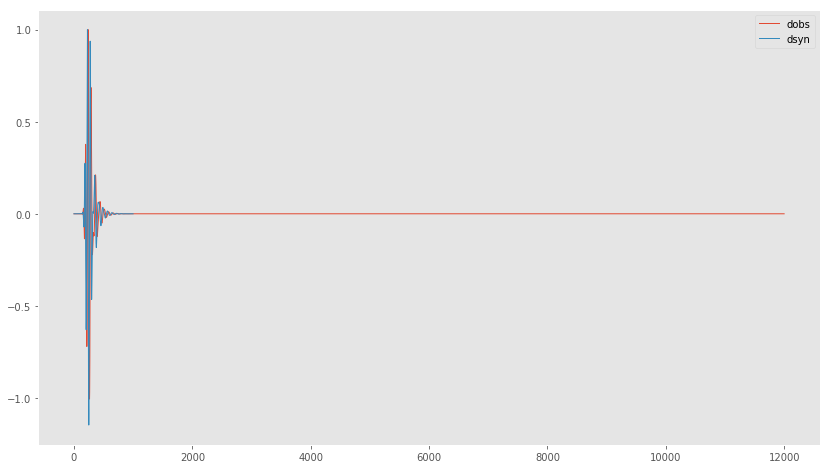

In [1188]:
norm = 'max' #None
plot(dobs_mf, norm=norm, llabels=['dobs'])
# plot(s0, norm='max', llabels=['s0'])
plot(dsyn, norm=norm, llabels=['dsyn'])
# print(dobs_mf.shape)
# print(dsyn.shape)
# compare(dobs_mf, dsyn)
# plt.xlim(0,1000)
plt.legend()

### Shift and pad synthetics

For better performance of the inverse filter. Should we do the same with dobs?

In [145]:
5500 * 0.005

27.5

ns to add at each end 5500.0
tshift_ms 27500.0


(1, 1, 12000)


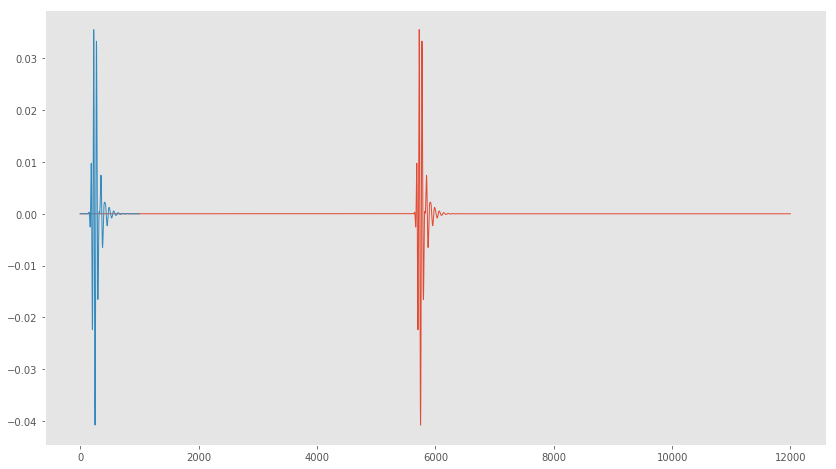

In [1521]:
dsyn_p = su_process(dsyn, su_pad, proj.dt, pad_s=27.5, tracelen=dsyn.shape[-1])
print(dsyn_p.shape)
plot(dsyn_p)
plot(dsyn)

### Deconvolve

APPARENTLY LEN(DINP) MUST BE LEN(DOUT)

(0, 2000)

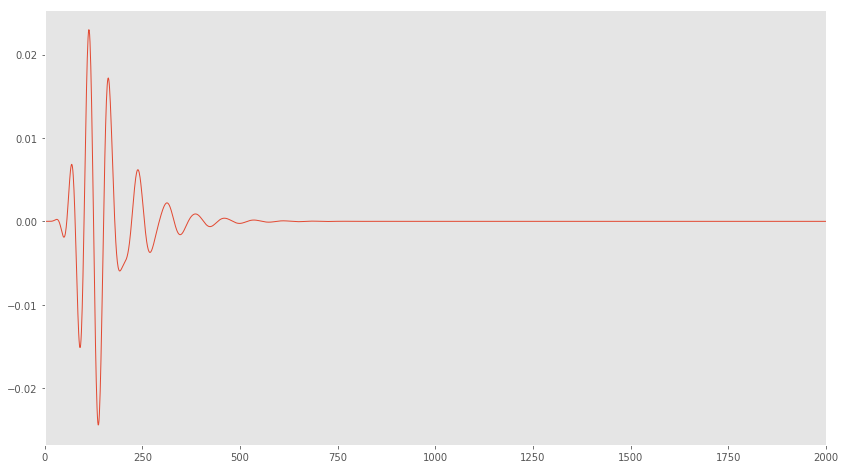

In [1531]:
s0_pad = np.zeros((1, 1, 12000))
s0_pad[0, 0, :len(s0[0][0])] = s0[0][0]
plot(s0_pad)
plt.xlim(0,2000)

len(shaper) 12000


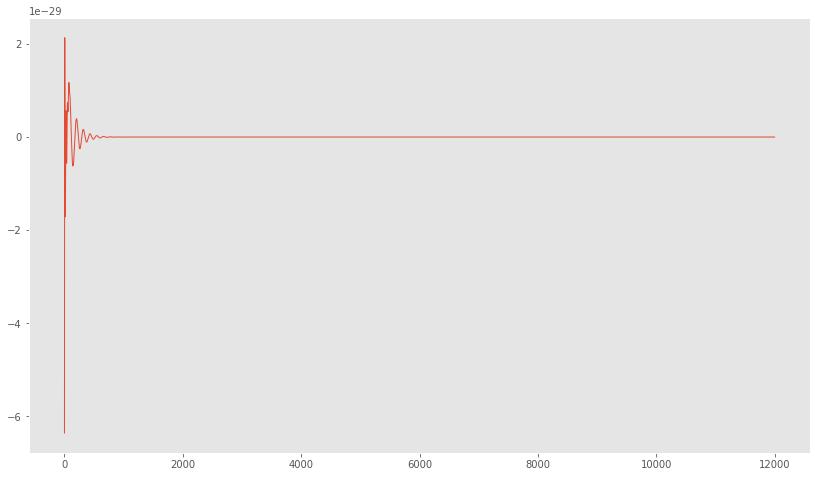

In [1540]:
d_inp = dsyn_p / np.max(dsyn_p)
d_out = dobs_mf / np.max(dobs_mf)

# print(s0.shape, d_inp.shape, d_out.shape)

s1 = su_process(s0_pad, su_decon, proj.dt, d_inp=d_inp, d_out=d_out, pnoise=.001)
# plot(s1)

len(shaper) 12000


(0, 1000)

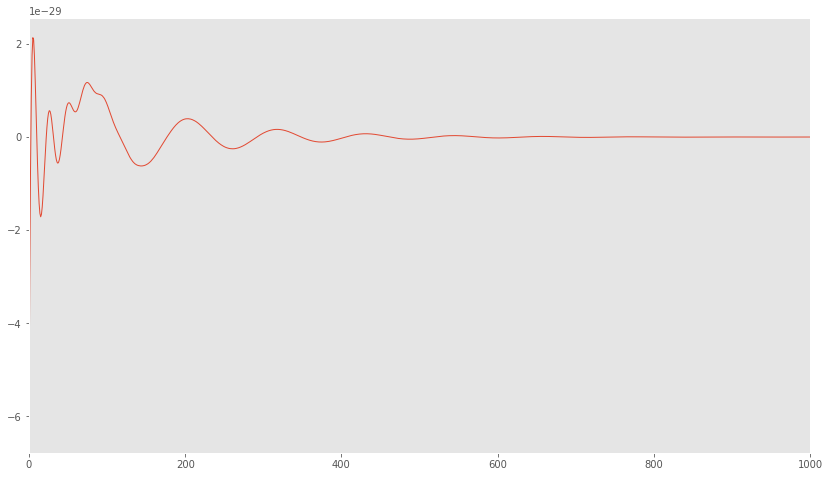

In [1546]:
plot_shaper()

(0, 1000)

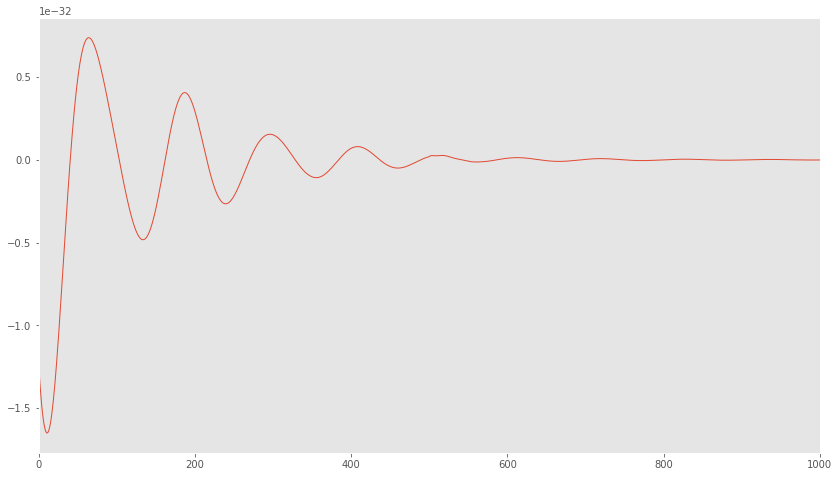

In [1552]:
plt.plot(np.convolve(shaper, s0[0][0], mode='same'))
plt.xlim(0, 1000)

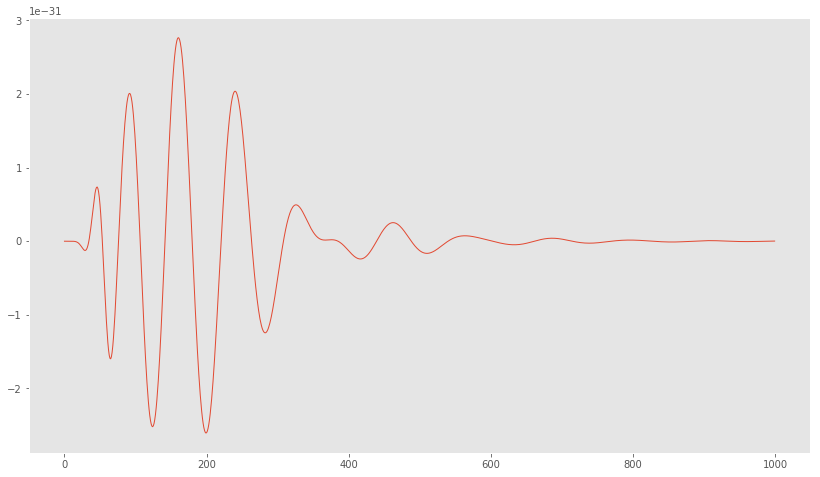

In [1538]:
plot(s1)

(0, 1000)

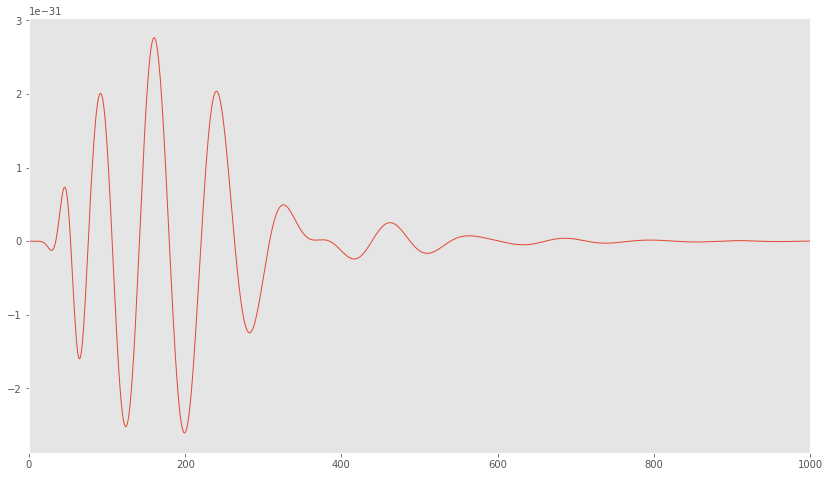

In [1542]:
plot(s1)
plt.xlim(0,1000)

Note ultralow amplitude!

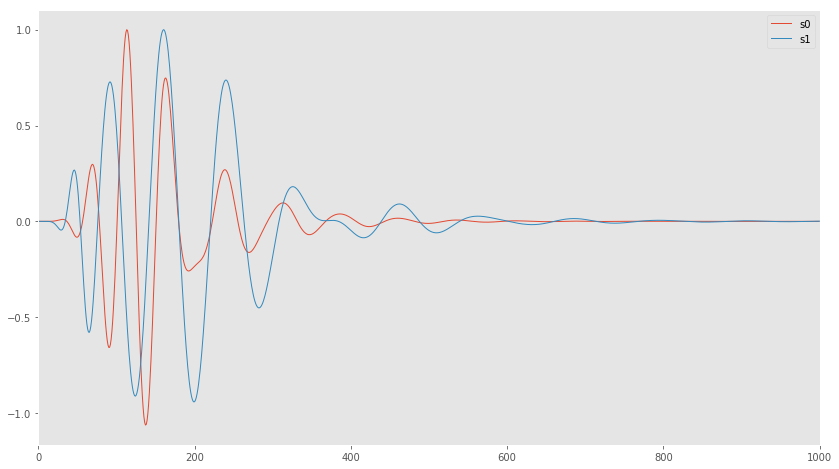

In [1524]:
norm = 'max' #None
# plot(dobs_mf, norm='max', llabels=['dobs'])
plot(s0, norm=norm, llabels=['s0'])
# plot(dsyn, norm='max', llabels=['dsyn'])
plot(s1, norm=norm, llabels=['s1'])
plt.xlim(0,1000)
plt.legend()

In [1213]:
# deconvolve(d_out[0][0], d_inp[0][0])

### *Old

#### Shift dobs back?

In [156]:
!su_xwigb.sh dobs_filt.sgy


suxwigb.sh: START

3200+0 records in
6+1 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.00151769 s, 2.1 MB/s
XIO:  fatal IO error 11 (Resource temporarily unavailable) on X server ":0"
      after 863 requests (863 known processed) with 0 events remaining.

suxwigb.sh: END
Runtime of the suxwigb.sh: 9 s


In [174]:
# !su_sgyread.sh dsyn_shift.sgy |  suifft | suxwigb #| segyhdrs | segywrite tape=prewhite.sgy

In [175]:
# !su_xwigb.sh prewhite.sgy

#### Sushape

In [177]:
!segyread tape='dsyn_shift.sgy' > d_syn.su
!suxwigb < d_syn.su

3200+0 records in
6+1 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.00144082 s, 2.2 MB/s
XIO:  fatal IO error 11 (Resource temporarily unavailable) on X server ":0"
      after 822 requests (822 known processed) with 0 events remaining.


In [180]:
!surange < d_syn.su

1 traces:
tracl    6124
tracr    1
fldr     23256
tracf    4127
ep       20
cdpt     1
trid     1
offset   841
gelev    -424
selev    -12
sdepth   12
swdep    435
gwdep    424
scalel   1
scalco   1
sx       -17781
sy       6942
gx       -16945
gy       6852
counit   1
tstat    30000
delrt    3
ns       16000
dt       5000
year     2015
day      333
hour     22
minute   16
sec      47
timbas   659
f2       0.000000

Shot coordinate limits:
	North(-17781,6942) South(-17781,6942) East(-17781,6942) West(-17781,6942)

Receiver coordinate limits:
	North(-16945,6852) South(-16945,6852) East(-16945,6852) West(-16945,6852)

Midpoint coordinate limits:
	North(-17363,6897) South(-17363,6897) East(-17363,6897) West(-17363,6897)


In [178]:
!segyread tape='dobs_filt.sgy' > d_obs.su
!suxwigb < d_obs.su

3200+0 records in
6+1 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.00156194 s, 2.0 MB/s
XIO:  fatal IO error 11 (Resource temporarily unavailable) on X server ":0"
      after 2425 requests (2425 known processed) with 0 events remaining.


In [181]:
!surange < d_obs.su

1 traces:
tracl    6124
tracr    1
fldr     23256
tracf    4127
ep       20
cdpt     1
trid     1
offset   841
gelev    -424
selev    -12
sdepth   12
swdep    435
gwdep    424
scalel   1
scalco   1
sx       -17781
sy       6942
gx       -16945
gy       6852
counit   1
tstat    10000
delrt    3
muts     500
mute     700
ns       16000
dt       5000
year     2015
day      333
hour     22
minute   16
sec      47
timbas   659
f2       0.000000

Shot coordinate limits:
	North(-17781,6942) South(-17781,6942) East(-17781,6942) West(-17781,6942)

Receiver coordinate limits:
	North(-16945,6852) South(-16945,6852) East(-16945,6852) West(-16945,6852)

Midpoint coordinate limits:
	North(-17363,6897) South(-17363,6897) East(-17363,6897) West(-17363,6897)


In [186]:
!segyread tape='spike_filt.sgy' > s_inp.su
!suxwigb < s_inp.su

3200+0 records in
6+1 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.00143811 s, 2.2 MB/s
XIO:  fatal IO error 11 (Resource temporarily unavailable) on X server ":0"
      after 142 requests (142 known processed) with 0 events remaining.


In [182]:
!surange < s_inp.su

1 traces:
tracl    1
tracr    1
fldr     1
tracf    1
ep       1
cdp      1
cdpt     1
trid     1
nvs      1
nhs      1
duse     1
scalel   1
scalco   1
counit   1
ns       1000
dt       5000
gain     3


In [48]:
!segyhdrs < s_inp.su | segywrite tape='s_inp.sgy'

6+1 records in
1+0 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.000104701 s, 30.6 MB/s


In [176]:
!sushape

 									
 SUSHAPE - Wiener shaping filter					
 									
  sushape <stdin >stdout  [optional parameters]			
 									
 Required parameters:							
 w=		vector of input wavelet to be shaped or ...		
 ...or ... 								
 wfile=        ... file containing input wavelet in SU (SEGY trace) format
 d=		vector of desired output wavelet or ...			
 ...or ... 								
 dfile=        ... file containing desired output wavelet in SU format	
 dt=tr.dt		if tr.dt is not set in header, then dt is mandatory
 									
 Optional parameters:							
 nshape=trace		length of shaping filter			
 pnoise=0.001		relative additive noise level			
 showshaper=0		=1 to show shaping filter 			
 									
 verbose=0		silent; =1 chatty				
 									
Notes:									
 									
 Example of commandline input wavelets: 				
sushape < indata  w=0,-.1,.1,... d=0,-.1,1,.1,... > shaped_data	
 									
sushape < indata  wfile=inputwavelet.su dfile=desire.su > shaped_data	
 									
 To get the shaping filters into an as

In [184]:
!sushape < s_inp.su wfile=d_syn.su dfile=d_obs.su pnoise=0.001 showshaper=0 > s_out.su
!suxwigb < s_out.su

XIO:  fatal IO error 11 (Resource temporarily unavailable) on X server ":0"
      after 142 requests (142 known processed) with 0 events remaining.


In [2]:
!suxwigb < s_out.su

XIO:  fatal IO error 11 (Resource temporarily unavailable) on X server ":0"
      after 142 requests (142 known processed) with 0 events remaining.


In [1]:
!surange < s_out.su

1 traces:
tracl    1
tracr    1
fldr     1
tracf    1
ep       1
cdp      1
cdpt     1
trid     1
nvs      1
nhs      1
duse     1
scalel   1
scalco   1
counit   1
ns       1000
dt       5000
gain     3


In [32]:
!segyhdrs < s_out.su | segywrite tape=s_out.sgy

6+1 records in
1+0 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.000233003 s, 13.7 MB/s


In [36]:
plot('s_out.vtr')

DEBUG: fullwavepy.generic.plot.wrapper_debug: plot started.
DEBUG: fullwavepy.generic.plot.wrapper_debug: plot_file started.
DEBUG: fullwavepy.ioapi.fw3d.wrapper_debug: plot_vtr started.
DEBUG: fullwavepy.ioapi.fw3d.wrapper_debug: read_vtr started.
DEBUG: fullwavepy.ioapi.fw3d.read_vtr: min value: -1.1257399e-17
DEBUG: fullwavepy.ioapi.fw3d.read_vtr: max value: 1.2103403e-17
DEBUG: fullwavepy.ioapi.fw3d.read_vtr: nx1, nx2, nx3: 1 1 1000
DEBUG: fullwavepy.ioapi.fw3d.wrapper_debug: read_vtr finished.
DEBUG: fullwavepy.generic.plot.wrapper_debug: plot_array started.
DEBUG: fullwavepy.signal.process.wrapper_debug: data_modify started.
DEBUG: fullwavepy.signal.process.wrapper_debug: data_modify finished.
DEBUG: fullwavepy.generic.plot.wrapper_debug: plot_model started.
DEBUG: fullwavepy.generic.plot.wrapper_debug: plot_model finished.
DEBUG: fullwavepy.generic.plot.wrapper_debug: plot_array finished.
DEBUG: fullwavepy.ioapi.fw3d.wrapper_debug: plot_vtr finished.
DEBUG: fullwavepy.generic.pl

## Synthetic data (check)

In [1197]:
fname = 's1_n.sgy'
array2sgy(fname, s1 / np.max(s1), dt=proj.dt)

In [1179]:
fname = 's1.sgy'
array2sgy(fname, s1, dt=proj.dt)

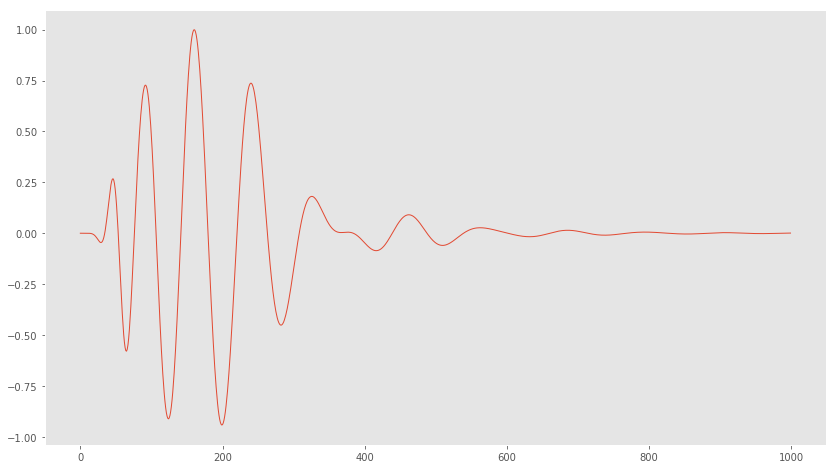

In [1198]:
!cp {fname} synth2/inp/synth2-RawSign.sgy
plot('synth2/inp/synth2-RawSign.sgy')
# plot(s1)
# plot(proj.inp.wavelet.fname)

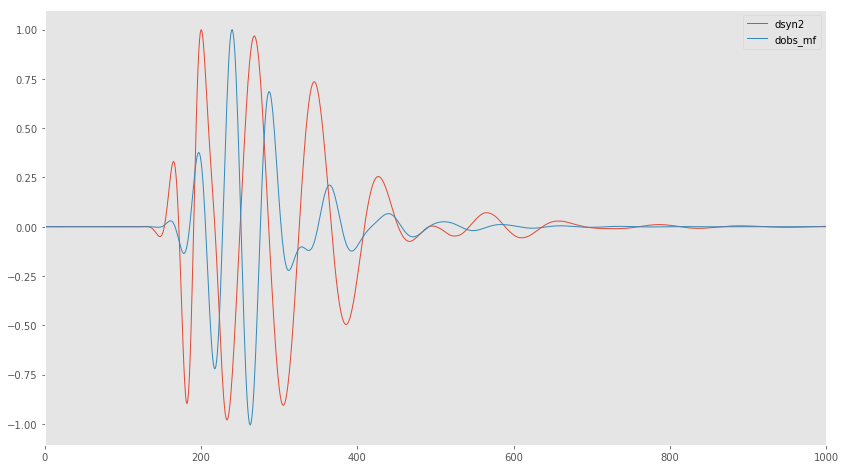

In [1206]:
norm = 'max' #None #
dsyn2 = read_any('./synth2/inp/synth2-Observed-Time.ttr')
# plot(s0, norm='max')
# plot('./synth2/inp/synth2-RawSign.sgy', norm='max')
plot(dsyn2, norm=norm, llabels=['dsyn2'])
# # plot(dsyn, norm='max')
plot(dobs_mf, norm=norm, llabels=['dobs_mf'])
plt.xlim(0,1000)
plt.legend()
# proj.inp.wavelet.plot()

# Extraction from data (0th pass)

In [ ]:
dt = 0.005   # s (AS IN RAW DATA)
ns = 600     # samples (THIS GIVES 0.5 s OF TIME WINDOW AS SUGGESTED BY MIKE) 
dx = 50      # m
x1 = -4e4    # m
x2 = -2e4    # m
y1 = -5e3    # m
y2 = +5e3    # m
z1 = 0       # m <=> CUT AT THE SEA SURFACE
z2 = 2000    # m
box = [x1, x2, y1, y2, z1, z2]
timespace = [box, dx, ns, dt]
# whoi.Set_Geometry(box=box, dt=dt, ns=ns)
# whoi.Plot_Geometry(s_factor=10, lims_pad=1000)#, full_map=1) #, 
# # whoi.Plot_Geometry(s_factor=2) #, full_map=1) #xlim=[-4e4, 4e4], ylim=[-5e3, 15e3], 
# print whoi.dims

In [ ]:
# whoi = Proj_Syn('whoi', './', io='sgy', timespace=timespace)

## Extract from observed data

- in principle, if we had an accurate model, fully physical forward solver and noiseless data we could obtain the wavelet in 2 easy steps:
    - generate synthetics with any initial-guess source wavelet
    - deconvolve them from the observed data (data range wouldn't matter)
- variable negative motion after the first high-amplitude, high-frequency positive peak
    - present in most of the closest (single trace) shots

In [ ]:
#  !ln -s ~/heavy_PhD/DATA/Santorini_2015/seismic/OBS/segy_local_coords/MGL1521_W1*_4.sgy .

In [ ]:
prefix = 'MGL1521_W' # WHOI `
suffix = '_4.sgy'    # HYDROPHONE

print 'No. of WHOI stations is almost twice as few as SIO!'
!ls {prefix}*{suffix} | wc -l

### Extract the traces within selected offset-range

In [ ]:
IDs = ['105', '108', '110', '139', '140', '146', '147', 
       '162', '164', '176', '183', '186', '188'] # SOME OF THE WHOIs (SAME AS IN JACK'S REPORT)

for ID in IDs:
    fname = prefix + ID + suffix
    #print fname
    offset_min = 0 # m
    offset_max = 1000 # m
    fname_new = fname[ :-len('.sgy')] + '_offs_' + str(offset_min) + '-' + str(offset_max) + '.sgy'
    fname_new_vtr = Ext_Change(fname_new, 'vtr')
    !su_sgyread.sh {fname} | suwind key=offset min={offset_min} max={offset_max} | segyhdrs | segywrite tape={fname_new}
    !convert_sgy2vtr_2D.sh {fname_new}

In [ ]:
!ls -lth

In [ ]:
!su_sgyread.sh 'MGL1521_W186_4_offs_100-300.sgy' | suwind key=tracl min=2445 max=2445 | segyhdrs | segywrite tape='MGL1521_W186_4_shot_2445.sgy'

In [ ]:
# !su_sgyread.sh 'MGL1521_W186_4_shot_2445.sgy' | subfilt zerophase=0 fstoplo=2 fpasslo=3 fpasshi=5 fstophi=6 | suspecfx | suxwigb
!su_sgyread.sh 'MGL1521_W186_4_shot_2445.sgy' | subfilt zerophase=0 fstoplo=2 fpasslo=3 fpasshi=5 fstophi=6 | segyhdrs | segywrite tape='MGL1521_W186_4_shot_2445_filtered.sgy'

In [ ]:
Plot('MGL1521_W186_4_offs_100-300.vtr', data_type='data', normalize='max', gap=5)
plt.ylim(600, 0)

### Single trace

<IPython.core.display.Javascript object>


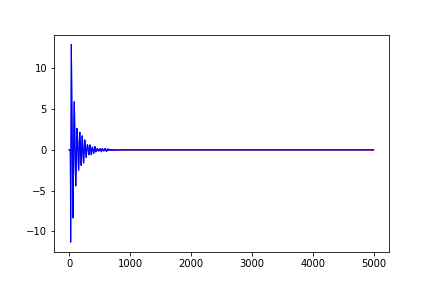

0

In [61]:
%matplotlib notebook
%matplotlib notebook
from fullwavepy.ioapi.fw3d import Plot_vtr
Plot_vtr('mp_source_3d_17-10-17.vtr', data_type='wavelet')

In [ ]:
f1 = 'mp_source_3d_7.5Hz_17-10-17.sgy'
f2 = 'mp_source_3d_17-10-17.sgy'

In [ ]:
!ls mp_source_3d_17-10-17.vtr

In [ ]:
logging.root.handlers=[]
print(logging.root.handlers)

In [ ]:
from fullwavepy.ioapi.fw3d import Read_vtr 
Read_vtr('mp_source_3d_17-10-17.vtr')

In [ ]:
!su_xwigb.sh 'MGL1521_W186_4_offs_100-300.sgy'

### Align and stack

In [ ]:
n1, n2, n3, traces = Read_vtr('MGL1521_W186_4_offs_100-300.vtr')

In [ ]:
i = 0
for trace in traces:
    trace = trace[0]
    plt.plot(trace, label='trace index ' + str(i))
    plt.xlim(60,80)
    i += 1 

plt.grid()
plt.legend()

### Band-pass filter (skip)

In [ ]:
# LOW-PASS 
# !segyread tape=MGL1521_W105_4_offs_0-300.sgy | subfilt locut=0 fpasshi=5 fstophi=7 zerophase=0 | suxwigb
# !segyread tape=MGL1521_W105_4_offs_0-300.sgy | subfilt locut=0 fpasshi=5 fstophi=7 zerophase=0 | suspecfx | suxwigb

In [ ]:
# BAND-PASS
!segyread tape=MGL1521_W105_4_offs_0-300.sgy | subfilt fstoplo=2 fpasslo=3 fpasshi=5 fstophi=7 zerophase=0 | suxwigb
# !segyread tape=MGL1521_W105_4_offs_0-300.sgy | subfilt fstoplo=2 fpasslo=3 fpasshi=5 fstophi=7 zerophase=0 | suspecfx | suxwigb

In [ ]:
fname = 'MGL1521_W105_4_offs_0-300.sgy'
fname_new = 'MGL1521_W105_4_offs_0-300_subfilt_2-3-5-7.sgy'
!segyread tape={fname} | subfilt fstoplo=2 fpasslo=3 fpasshi=5 fstophi=7 zerophase=0 | segyhdrs | segywrite tape={fname_new}

In [ ]:
# !su_xwigb.sh MGL1521_W105_4_offs_0-300_subfilt_2-3-5-7.sgy

## Initial guess

### M1 Kronecker delta

In [ ]:
# !su_xwigb.sh whoi-RawSign_bandpass_minphase1-2-5-6.sgy
# whoi.inp.wavelet.Filter([0.001,3], filt_type='highpass')
# !su_xwigb.sh whoi-RawSign_highpass_minphase0.001-3.sgy
# !su_xwigb.sh whoi-RawSign_highpass_minphase1-2.sgy

In [ ]:
# whoi.inp.wavelet.Create(shape='dirac')
# whoi.inp.wavelet.Filter([2,3,5,6])
whoi.inp.wavelet.Plot(nx=1)

In [ ]:
# !ls -lth
# !su_xwigb.sh whoi-RawSign.sgy 1

### M2 Stacked traces

In [ ]:
# !convert_sgy2vtr_2D.sh MGL1521_W105_4_offs_0-300_subfilt_2-3-5-7.sgy

In [ ]:
from lib_io_fullwave import Read_vtr, Save_vtr
n1, n2, n3, s = Read_vtr('MGL1521_W105_4_offs_0-300_subfilt_2-3-5-7.vtr')

In [ ]:
plt.plot(s[0][0])
plt.xlim(0,1000)

In [ ]:
# STACK 
stacked = np.zeros(len(s[0][0]))
for trace in s:
    trace = trace[0]
    stacked += trace
    
stacked /= len(s)

In [ ]:
from lib_generic_PLOTT import Plot_2_Series

Plot_2_Series(range(len(stacked)), s[0][0], stacked)
# plt.plot(stacked)
plt.xlim(0,1000)

In [ ]:
# FULLWAVE DOESN'T ACCEPT .txt RawSign though
fname = pname + '-RawSign.txt'
f = open(fname, 'w')
for sample in stacked:
    f.write(str(sample) + '\n')
f.close()

In [ ]:
stacked_3d = Array1D_Convert_To_3D(stacked)
print stacked_3d.shape

In [ ]:
Save_vtr(pname + '-RawSign', 1, 1, len(stacked), stacked_3d)

In [ ]:
Plot(pname + '-RawSign.vtr', data_type='wavelet')

In [ ]:
# !convert_vtr2sgy.sh {pname + '-RawSign.vtr'}

In [ ]:
# !su_xwigb.sh proj1-RawSign.sgy

## Generate synthetic data

### New

In [ ]:
# !echo 'MGL1521_W186_4_offs_100-300.sgy' > {whoi.inp.rawseis.name}

# !su_xwigb.sh MGL1521_W186_4_shot_2445.sgy

# JUST A SINGLE TRACE (PICKED AT RANDOM, BUT WITH LINEAR RESPONSE)
# !echo 'MGL1521_W186_4_shot_2445_filtered.sgy' > {whoi.inp.rawseis.name}
!echo 'MGL1521_W186_4_shot_2445.sgy' > {whoi.inp.rawseis.name}
whoi.inp.rawseis.Cat()

In [ ]:
# whoi.vp.true.Create
# file2dupl = paths['mod'] + 'Ben_whole_model_24-04-18.sgy'
# whoi.vp.true.Duplicate(file2dupl, z_origin=-1500.0)
# whoi.vp.true.Resize()
# whoi.vp.true.Plot()

In [ ]:
# whoi.inp.wavelet.Create()
# whoi.inp.wavelet.Plot(nx=1)

In [ ]:
# whoi.inp.sp.Create(reciprocity=1)
# whoi.inp.sp.Cat()
# # whoi.inp.sp.Run()
# !fwi_run_segyprep.sh {whoi.name}

In [ ]:
# !su_xwigb.sh whoi-Signature.sgy
# whoi.inp.wavelet.Plot(nx=1)

In [ ]:
whoi.inp.runfile.Create()
# whoi.inp.runfile.Cat()

In [ ]:
# whoi.inp.Check()

In [ ]:
# whoi.out.Remove()

In [ ]:
# whoi.Prepare_Output()

In [ ]:
whoi.vp.true.Plot(save=1)

In [ ]:
whoi.out.Plot()

In [ ]:
whoi.out.synth.split['4186']['17'].Plot(data_type='data', fig_size=[20,2])

In [ ]:
# whoi.out.fw.snap

In [ ]:
# !su_sgyread.sh whoi-OutSeis_4186_17.sgy | subfilt zerophase=0 hicut=1 fpasshi=4 fstophi=6 | suxwigb

##### Raw d_obs

In [ ]:
# whoi.inp.outseis.Split()
whoi.inp.outseis.split['4186']['17'].Plot(data_type='data', normalize='rms', nx=3)

In [ ]:
!su_xwigb.sh whoi-OutSeis_4186_17.sgy 

##### Raw d_syn using raw-spike wavelet

In [ ]:
whoi.out.synth.Split()
# whoi.out.synth.split['4186']['17'].Plot(data_type='data', normalize='rms', nx=1)
# plt.figure()
# whoi.out.synth.split['4186']['33'].Plot(data_type='data')

##### Raw d_syn using derived wavelet

In [ ]:
# whoi.out.synth.Split()
whoi.out.synth.split['4186']['17'].Plot(data_type='data', normalize='rms', nx=3)

### Old

In [ ]:
pname = 'proj1'
proj1 = Proj_Synth(pname, io='fw3d')

In [ ]:
proj1.Set_Geometry(box=[0, 1000, 0, 1000, 0, 1000])

In [ ]:
proj1.inp.model.Create(vel=1500) # HOMOG. => x1_box DOESN'T MATTER
Plot(proj1.inp.model.name)

In [ ]:
!ls MGL1521_W105_4_offs_0-300_subfilt_2-3-5-7.sgy > {pname}-RawSeis.txt
!cat {pname}-RawSeis.txt

In [ ]:
# !su_range.sh MGL1521_W105_4_offs_0-300_subfilt_2-3-5-7.sgy

In [ ]:
# DEFINE A BOX AROUND OBS OF INTEREST
x_4105 = 12107
y_4105 = 13590

x_pad = 2000 # m
y_pad = 1000 # m
dx = 50 # m
nx1 = int(2. * x_pad / dx) # nodes
nx2 = int(2. * y_pad / dx) # nodes
nx3 = 20 # nodes
dims = [nx1, nx2, nx3]
x1_box = x_4105 - x_pad
y1_box = y_4105 - y_pad

In [ ]:
from lib_fwi_generic import Segyprep_Create

pars_gen = {'dims': dims, 'dt': 0.005, 'ns': 1000}
pars_sgp = {'geometry': 'sgy', 'reciprocity': 1}
Segyprep_Create(pname, pars_gen=pars_gen, pars_sgp=pars_sgp, x1_box=x1_box, y1_box=y1_box)

In [ ]:
# !cat {pname}-SegyPrep.key

In [ ]:
proj1.inp.Run_Segyprep(verbos=0)

In [ ]:
!cat proj1-PointReceivers.pgy

In [ ]:
!ls -lth

In [ ]:
from lib_fwi_generic import Runfile_Create
Runfile_Create(pname)

In [ ]:
!cat {pname}-Runfile_synth.key

In [ ]:
Plot(pname+'-fw-000500-csref04105-iter00001-taskid00001.vtr', cmap='seismic', yflip=1)

In [ ]:
pro1.out.Plot

In [ ]:
!su_xwigb.sh proj1-Synthetic.sgy

## Wiener filter

SU builds and applies the filter in the same run.

### d_syn

In [ ]:
# !segyread tape='whoi-Synthetic_4186_17.sgy' > d_syn.su
!segyread tape='whoi-Synthetic.sgy' > d_syn.su
!suxwigb < d_syn.su

##### Shift to the middle

In [ ]:
# !convert_sgy2vtr_2D.sh 'whoi-Synthetic.sgy' 
n1, n2, n3, trace = Read_vtr('whoi-Synthetic.vtr')
ns = trace.shape[2]

ntrace = np.zeros((1,1,ns+2000))

ntrace[0, 0, 1000:1000+ns] = trace

Save_vtr('whoi-Synthetic_shifted', 1, 1, ns+2000, ntrace)

In [ ]:
Plot('whoi-Synthetic_shifted.vtr', data_type='data', yflip=1)

### d_obs

In [ ]:
# !convert_sgy2vtr_2D.sh whoi-OutSeis.sgy
# !convert_vtr2sgy.sh whoi-OutSeis.vtr

In [ ]:
Plot('whoi-OutSeis.vtr', data_type='data', yflip=1)

In [ ]:
# !segyread tape='whoi-OutSeis_4186_17.sgy' > d_obs.su
!segyread tape='whoi-OutSeis.sgy' > d_obs.su
!suxwigb < d_obs.su

In [ ]:
# !sushape

### S_inp

In [ ]:
!segyread tape='whoi-Signature.sgy' > s_inp.su
!suxwigb < s_inp.su

### S_out

In [ ]:
!sushape < s_inp.su wfile=d_syn.su dfile=d_obs.su > s_out.su
!suxwigb < s_out.su

In [ ]:
# !subfilt < s_out.su zerophase=0 hicut=1 fpasshi=4 fstophi=6 | suxwigb

In [ ]:
!segyhdrs < s_out.su | segywrite tape=s_out.sgy

In [ ]:
!cp s_out.sgy whoi-RawSign.sgy

In [ ]:
# !su_sgyread.sh test.sgy | subfilt zerophase=0 hicut=1 fpasshi=4 fstophi=6 | segyhdrs | segywrite tape=whoi-RawSign.sgy

# ...